In [1]:
!nvidia-smi

Sat Feb 24 16:02:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 41%   75C    P2              82W / 215W |   6871MiB /  8192MiB |     62%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
sr = 16000
data_dir = '../data/data_preprocessed/meld/features_4balanced/'
data_x = np.load(f'{data_dir}meld.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}meld.label_emotion.npy', allow_pickle=True)

In [6]:
print(len(data_x))
print(len(data_y))

8499
8499


In [7]:
labels = list(np.unique(data_y))
labels

[0, 1, 2, 3]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 6799
Test: 1700


In [9]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [10]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [11]:
import traceback

In [12]:
from IConNet.nn.model import M18
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m18_emo4.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [128, 32], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [2, 9], 'mel_resolution': 4, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 48, 'out_seq_length': 8, 'use_context': False, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.15}}


M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(161, 48, batch_first=True)
    (pad_layer)

In [13]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [14]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [15]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                             | 0.0018867924528301887/10 [00:00<55:26, 332.69s/it]

Train Epoch: 1 [0/6799 (0%)]	Loss: 1.579720
Mem before-during-after: 4572672 3522498560 42927616


  1%|▏                              | 0.07924528301886792/10 [00:13<27:03, 163.65s/it]

Train Epoch: 1 [640/6799 (9%)]	Loss: 1.226456
Mem before-during-after: 43942912 3546536448 42927616


  2%|▍                              | 0.15283018867924528/10 [00:27<32:26, 197.65s/it]

Train Epoch: 1 [1280/6799 (19%)]	Loss: 1.036041
Mem before-during-after: 41976832 3544576000 41976832


  2%|▊                                | 0.230188679245283/10 [00:40<26:16, 161.35s/it]

Train Epoch: 1 [1920/6799 (28%)]	Loss: 1.042489
Mem before-during-after: 43942912 3546483712 43975680


  3%|▉                              | 0.30566037735849055/10 [00:53<26:49, 166.03s/it]

Train Epoch: 1 [2560/6799 (38%)]	Loss: 0.924086
Mem before-during-after: 42125312 3547254272 42125312


  4%|█▏                              | 0.3811320754716981/10 [01:06<26:42, 166.59s/it]

Train Epoch: 1 [3200/6799 (47%)]	Loss: 1.189668
Mem before-during-after: 42870784 3525448192 42927104


  5%|█▍                              | 0.4547169811320754/10 [01:19<29:39, 186.47s/it]

Train Epoch: 1 [3840/6799 (57%)]	Loss: 1.358637
Mem before-during-after: 42877952 3547455488 42919936


  5%|█▋                              | 0.5320754716981132/10 [01:33<26:52, 170.34s/it]

Train Epoch: 1 [4480/6799 (66%)]	Loss: 1.237607
Mem before-during-after: 43926528 3547594240 42927616


  6%|█▉                              | 0.6056603773584905/10 [01:46<30:04, 192.13s/it]

Train Epoch: 1 [5120/6799 (75%)]	Loss: 0.804441
Mem before-during-after: 42125312 3547111424 42956800


  7%|██▏                             | 0.6830188679245283/10 [01:59<26:22, 169.86s/it]

Train Epoch: 1 [5760/6799 (85%)]	Loss: 1.013816
Mem before-during-after: 43942912 3545595904 43942912


  8%|██▍                             | 0.7566037735849056/10 [02:12<29:51, 193.83s/it]

Train Epoch: 1 [6400/6799 (94%)]	Loss: 0.991805
Mem before-during-after: 42009600 3546775040 42927616


 10%|███▎                             | 0.9999999999999999/10 [02:39<14:16, 95.12s/it]


Test Epoch: 1	Accuracy: 935/1696 (55%)



 10%|███▏                            | 1.0037735849056604/10 [02:40<17:04, 113.86s/it]

Train Epoch: 2 [0/6799 (0%)]	Loss: 1.216609
Mem before-during-after: 43938304 3544373760 42927104


 11%|███▍                            | 1.0792452830188723/10 [02:53<25:25, 170.96s/it]

Train Epoch: 2 [640/6799 (9%)]	Loss: 1.178067
Mem before-during-after: 42927616 3545370112 42927616


 12%|███▊                             | 1.152830188679254/10 [03:06<27:41, 187.77s/it]

Train Epoch: 2 [1280/6799 (19%)]	Loss: 1.111814
Mem before-during-after: 42927616 3547512832 42927616


 12%|███▉                            | 1.2301886792452963/10 [03:20<24:11, 165.54s/it]

Train Epoch: 2 [1920/6799 (28%)]	Loss: 1.354279
Mem before-during-after: 42533888 3547209216 42533888


 13%|████▏                           | 1.3056603773585083/10 [03:33<25:09, 173.63s/it]

Train Epoch: 2 [2560/6799 (38%)]	Loss: 1.253718
Mem before-during-after: 42927104 3545369600 42927104


 14%|████▋                             | 1.37924528301889/10 [03:46<29:59, 208.70s/it]

Train Epoch: 2 [3200/6799 (47%)]	Loss: 1.049785
Mem before-during-after: 42870784 3544309760 42927616


 15%|████▊                            | 1.454716981132102/10 [04:00<28:09, 197.66s/it]

Train Epoch: 2 [3840/6799 (57%)]	Loss: 1.842476
Mem before-during-after: 43025408 3525800960 43009536


 15%|████▉                           | 1.5301886792453139/10 [04:13<27:08, 192.23s/it]

Train Epoch: 2 [4480/6799 (66%)]	Loss: 1.258577
Mem before-during-after: 41976832 3547219456 42927616


 16%|█████▏                          | 1.6056603773585258/10 [04:26<26:19, 188.21s/it]

Train Epoch: 2 [5120/6799 (75%)]	Loss: 1.177838
Mem before-during-after: 42927616 3547512832 43845120


 17%|█████▍                          | 1.6811320754717378/10 [04:39<25:53, 186.71s/it]

Train Epoch: 2 [5760/6799 (85%)]	Loss: 1.220367
Mem before-during-after: 42125312 3547111424 42956800


 18%|█████▉                            | 1.75849056603778/10 [04:52<23:04, 168.02s/it]

Train Epoch: 2 [6400/6799 (94%)]	Loss: 0.947598
Mem before-during-after: 42533888 3545124352 42546176


 20%|██████▊                           | 2.000000000000058/10 [05:18<12:53, 96.71s/it]


Test Epoch: 2	Accuracy: 935/1696 (55%)



 20%|██████▍                         | 2.0037735849057188/10 [05:19<14:58, 112.35s/it]

Train Epoch: 3 [0/6799 (0%)]	Loss: 1.218354
Mem before-during-after: 42923520 3543358976 42927616


 21%|██████▋                         | 2.0792452830189307/10 [05:32<21:32, 163.12s/it]

Train Epoch: 3 [640/6799 (9%)]	Loss: 1.350613
Mem before-during-after: 41976832 3546808320 41976832


 22%|██████▉                         | 2.1547169811321427/10 [05:45<21:23, 163.63s/it]

Train Epoch: 3 [1280/6799 (19%)]	Loss: 1.329345
Mem before-during-after: 42870784 3547578880 42927616


 22%|███████▏                        | 2.2283018867925244/10 [05:57<24:22, 188.18s/it]

Train Epoch: 3 [1920/6799 (28%)]	Loss: 1.242821
Mem before-during-after: 42125312 3547111424 42956800


 23%|███████▎                        | 2.3037735849057364/10 [06:10<24:40, 192.42s/it]

Train Epoch: 3 [2560/6799 (38%)]	Loss: 1.484014
Mem before-during-after: 42927616 3546546688 41976832


 24%|███████▌                        | 2.3811320754717786/10 [06:23<21:42, 170.96s/it]

Train Epoch: 3 [3200/6799 (47%)]	Loss: 1.192647
Mem before-during-after: 42927616 3546536448 42927616


 25%|███████▊                        | 2.4547169811321603/10 [06:36<24:05, 191.64s/it]

Train Epoch: 3 [3840/6799 (57%)]	Loss: 1.056079
Mem before-during-after: 41976832 3548128768 43025408


 25%|████████                        | 2.5320754716982026/10 [06:49<21:07, 169.73s/it]

Train Epoch: 3 [4480/6799 (66%)]	Loss: 1.186986
Mem before-during-after: 41976832 3544484352 42927616


 26%|████████▎                       | 2.6056603773585842/10 [07:02<23:26, 190.18s/it]

Train Epoch: 3 [5120/6799 (75%)]	Loss: 1.209515
Mem before-during-after: 41976832 3544349696 41976832


 27%|████████▌                       | 2.6830188679246265/10 [07:15<20:08, 165.15s/it]

Train Epoch: 3 [5760/6799 (85%)]	Loss: 1.278643
Mem before-during-after: 42919936 3542678528 41976832


 28%|████████▊                       | 2.7584905660378385/10 [07:28<20:14, 167.70s/it]

Train Epoch: 3 [6400/6799 (94%)]	Loss: 0.774402
Mem before-during-after: 41976832 3547105792 42125312


 30%|██████████▏                       | 3.000000000000117/10 [07:55<11:28, 98.42s/it]


Test Epoch: 3	Accuracy: 935/1696 (55%)



 30%|█████████▉                       | 3.001886792452947/10 [07:55<14:00, 120.15s/it]

Train Epoch: 4 [0/6799 (0%)]	Loss: 0.858281
Mem before-during-after: 42952704 3543445504 42009600


 31%|█████████▊                      | 3.0792452830189894/10 [08:08<18:50, 163.33s/it]

Train Epoch: 4 [640/6799 (9%)]	Loss: 1.203276
Mem before-during-after: 41976832 3547675136 42927616


 32%|██████████▍                      | 3.152830188679371/10 [08:21<21:36, 189.33s/it]

Train Epoch: 4 [1280/6799 (19%)]	Loss: 1.200261
Mem before-during-after: 42877952 3547545600 41976832


 32%|██████████▋                      | 3.228301886792583/10 [08:34<21:24, 189.68s/it]

Train Epoch: 4 [1920/6799 (28%)]	Loss: 1.415149
Mem before-during-after: 42927616 3547700736 42927616


 33%|██████████▌                     | 3.3056603773586253/10 [08:47<18:26, 165.30s/it]

Train Epoch: 4 [2560/6799 (38%)]	Loss: 1.334747
Mem before-during-after: 42870784 3525448192 42927104


 34%|██████████▊                     | 3.3811320754718373/10 [09:00<18:08, 164.42s/it]

Train Epoch: 4 [3200/6799 (47%)]	Loss: 1.356798
Mem before-during-after: 42927616 3548011520 42870784


 35%|███████████▍                     | 3.456603773585049/10 [09:13<17:48, 163.26s/it]

Train Epoch: 4 [3840/6799 (57%)]	Loss: 1.545016
Mem before-during-after: 42927616 3543416320 42927616


 35%|███████████▋                     | 3.532075471698261/10 [09:26<17:59, 166.90s/it]

Train Epoch: 4 [4480/6799 (66%)]	Loss: 0.919367
Mem before-during-after: 42956800 3525386752 43942912


 36%|███████████▉                     | 3.607547169811473/10 [09:39<17:48, 167.11s/it]

Train Epoch: 4 [5120/6799 (75%)]	Loss: 1.209277
Mem before-during-after: 42927616 3544439296 41976832


 37%|████████████▏                    | 3.681132075471855/10 [09:52<19:39, 186.63s/it]

Train Epoch: 4 [5760/6799 (85%)]	Loss: 0.832978
Mem before-during-after: 42927616 3547512832 42927616


 38%|████████████▍                    | 3.758490566037897/10 [10:05<17:15, 165.92s/it]

Train Epoch: 4 [6400/6799 (94%)]	Loss: 1.200650
Mem before-during-after: 42927616 3548011520 42870784


 40%|█████████████▌                    | 4.000000000000175/10 [10:32<09:39, 96.63s/it]


Test Epoch: 4	Accuracy: 935/1696 (55%)



 40%|█████████████▏                   | 4.003773584905836/10 [10:32<11:09, 111.64s/it]

Train Epoch: 5 [0/6799 (0%)]	Loss: 0.987912
Mem before-during-after: 43938816 3544374272 42927616


 41%|█████████████                   | 4.0792452830190475/10 [10:45<16:11, 164.08s/it]

Train Epoch: 5 [640/6799 (9%)]	Loss: 1.129493
Mem before-during-after: 42956800 3547561472 42125312


 42%|█████████████▋                   | 4.152830188679429/10 [10:58<18:52, 193.76s/it]

Train Epoch: 5 [1280/6799 (19%)]	Loss: 1.202230
Mem before-during-after: 42877952 3547545600 41976832


 42%|█████████████▌                  | 4.2301886792454715/10 [11:12<16:23, 170.43s/it]

Train Epoch: 5 [1920/6799 (28%)]	Loss: 1.275572
Mem before-during-after: 42927616 3544439296 41976832


 43%|█████████████▊                  | 4.3056603773586835/10 [11:25<15:46, 166.25s/it]

Train Epoch: 5 [2560/6799 (38%)]	Loss: 1.047575
Mem before-during-after: 41976832 3547299328 41976832


 44%|██████████████▍                  | 4.379245283019065/10 [11:38<18:23, 196.24s/it]

Train Epoch: 5 [3200/6799 (47%)]	Loss: 1.424557
Mem before-during-after: 42972160 3525473280 42927104


 45%|██████████████▋                  | 4.456603773585107/10 [11:52<15:41, 169.87s/it]

Train Epoch: 5 [3840/6799 (57%)]	Loss: 1.132070
Mem before-during-after: 42919936 3542678528 41976832


 45%|██████████████▉                  | 4.532075471698319/10 [12:05<14:49, 162.62s/it]

Train Epoch: 5 [4480/6799 (66%)]	Loss: 1.217117
Mem before-during-after: 42927616 3547512832 42927616


 46%|███████████████▏                 | 4.605660377358701/10 [12:18<18:45, 208.56s/it]

Train Epoch: 5 [5120/6799 (75%)]	Loss: 1.145614
Mem before-during-after: 42827776 3544341504 42009600


 47%|███████████████▍                 | 4.683018867924743/10 [12:32<15:09, 171.04s/it]

Train Epoch: 5 [5760/6799 (85%)]	Loss: 1.023699
Mem before-during-after: 41976832 3544502272 43025408


 48%|███████████████▋                 | 4.756603773585125/10 [12:45<16:31, 189.00s/it]

Train Epoch: 5 [6400/6799 (94%)]	Loss: 1.059048
Mem before-during-after: 42927616 3546873344 42927616


 50%|█████████████████                 | 5.000000000000234/10 [13:12<08:14, 98.84s/it]


Test Epoch: 5	Accuracy: 935/1696 (55%)



 50%|████████████████▌                | 5.001886792453064/10 [13:12<10:24, 124.89s/it]

Train Epoch: 6 [0/6799 (0%)]	Loss: 1.524481
Mem before-during-after: 42988032 3543480832 43024896


 51%|████████████████▊                | 5.079245283019106/10 [13:26<14:27, 176.21s/it]

Train Epoch: 6 [640/6799 (9%)]	Loss: 1.147236
Mem before-during-after: 41976832 3544484352 43594240


 52%|█████████████████                | 5.154716981132318/10 [13:39<13:17, 164.64s/it]

Train Epoch: 6 [1280/6799 (19%)]	Loss: 1.209775
Mem before-during-after: 42125312 3547254272 42125312


 52%|█████████████████▊                | 5.23018867924553/10 [13:52<13:13, 166.44s/it]

Train Epoch: 6 [1920/6799 (28%)]	Loss: 1.162185
Mem before-during-after: 43594240 3547344384 42927616


 53%|█████████████████▌               | 5.303773584905912/10 [14:05<14:51, 189.88s/it]

Train Epoch: 6 [2560/6799 (38%)]	Loss: 1.077558
Mem before-during-after: 42533888 3547209216 42533888


 54%|█████████████████▊               | 5.381132075471954/10 [14:19<12:53, 167.53s/it]

Train Epoch: 6 [3200/6799 (47%)]	Loss: 0.719736
Mem before-during-after: 42956800 3548040704 42927616


 55%|██████████████████               | 5.454716981132336/10 [14:32<14:21, 189.59s/it]

Train Epoch: 6 [3840/6799 (57%)]	Loss: 1.160756
Mem before-during-after: 43942912 3548839424 43926528


 55%|██████████████████▎              | 5.532075471698378/10 [14:45<12:36, 169.29s/it]

Train Epoch: 6 [4480/6799 (66%)]	Loss: 1.060909
Mem before-during-after: 43025408 3526188544 43009536


 56%|███████████████████               | 5.60566037735876/10 [14:58<13:59, 191.14s/it]

Train Epoch: 6 [5120/6799 (75%)]	Loss: 1.432531
Mem before-during-after: 42533888 3547525120 42533888


 57%|██████████████████▊              | 5.683018867924802/10 [15:12<11:59, 166.73s/it]

Train Epoch: 6 [5760/6799 (85%)]	Loss: 1.051615
Mem before-during-after: 43942912 3547790848 42927616


 58%|███████████████████              | 5.758490566038014/10 [15:25<11:28, 162.36s/it]

Train Epoch: 6 [6400/6799 (94%)]	Loss: 1.233195
Mem before-during-after: 43942912 3547790848 42927616


 60%|████████████████████▍             | 6.000000000000292/10 [15:52<06:25, 96.33s/it]


Test Epoch: 6	Accuracy: 935/1696 (55%)



 60%|███████████████████▊             | 6.003773584905953/10 [15:52<07:33, 113.47s/it]

Train Epoch: 7 [0/6799 (0%)]	Loss: 1.336117
Mem before-during-after: 42923520 3543358976 42927616


 61%|███████████████████▍            | 6.0773584905663345/10 [16:06<12:42, 194.39s/it]

Train Epoch: 7 [640/6799 (9%)]	Loss: 1.128092
Mem before-during-after: 42956800 3547561472 42125312


 62%|███████████████████▋            | 6.1528301886795465/10 [16:19<12:07, 189.23s/it]

Train Epoch: 7 [1280/6799 (19%)]	Loss: 1.161052
Mem before-during-after: 42066944 3525320192 43942912


 62%|████████████████████▌            | 6.230188679245589/10 [16:32<10:40, 170.01s/it]

Train Epoch: 7 [1920/6799 (28%)]	Loss: 1.409210
Mem before-during-after: 42927104 3545487872 42956800


 63%|█████████████████████▍            | 6.30377358490597/10 [16:45<11:42, 190.01s/it]

Train Epoch: 7 [2560/6799 (38%)]	Loss: 1.122581
Mem before-during-after: 42927616 3547708416 42927616


 64%|█████████████████████            | 6.379245283019182/10 [16:59<11:41, 193.85s/it]

Train Epoch: 7 [3200/6799 (47%)]	Loss: 1.081060
Mem before-during-after: 43594240 3547216384 42956800


 65%|█████████████████████▎           | 6.454716981132394/10 [17:12<11:23, 192.79s/it]

Train Epoch: 7 [3840/6799 (57%)]	Loss: 1.353518
Mem before-during-after: 42927616 3547978752 42578944


 65%|█████████████████████▌           | 6.530188679245606/10 [17:25<11:05, 191.88s/it]

Train Epoch: 7 [4480/6799 (66%)]	Loss: 1.382741
Mem before-during-after: 42927616 3547700736 42927616


 66%|█████████████████████▊           | 6.605660377358818/10 [17:39<10:46, 190.55s/it]

Train Epoch: 7 [5120/6799 (75%)]	Loss: 1.254587
Mem before-during-after: 42870784 3525218816 43942912


 67%|█████████████████████▍          | 6.6830188679248606/10 [17:52<09:04, 164.18s/it]

Train Epoch: 7 [5760/6799 (85%)]	Loss: 1.403513
Mem before-during-after: 42125312 3547254272 42125312


 68%|█████████████████████▋          | 6.7584905660380725/10 [18:05<09:01, 167.09s/it]

Train Epoch: 7 [6400/6799 (94%)]	Loss: 1.247920
Mem before-during-after: 42956800 3547561472 42125312


 70%|███████████████████████▊          | 7.000000000000351/10 [18:32<04:45, 95.09s/it]


Test Epoch: 7	Accuracy: 935/1696 (55%)



 70%|███████████████████████          | 7.001886792453181/10 [18:32<05:55, 118.60s/it]

Train Epoch: 8 [0/6799 (0%)]	Loss: 0.921930
Mem before-during-after: 42988032 3543480832 43024896


 71%|███████████████████████▎         | 7.079245283019223/10 [18:46<08:32, 175.43s/it]

Train Epoch: 8 [640/6799 (9%)]	Loss: 0.941283
Mem before-during-after: 42870784 3544395776 42870784


 72%|███████████████████████▌         | 7.152830188679605/10 [18:59<09:03, 190.90s/it]

Train Epoch: 8 [1280/6799 (19%)]	Loss: 1.314693
Mem before-during-after: 41976832 3547675136 42927616


 72%|███████████████████████▊         | 7.228301886792817/10 [19:12<08:44, 189.12s/it]

Train Epoch: 8 [1920/6799 (28%)]	Loss: 1.065138
Mem before-during-after: 42927616 3526603776 43942912


 73%|████████████████████████         | 7.303773584906029/10 [19:25<08:35, 191.14s/it]

Train Epoch: 8 [2560/6799 (38%)]	Loss: 0.893928
Mem before-during-after: 42956800 3525386752 43942912


 74%|████████████████████████▎        | 7.381132075472071/10 [19:39<07:24, 169.59s/it]

Train Epoch: 8 [3200/6799 (47%)]	Loss: 1.146580
Mem before-during-after: 42546176 3547617792 42533888


 75%|████████████████████████▌        | 7.454716981132453/10 [19:52<08:30, 200.67s/it]

Train Epoch: 8 [3840/6799 (57%)]	Loss: 0.961672
Mem before-during-after: 41976832 3544484352 42927616


 75%|████████████████████████▊        | 7.530188679245665/10 [20:05<07:49, 189.94s/it]

Train Epoch: 8 [4480/6799 (66%)]	Loss: 1.151281
Mem before-during-after: 42125312 3547111424 42956800


 76%|█████████████████████████        | 7.605660377358877/10 [20:19<07:39, 191.73s/it]

Train Epoch: 8 [5120/6799 (75%)]	Loss: 1.147541
Mem before-during-after: 42877952 3548478464 41976832


 77%|█████████████████████████▎       | 7.681132075472089/10 [20:32<07:51, 203.34s/it]

Train Epoch: 8 [5760/6799 (85%)]	Loss: 1.235686
Mem before-during-after: 42927616 3545370112 42927616


 78%|█████████████████████████▌       | 7.758490566038131/10 [20:46<06:30, 173.99s/it]

Train Epoch: 8 [6400/6799 (94%)]	Loss: 1.447563
Mem before-during-after: 43025408 3544678400 41976832


 80%|███████████████████████████▏      | 8.000000000000409/10 [21:12<03:15, 97.85s/it]


Test Epoch: 8	Accuracy: 935/1696 (55%)



 80%|██████████████████████████▍      | 8.001886792453238/10 [21:13<03:56, 118.42s/it]

Train Epoch: 9 [0/6799 (0%)]	Loss: 1.241269
Mem before-during-after: 43938816 3544374272 42927616


 81%|██████████████████████████▋      | 8.079245283019244/10 [21:26<05:28, 170.77s/it]

Train Epoch: 9 [640/6799 (9%)]	Loss: 0.927227
Mem before-during-after: 42870784 3545509376 43024896


 82%|███████████████████████████▋      | 8.15283018867959/10 [21:39<06:09, 200.25s/it]

Train Epoch: 9 [1280/6799 (19%)]	Loss: 1.410345
Mem before-during-after: 42870784 3544408064 42877952


 82%|███████████████████████████▏     | 8.228301886792767/10 [21:52<05:40, 192.27s/it]

Train Epoch: 9 [1920/6799 (28%)]	Loss: 1.169032
Mem before-during-after: 43025408 3547726336 41976832


 83%|███████████████████████████▍     | 8.305660377358773/10 [22:06<04:50, 171.40s/it]

Train Epoch: 9 [2560/6799 (38%)]	Loss: 1.132530
Mem before-during-after: 42927616 3546644480 43976192


 84%|████████████████████████████▍     | 8.38113207547195/10 [22:19<04:34, 169.84s/it]

Train Epoch: 9 [3200/6799 (47%)]	Loss: 1.090258
Mem before-during-after: 42578944 3545086464 43594240


 85%|███████████████████████████▉     | 8.454716981132297/10 [22:32<05:01, 195.37s/it]

Train Epoch: 9 [3840/6799 (57%)]	Loss: 1.208130
Mem before-during-after: 41976832 3544576000 41976832


 85%|████████████████████████████▏    | 8.532075471698302/10 [22:46<04:03, 165.99s/it]

Train Epoch: 9 [4480/6799 (66%)]	Loss: 1.235593
Mem before-during-after: 42125312 3547254272 42125312


 86%|████████████████████████████▍    | 8.607547169811479/10 [22:59<04:00, 172.64s/it]

Train Epoch: 9 [5120/6799 (75%)]	Loss: 1.054073
Mem before-during-after: 42125312 3547254272 42125312


 87%|████████████████████████████▋    | 8.683018867924655/10 [23:13<03:45, 171.36s/it]

Train Epoch: 9 [5760/6799 (85%)]	Loss: 1.569630
Mem before-during-after: 42870784 3544408064 42877952


 88%|████████████████████████████▉    | 8.758490566037832/10 [23:26<03:34, 172.84s/it]

Train Epoch: 9 [6400/6799 (94%)]	Loss: 1.315161
Mem before-during-after: 41976832 3544484352 43594240


 90%|██████████████████████████████▌   | 8.999999999999996/10 [23:53<01:36, 96.48s/it]


Test Epoch: 9	Accuracy: 935/1696 (55%)



 90%|█████████████████████████████▋   | 9.003773584905655/10 [23:54<01:55, 116.29s/it]

Train Epoch: 10 [0/6799 (0%)]	Loss: 0.982825
Mem before-during-after: 43046400 3543629312 42035200


 91%|█████████████████████████████▉   | 9.079245283018832/10 [24:07<02:29, 162.48s/it]

Train Epoch: 10 [640/6799 (9%)]	Loss: 1.007689
Mem before-during-after: 42927616 3547700736 42927616


 92%|██████████████████████████████▏  | 9.154716981132008/10 [24:20<02:23, 169.29s/it]

Train Epoch: 10 [1280/6799 (19%)]	Loss: 1.332039
Mem before-during-after: 42578944 3545086464 43594240


 92%|██████████████████████████████▍  | 9.228301886792355/10 [24:33<02:27, 191.36s/it]

Train Epoch: 10 [1920/6799 (28%)]	Loss: 1.318674
Mem before-during-after: 42927616 3546814464 42877952


 93%|██████████████████████████████▋  | 9.303773584905532/10 [24:46<02:16, 195.34s/it]

Train Epoch: 10 [2560/6799 (38%)]	Loss: 1.072962
Mem before-during-after: 42956800 3547561472 42125312


 94%|██████████████████████████████▉  | 9.381132075471537/10 [25:00<01:43, 167.08s/it]

Train Epoch: 10 [3200/6799 (47%)]	Loss: 0.976744
Mem before-during-after: 42956800 3546557952 43140608


 95%|███████████████████████████████▏ | 9.456603773584714/10 [25:13<01:33, 172.55s/it]

Train Epoch: 10 [3840/6799 (57%)]	Loss: 1.198886
Mem before-during-after: 43009536 3545562112 43976192


 95%|████████████████████████████████▍ | 9.53207547169789/10 [25:26<01:17, 165.03s/it]

Train Epoch: 10 [4480/6799 (66%)]	Loss: 1.188763
Mem before-during-after: 42533888 3545214464 42066944


 96%|███████████████████████████████▋ | 9.605660377358237/10 [25:39<01:16, 194.59s/it]

Train Epoch: 10 [5120/6799 (75%)]	Loss: 1.064042
Mem before-during-after: 42956800 3546992128 42125312


 97%|███████████████████████████████▉ | 9.683018867924243/10 [25:53<00:52, 165.85s/it]

Train Epoch: 10 [5760/6799 (85%)]	Loss: 1.300804
Mem before-during-after: 42927616 3546536448 42877952


 98%|█████████████████████████████████▏| 9.75660377358459/10 [26:06<00:46, 190.35s/it]

Train Epoch: 10 [6400/6799 (94%)]	Loss: 1.260321
Mem before-during-after: 42125312 3547111424 42956800


100%|████████████████████████████████▉| 9.999999999999584/10 [26:33<00:00, 159.32s/it]


Test Epoch: 10	Accuracy: 935/1696 (55%)



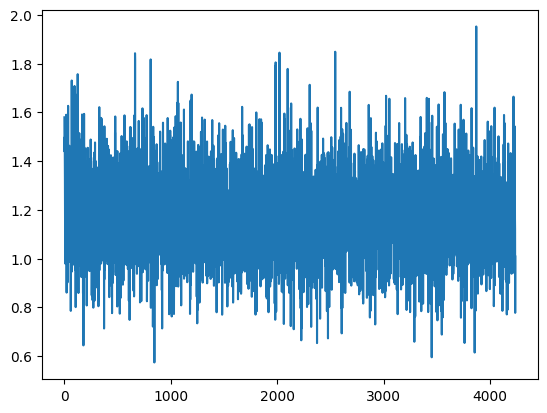

In [16]:
plt.plot(train_losses)

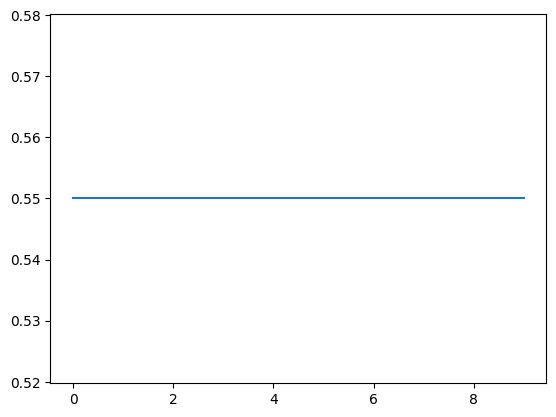

In [17]:
plt.plot(test_accuracy)

In [18]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [19]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 935/1696 (0.5513)
{'acc_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.5513, device='cuda:0'),
 'f1s': tensor(0.1777, device='cuda:0'),
 'f1s_detail': tensor([0.7108, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.5513, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'rocauc': tensor([0.5657, 0.5504, 0.4994, 0.5635], device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.3039, device='cuda:0')}


tensor([[935,   0,   0,   0],
        [344,   0,   0,   0],
        [160,   0,   0,   0],
        [257,   0,   0,   0]], device='cuda:0')

In [20]:
model_path = '../models_meld4/meld4_m18emo4_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [21]:
n_epoch = 10
n_epoch2 = 140
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_meld4/meld4_m18emo4_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                          | 0.0037735849056603774/140 [00:00<5:17:07, 135.92s/it]

Train Epoch: 11 [0/6799 (0%)]	Loss: 1.269004
Mem before-during-after: 33981952 3533459456 42107904


  0%|                            | 0.07735849056603773/140 [00:14<7:52:57, 202.81s/it]

Train Epoch: 11 [640/6799 (9%)]	Loss: 1.298093
Mem before-during-after: 42107904 3546045440 42107904


  0%|                            | 0.15471698113207547/140 [00:28<6:57:24, 179.08s/it]

Train Epoch: 11 [1280/6799 (19%)]	Loss: 1.189209
Mem before-during-after: 42107904 3545611264 42107904


  0%|                              | 0.230188679245283/140 [00:41<6:44:24, 173.61s/it]

Train Epoch: 11 [1920/6799 (28%)]	Loss: 1.025905
Mem before-during-after: 42107904 3544505344 42107904


  0%|                            | 0.30377358490566037/140 [00:55<7:43:49, 199.21s/it]

Train Epoch: 11 [2560/6799 (38%)]	Loss: 1.140249
Mem before-during-after: 42107904 3546045440 42107904


  0%|                             | 0.3792452830188679/140 [01:08<7:38:04, 196.85s/it]

Train Epoch: 11 [3200/6799 (47%)]	Loss: 1.202361
Mem before-during-after: 42107904 3525242368 43074560


  0%|                             | 0.4547169811320754/140 [01:22<7:40:42, 198.09s/it]

Train Epoch: 11 [3840/6799 (57%)]	Loss: 1.151837
Mem before-during-after: 42107904 3546775552 42107904


  0%|                              | 0.530188679245283/140 [01:36<7:48:49, 201.69s/it]

Train Epoch: 11 [4480/6799 (66%)]	Loss: 1.401876
Mem before-during-after: 42107904 3546045440 42107904


  0%|▏                            | 0.6056603773584905/140 [01:49<7:43:00, 199.29s/it]

Train Epoch: 11 [5120/6799 (75%)]	Loss: 1.555589
Mem before-during-after: 42107904 3546045440 42107904


  0%|▏                            | 0.6811320754716981/140 [02:03<7:45:36, 200.53s/it]

Train Epoch: 11 [5760/6799 (85%)]	Loss: 1.093574
Mem before-during-after: 42107904 3545824768 42107904


  1%|▏                            | 0.7566037735849056/140 [02:17<7:33:57, 195.61s/it]

Train Epoch: 11 [6400/6799 (94%)]	Loss: 1.438183
Mem before-during-after: 42107904 3545824768 42107904


  1%|▏                            | 0.9999999999999999/140 [02:45<3:58:25, 102.92s/it]


Test Epoch: 11	Accuracy: 935/1696 (55%)



  1%|▏                              | 1.00188679245283/140 [02:45<4:49:38, 125.03s/it]

Train Epoch: 12 [0/6799 (0%)]	Loss: 1.473120
Mem before-during-after: 42103808 3545611264 42107904


  1%|▏                            | 1.0792452830188723/140 [02:59<6:40:14, 172.86s/it]

Train Epoch: 12 [640/6799 (9%)]	Loss: 1.138692
Mem before-during-after: 42107904 3544505344 42107904


  1%|▏                            | 1.1547169811320843/140 [03:13<6:37:38, 171.83s/it]

Train Epoch: 12 [1280/6799 (19%)]	Loss: 1.210238
Mem before-during-after: 42107904 3546045440 42107904


  1%|▎                             | 1.228301886792466/140 [03:26<7:51:05, 203.69s/it]

Train Epoch: 12 [1920/6799 (28%)]	Loss: 0.819295
Mem before-during-after: 42107904 3545824768 42107904


  1%|▎                             | 1.303773584905678/140 [03:39<7:36:07, 197.32s/it]

Train Epoch: 12 [2560/6799 (38%)]	Loss: 1.044737
Mem before-during-after: 42107904 3546659840 43156480


  1%|▎                              | 1.37924528301889/140 [03:54<8:18:59, 215.98s/it]

Train Epoch: 12 [3200/6799 (47%)]	Loss: 1.513896
Mem before-during-after: 42107904 3544588288 42107904


  1%|▎                             | 1.454716981132102/140 [04:07<7:32:12, 195.84s/it]

Train Epoch: 12 [3840/6799 (57%)]	Loss: 1.135878
Mem before-during-after: 42107904 3524357632 42107904


  1%|▎                            | 1.5301886792453139/140 [04:21<7:31:14, 195.53s/it]

Train Epoch: 12 [4480/6799 (66%)]	Loss: 1.131459
Mem before-during-after: 42107904 3546873344 42107904


  1%|▎                            | 1.6056603773585258/140 [04:34<7:32:38, 196.24s/it]

Train Epoch: 12 [5120/6799 (75%)]	Loss: 1.196898
Mem before-during-after: 42107904 3545824768 42107904


  1%|▎                            | 1.6811320754717378/140 [04:48<7:31:06, 195.68s/it]

Train Epoch: 12 [5760/6799 (85%)]	Loss: 1.272667
Mem before-during-after: 42107904 3545824768 42107904


  1%|▍                              | 1.75849056603778/140 [05:02<6:46:45, 176.54s/it]

Train Epoch: 12 [6400/6799 (94%)]	Loss: 1.156727
Mem before-during-after: 42107904 3544505344 42107904


  1%|▍                             | 2.000000000000058/140 [05:30<3:51:15, 100.55s/it]


Test Epoch: 12	Accuracy: 935/1696 (55%)



  1%|▍                            | 2.0037735849057188/140 [05:31<4:30:18, 117.53s/it]

Train Epoch: 13 [0/6799 (0%)]	Loss: 1.145291
Mem before-during-after: 42103808 3545611264 42107904


  1%|▍                            | 2.0773584905661004/140 [05:44<7:31:04, 196.23s/it]

Train Epoch: 13 [640/6799 (9%)]	Loss: 1.342757
Mem before-during-after: 42107904 3546045440 42107904


  2%|▍                            | 2.1528301886793124/140 [05:58<7:37:33, 199.16s/it]

Train Epoch: 13 [1280/6799 (19%)]	Loss: 1.138131
Mem before-during-after: 42107904 3545726976 42107904


  2%|▍                            | 2.2283018867925244/140 [06:12<7:48:36, 204.08s/it]

Train Epoch: 13 [1920/6799 (28%)]	Loss: 1.137802
Mem before-during-after: 42107904 3524555776 42107904


  2%|▍                            | 2.3056603773585667/140 [06:26<6:28:19, 169.21s/it]

Train Epoch: 13 [2560/6799 (38%)]	Loss: 0.928692
Mem before-during-after: 42107904 3545824768 42107904


  2%|▍                            | 2.3792452830189483/140 [06:39<7:32:37, 197.33s/it]

Train Epoch: 13 [3200/6799 (47%)]	Loss: 1.110280
Mem before-during-after: 42107904 3546004992 42107904


  2%|▌                            | 2.4547169811321603/140 [06:53<7:50:19, 205.17s/it]

Train Epoch: 13 [3840/6799 (57%)]	Loss: 1.121659
Mem before-during-after: 42107904 3545618944 42107904


  2%|▌                            | 2.5301886792453723/140 [07:07<7:36:24, 199.21s/it]

Train Epoch: 13 [4480/6799 (66%)]	Loss: 1.019562
Mem before-during-after: 42107904 3546004992 42107904


  2%|▌                            | 2.6056603773585842/140 [07:20<7:35:20, 198.84s/it]

Train Epoch: 13 [5120/6799 (75%)]	Loss: 1.121827
Mem before-during-after: 42107904 3545824768 42107904


  2%|▌                             | 2.681132075471796/140 [07:34<7:42:29, 202.08s/it]

Train Epoch: 13 [5760/6799 (85%)]	Loss: 1.184554
Mem before-during-after: 42107904 3544505344 42107904


  2%|▌                            | 2.7584905660378385/140 [07:48<6:43:14, 176.29s/it]

Train Epoch: 13 [6400/6799 (94%)]	Loss: 1.083529
Mem before-during-after: 42107904 3544505344 42107904


  2%|▋                             | 3.000000000000117/140 [08:16<3:51:41, 101.47s/it]


Test Epoch: 13	Accuracy: 935/1696 (55%)



  2%|▋                             | 3.001886792452947/140 [08:17<4:41:56, 123.48s/it]

Train Epoch: 14 [0/6799 (0%)]	Loss: 1.148859
Mem before-during-after: 42103808 3545611264 42107904


  2%|▋                             | 3.077358490566159/140 [08:30<7:34:48, 199.30s/it]

Train Epoch: 14 [640/6799 (9%)]	Loss: 1.061252
Mem before-during-after: 42107904 3546045440 42107904


  2%|▋                             | 3.152830188679371/140 [08:44<7:39:59, 201.68s/it]

Train Epoch: 14 [1280/6799 (19%)]	Loss: 1.034613
Mem before-during-after: 42107904 3545618944 42107904


  2%|▋                             | 3.228301886792583/140 [08:57<7:25:06, 195.26s/it]

Train Epoch: 14 [1920/6799 (28%)]	Loss: 0.943182
Mem before-during-after: 42107904 3525520896 42107904


  2%|▋                             | 3.303773584905795/140 [09:11<7:38:45, 201.37s/it]

Train Epoch: 14 [2560/6799 (38%)]	Loss: 1.439341
Mem before-during-after: 42107904 3544636416 44136448


  2%|▋                             | 3.379245283019007/140 [09:25<7:47:07, 205.15s/it]

Train Epoch: 14 [3200/6799 (47%)]	Loss: 1.263389
Mem before-during-after: 42107904 3546045440 42107904


  2%|▋                             | 3.454716981132219/140 [09:38<7:38:31, 201.48s/it]

Train Epoch: 14 [3840/6799 (57%)]	Loss: 1.119329
Mem before-during-after: 42107904 3544505344 42107904


  3%|▊                             | 3.530188679245431/140 [09:52<7:30:38, 198.13s/it]

Train Epoch: 14 [4480/6799 (66%)]	Loss: 1.057026
Mem before-during-after: 42107904 3546045440 42107904


  3%|▊                             | 3.605660377358643/140 [10:05<7:49:39, 206.60s/it]

Train Epoch: 14 [5120/6799 (75%)]	Loss: 1.096449
Mem before-during-after: 42107904 3547094016 43156480


  3%|▊                             | 3.681132075471855/140 [10:19<7:28:22, 197.35s/it]

Train Epoch: 14 [5760/6799 (85%)]	Loss: 1.189129
Mem before-during-after: 42107904 3546045440 42107904


  3%|▊                             | 3.756603773585067/140 [10:33<7:48:41, 206.41s/it]

Train Epoch: 14 [6400/6799 (94%)]	Loss: 1.032140
Mem before-during-after: 42107904 3546045440 42107904


  3%|▊                             | 4.000000000000175/140 [11:01<3:57:22, 104.73s/it]


Test Epoch: 14	Accuracy: 935/1696 (55%)



  3%|▊                             | 4.001886792453005/140 [11:02<4:43:48, 125.21s/it]

Train Epoch: 15 [0/6799 (0%)]	Loss: 0.920562
Mem before-during-after: 42103808 3545611264 42107904


  3%|▊                             | 4.077358490566217/140 [11:15<7:25:24, 196.62s/it]

Train Epoch: 15 [640/6799 (9%)]	Loss: 0.886282
Mem before-during-after: 42107904 3545618944 42107904


  3%|▉                             | 4.152830188679429/140 [11:29<7:31:21, 199.35s/it]

Train Epoch: 15 [1280/6799 (19%)]	Loss: 1.414137
Mem before-during-after: 42107904 3546045440 42107904


  3%|▉                             | 4.228301886792641/140 [11:43<7:39:41, 203.15s/it]

Train Epoch: 15 [1920/6799 (28%)]	Loss: 1.532111
Mem before-during-after: 42107904 3545651712 42107904


  3%|▉                             | 4.303773584905853/140 [11:56<7:33:17, 200.43s/it]

Train Epoch: 15 [2560/6799 (38%)]	Loss: 1.191628
Mem before-during-after: 42107904 3545726976 42107904


  3%|▉                             | 4.379245283019065/140 [12:10<7:20:34, 194.92s/it]

Train Epoch: 15 [3200/6799 (47%)]	Loss: 0.836564
Mem before-during-after: 42107904 3545824768 42107904


  3%|▉                             | 4.454716981132277/140 [12:24<7:20:51, 195.15s/it]

Train Epoch: 15 [3840/6799 (57%)]	Loss: 1.067109
Mem before-during-after: 42107904 3546102784 42107904


  3%|▉                             | 4.530188679245489/140 [12:37<7:15:58, 193.10s/it]

Train Epoch: 15 [4480/6799 (66%)]	Loss: 1.185880
Mem before-during-after: 42107904 3546004992 42107904


  3%|▉                             | 4.605660377358701/140 [12:50<7:25:46, 197.55s/it]

Train Epoch: 15 [5120/6799 (75%)]	Loss: 0.887475
Mem before-during-after: 42107904 3545824768 42107904


  3%|█                             | 4.681132075471913/140 [13:04<7:29:36, 199.36s/it]

Train Epoch: 15 [5760/6799 (85%)]	Loss: 1.048376
Mem before-during-after: 42107904 3545824768 42107904


  3%|█                             | 4.758490566037955/140 [13:18<6:23:50, 170.29s/it]

Train Epoch: 15 [6400/6799 (94%)]	Loss: 1.344684
Mem before-during-after: 42107904 3545726976 42107904


  4%|█                              | 5.000000000000234/140 [13:46<3:43:16, 99.24s/it]


Test Epoch: 15	Accuracy: 935/1696 (55%)



  4%|█                             | 5.003773584905894/140 [13:46<4:20:26, 115.76s/it]

Train Epoch: 16 [0/6799 (0%)]	Loss: 1.208082
Mem before-during-after: 42103808 3545611264 42107904


  4%|█                             | 5.077358490566276/140 [14:00<7:23:56, 197.42s/it]

Train Epoch: 16 [640/6799 (9%)]	Loss: 1.200823
Mem before-during-after: 42107904 3544562688 42107904


  4%|█                             | 5.152830188679488/140 [14:13<8:07:34, 216.94s/it]

Train Epoch: 16 [1280/6799 (19%)]	Loss: 1.170415
Mem before-during-after: 42157056 3545553920 43156480


  4%|█▏                             | 5.23018867924553/140 [14:27<6:23:25, 170.70s/it]

Train Epoch: 16 [1920/6799 (28%)]	Loss: 1.220452
Mem before-during-after: 42107904 3544505344 42107904


  4%|█▏                            | 5.305660377358742/140 [14:40<6:33:39, 175.35s/it]

Train Epoch: 16 [2560/6799 (38%)]	Loss: 1.076194
Mem before-during-after: 42107904 3544505344 42107904


  4%|█▏                            | 5.379245283019124/140 [14:54<7:21:06, 196.60s/it]

Train Epoch: 16 [3200/6799 (47%)]	Loss: 1.309386
Mem before-during-after: 42107904 3545824768 42107904


  4%|█▏                            | 5.454716981132336/140 [15:07<7:13:41, 193.40s/it]

Train Epoch: 16 [3840/6799 (57%)]	Loss: 1.110887
Mem before-during-after: 43156480 3547708416 42107904


  4%|█▏                            | 5.530188679245548/140 [15:21<7:49:57, 209.69s/it]

Train Epoch: 16 [4480/6799 (66%)]	Loss: 1.504965
Mem before-during-after: 42107904 3546004992 42107904


  4%|█▏                             | 5.60754716981159/140 [15:34<6:17:42, 168.63s/it]

Train Epoch: 16 [5120/6799 (75%)]	Loss: 1.222839
Mem before-during-after: 42107904 3545824768 42107904


  4%|█▏                            | 5.683018867924802/140 [15:48<6:35:13, 176.55s/it]

Train Epoch: 16 [5760/6799 (85%)]	Loss: 1.249369
Mem before-during-after: 42107904 3544588288 42107904


  4%|█▏                            | 5.756603773585184/140 [16:01<7:47:22, 208.90s/it]

Train Epoch: 16 [6400/6799 (94%)]	Loss: 1.119220
Mem before-during-after: 42992640 3545709056 42992640


  4%|█▎                             | 6.000000000000292/140 [16:30<3:38:48, 97.98s/it]


Test Epoch: 16	Accuracy: 935/1696 (55%)



  4%|█▏                           | 6.0018867924531225/140 [16:30<4:31:34, 121.60s/it]

Train Epoch: 17 [0/6799 (0%)]	Loss: 1.091160
Mem before-during-after: 42103808 3545611264 42107904


  4%|█▎                           | 6.0773584905663345/140 [16:44<7:39:12, 205.73s/it]

Train Epoch: 17 [640/6799 (9%)]	Loss: 1.313203
Mem before-during-after: 42107904 3545734656 42107904


  4%|█▎                           | 6.1528301886795465/140 [16:57<7:47:12, 209.44s/it]

Train Epoch: 17 [1280/6799 (19%)]	Loss: 1.311478
Mem before-during-after: 42107904 3546873344 42107904


  4%|█▎                            | 6.228301886792758/140 [17:11<7:16:28, 195.77s/it]

Train Epoch: 17 [1920/6799 (28%)]	Loss: 1.239869
Mem before-during-after: 42107904 3546045440 42107904


  5%|█▍                             | 6.30377358490597/140 [17:24<7:10:55, 193.39s/it]

Train Epoch: 17 [2560/6799 (38%)]	Loss: 0.974799
Mem before-during-after: 42107904 3546004992 42107904


  5%|█▎                            | 6.379245283019182/140 [17:38<7:10:55, 193.50s/it]

Train Epoch: 17 [3200/6799 (47%)]	Loss: 1.106298
Mem before-during-after: 42107904 3547094016 42107904


  5%|█▍                            | 6.454716981132394/140 [17:52<7:12:51, 194.48s/it]

Train Epoch: 17 [3840/6799 (57%)]	Loss: 0.957177
Mem before-during-after: 42107904 3546045440 42107904


  5%|█▍                            | 6.532075471698437/140 [18:05<6:18:42, 170.25s/it]

Train Epoch: 17 [4480/6799 (66%)]	Loss: 1.101598
Mem before-during-after: 42107904 3545824768 42107904


  5%|█▍                            | 6.605660377358818/140 [18:18<7:17:10, 196.64s/it]

Train Epoch: 17 [5120/6799 (75%)]	Loss: 1.106844
Mem before-during-after: 42107904 3545824768 42107904


  5%|█▍                             | 6.68113207547203/140 [18:32<7:20:09, 198.10s/it]

Train Epoch: 17 [5760/6799 (85%)]	Loss: 1.223115
Mem before-during-after: 42107904 3545726976 42107904


  5%|█▍                            | 6.756603773585242/140 [18:46<7:11:17, 194.21s/it]

Train Epoch: 17 [6400/6799 (94%)]	Loss: 1.127362
Mem before-during-after: 42107904 3545824768 42107904


  5%|█▌                             | 7.000000000000351/140 [19:14<3:37:27, 98.10s/it]


Test Epoch: 17	Accuracy: 935/1696 (55%)



  5%|█▌                            | 7.003773584906011/140 [19:14<4:16:32, 115.74s/it]

Train Epoch: 18 [0/6799 (0%)]	Loss: 1.374352
Mem before-during-after: 42103808 3545611264 42107904


  5%|█▌                            | 7.077358490566393/140 [19:27<7:17:19, 197.40s/it]

Train Epoch: 18 [640/6799 (9%)]	Loss: 1.399292
Mem before-during-after: 42107904 3545726976 42107904


  5%|█▌                            | 7.154716981132435/140 [19:41<6:24:33, 173.69s/it]

Train Epoch: 18 [1280/6799 (19%)]	Loss: 1.405945
Mem before-during-after: 42107904 3544505344 42107904


  5%|█▌                            | 7.228301886792817/140 [19:54<7:12:23, 195.40s/it]

Train Epoch: 18 [1920/6799 (28%)]	Loss: 1.265717
Mem before-during-after: 42107904 3545726976 42107904


  5%|█▌                            | 7.303773584906029/140 [20:08<7:21:05, 199.44s/it]

Train Epoch: 18 [2560/6799 (38%)]	Loss: 1.032579
Mem before-during-after: 42107904 3546045440 42107904


  5%|█▌                            | 7.381132075472071/140 [20:22<6:32:53, 177.75s/it]

Train Epoch: 18 [3200/6799 (47%)]	Loss: 0.841858
Mem before-during-after: 42107904 3544505344 42107904


  5%|█▌                            | 7.454716981132453/140 [20:35<7:27:40, 202.65s/it]

Train Epoch: 18 [3840/6799 (57%)]	Loss: 0.967533
Mem before-during-after: 42107904 3545651712 42107904


  5%|█▌                            | 7.530188679245665/140 [20:48<7:10:57, 195.20s/it]

Train Epoch: 18 [4480/6799 (66%)]	Loss: 1.219644
Mem before-during-after: 42107904 3545726976 42107904


  5%|█▋                            | 7.607547169811707/140 [21:02<6:17:13, 170.96s/it]

Train Epoch: 18 [5120/6799 (75%)]	Loss: 1.283158
Mem before-during-after: 42107904 3545726976 42107904


  5%|█▋                            | 7.681132075472089/140 [21:15<7:05:57, 193.15s/it]

Train Epoch: 18 [5760/6799 (85%)]	Loss: 1.022525
Mem before-during-after: 42107904 3546004992 42107904


  6%|█▋                            | 7.756603773585301/140 [21:29<7:32:35, 205.35s/it]

Train Epoch: 18 [6400/6799 (94%)]	Loss: 1.122841
Mem before-during-after: 42107904 3545824768 42107904


  6%|█▊                             | 8.000000000000409/140 [21:57<3:38:15, 99.21s/it]


Test Epoch: 18	Accuracy: 935/1696 (55%)



  6%|█▋                            | 8.001886792453238/140 [21:57<4:31:10, 123.27s/it]

Train Epoch: 19 [0/6799 (0%)]	Loss: 1.137677
Mem before-during-after: 42103808 3545611264 42107904


  6%|█▋                            | 8.079245283019244/140 [22:11<6:10:57, 168.72s/it]

Train Epoch: 19 [640/6799 (9%)]	Loss: 0.889670
Mem before-during-after: 42107904 3546045440 42107904


  6%|█▊                             | 8.15283018867959/140 [22:24<7:19:26, 199.98s/it]

Train Epoch: 19 [1280/6799 (19%)]	Loss: 0.904116
Mem before-during-after: 42107904 3545636864 42107904


  6%|█▊                            | 8.228301886792767/140 [22:38<7:16:30, 198.76s/it]

Train Epoch: 19 [1920/6799 (28%)]	Loss: 1.340222
Mem before-during-after: 42107904 3546045440 42107904


  6%|█▊                            | 8.303773584905944/140 [22:51<7:14:10, 197.81s/it]

Train Epoch: 19 [2560/6799 (38%)]	Loss: 1.032989
Mem before-during-after: 42107904 3545726976 42107904


  6%|█▊                             | 8.37924528301912/140 [23:05<7:17:48, 199.58s/it]

Train Epoch: 19 [3200/6799 (47%)]	Loss: 0.951249
Mem before-during-after: 42107904 3544505344 42107904


  6%|█▊                            | 8.454716981132297/140 [23:18<7:16:14, 198.98s/it]

Train Epoch: 19 [3840/6799 (57%)]	Loss: 1.033483
Mem before-during-after: 42107904 3545651712 42107904


  6%|█▊                            | 8.532075471698302/140 [23:32<6:17:47, 172.42s/it]

Train Epoch: 19 [4480/6799 (66%)]	Loss: 1.270436
Mem before-during-after: 43156480 3525242368 42107904


  6%|█▊                            | 8.607547169811479/140 [23:46<6:18:58, 173.06s/it]

Train Epoch: 19 [5120/6799 (75%)]	Loss: 1.067913
Mem before-during-after: 42107904 3545618944 42107904


  6%|█▊                            | 8.683018867924655/140 [23:59<6:09:21, 168.76s/it]

Train Epoch: 19 [5760/6799 (85%)]	Loss: 1.102098
Mem before-during-after: 43156480 3546667520 42107904


  6%|█▉                            | 8.758490566037832/140 [24:13<6:27:16, 177.05s/it]

Train Epoch: 19 [6400/6799 (94%)]	Loss: 1.041356
Mem before-during-after: 42107904 3544505344 42107904


  6%|█▉                            | 8.999999999999996/140 [24:41<3:42:23, 101.86s/it]


Test Epoch: 19	Accuracy: 935/1696 (55%)



  6%|█▉                            | 9.001886792452826/140 [24:41<4:30:56, 124.09s/it]

Train Epoch: 20 [0/6799 (0%)]	Loss: 1.246259
Mem before-during-after: 42103808 3534810112 42107904


  6%|█▉                            | 9.079245283018832/140 [24:55<6:22:20, 175.22s/it]

Train Epoch: 20 [640/6799 (9%)]	Loss: 1.247985
Mem before-during-after: 42107904 3544588288 42107904


  7%|█▉                            | 9.152830188679179/140 [25:08<7:08:54, 196.67s/it]

Train Epoch: 20 [1280/6799 (19%)]	Loss: 1.155516
Mem before-during-after: 42107904 3546045440 42107904


  7%|█▉                            | 9.228301886792355/140 [25:22<7:04:11, 194.63s/it]

Train Epoch: 20 [1920/6799 (28%)]	Loss: 1.289383
Mem before-during-after: 42107904 3545824768 42107904


  7%|█▉                            | 9.305660377358361/140 [25:36<6:12:44, 171.12s/it]

Train Epoch: 20 [2560/6799 (38%)]	Loss: 0.834489
Mem before-during-after: 42107904 3546045440 42107904


  7%|██                            | 9.379245283018708/140 [25:49<7:04:27, 194.98s/it]

Train Epoch: 20 [3200/6799 (47%)]	Loss: 1.018998
Mem before-during-after: 42107904 3546045440 42107904


  7%|██                            | 9.454716981131885/140 [26:03<7:40:34, 211.69s/it]

Train Epoch: 20 [3840/6799 (57%)]	Loss: 0.973241
Mem before-during-after: 42107904 3544562688 42107904


  7%|██                             | 9.53207547169789/140 [26:17<6:06:14, 168.43s/it]

Train Epoch: 20 [4480/6799 (66%)]	Loss: 1.325501
Mem before-during-after: 43156480 3546667520 42107904


  7%|██                            | 9.607547169811067/140 [26:30<6:17:12, 173.57s/it]

Train Epoch: 20 [5120/6799 (75%)]	Loss: 1.124622
Mem before-during-after: 42107904 3544505344 42107904


  7%|██                            | 9.681132075471414/140 [26:44<7:26:59, 205.80s/it]

Train Epoch: 20 [5760/6799 (85%)]	Loss: 1.312183
Mem before-during-after: 42107904 3546045440 42107904


  7%|██▏                            | 9.75660377358459/140 [26:57<7:51:12, 217.08s/it]

Train Epoch: 20 [6400/6799 (94%)]	Loss: 1.161478
Mem before-during-after: 42107904 3545611264 42107904


  7%|██▏                            | 9.999999999999584/140 [27:25<3:35:55, 99.66s/it]


Test Epoch: 20	Accuracy: 935/1696 (55%)



  7%|██                           | 10.001886792452414/140 [27:25<4:25:49, 122.69s/it]

Train Epoch: 21 [0/6799 (0%)]	Loss: 0.908807
Mem before-during-after: 42103808 3545611264 42107904


  7%|██▏                           | 10.07924528301842/140 [27:39<6:06:05, 169.07s/it]

Train Epoch: 21 [640/6799 (9%)]	Loss: 0.892848
Mem before-during-after: 42107904 3546659840 42107904


  7%|██                           | 10.152830188678767/140 [27:52<7:03:17, 195.60s/it]

Train Epoch: 21 [1280/6799 (19%)]	Loss: 1.429025
Mem before-during-after: 42107904 3545611264 42107904


  7%|██                           | 10.230188679244772/140 [28:06<6:06:16, 169.35s/it]

Train Epoch: 21 [1920/6799 (28%)]	Loss: 1.017362
Mem before-during-after: 43025408 3546659840 43156480


  7%|██▏                          | 10.305660377357949/140 [28:19<6:00:02, 166.56s/it]

Train Epoch: 21 [2560/6799 (38%)]	Loss: 1.402163
Mem before-during-after: 42107904 3546045440 42107904


  7%|██▏                          | 10.379245283018296/140 [28:33<7:21:47, 204.50s/it]

Train Epoch: 21 [3200/6799 (47%)]	Loss: 1.278490
Mem before-during-after: 42107904 3546873344 42107904


  7%|██▏                          | 10.456603773584302/140 [28:47<6:04:22, 168.77s/it]

Train Epoch: 21 [3840/6799 (57%)]	Loss: 1.284434
Mem before-during-after: 42107904 3545824768 42107904


  8%|██▏                          | 10.530188679244649/140 [29:00<7:14:35, 201.40s/it]

Train Epoch: 21 [4480/6799 (66%)]	Loss: 0.935192
Mem before-during-after: 42107904 3545726976 42107904


  8%|██▏                          | 10.605660377357825/140 [29:14<7:18:55, 203.53s/it]

Train Epoch: 21 [5120/6799 (75%)]	Loss: 1.409387
Mem before-during-after: 42107904 3544505344 42107904


  8%|██▏                          | 10.681132075471002/140 [29:28<7:30:16, 208.92s/it]

Train Epoch: 21 [5760/6799 (85%)]	Loss: 1.351983
Mem before-during-after: 42107904 3545611264 42107904


  8%|██▏                          | 10.758490566037008/140 [29:41<6:11:47, 172.61s/it]

Train Epoch: 21 [6400/6799 (94%)]	Loss: 1.284024
Mem before-during-after: 42107904 3544505344 42107904


  8%|██▎                           | 10.999999999999172/140 [30:09<3:34:43, 99.88s/it]


Test Epoch: 21	Accuracy: 935/1696 (55%)



  8%|██▎                          | 11.001886792452002/140 [30:09<4:19:55, 120.90s/it]

Train Epoch: 22 [0/6799 (0%)]	Loss: 1.127472
Mem before-during-after: 42103808 3545611264 42107904


  8%|██▎                          | 11.077358490565178/140 [30:23<7:15:32, 202.70s/it]

Train Epoch: 22 [640/6799 (9%)]	Loss: 1.401322
Mem before-during-after: 42107904 3544505344 42107904


  8%|██▎                          | 11.152830188678355/140 [30:36<6:58:43, 194.99s/it]

Train Epoch: 22 [1280/6799 (19%)]	Loss: 1.175958
Mem before-during-after: 42107904 3546045440 42107904


  8%|██▎                          | 11.228301886791531/140 [30:50<7:03:04, 197.13s/it]

Train Epoch: 22 [1920/6799 (28%)]	Loss: 1.108510
Mem before-during-after: 42107904 3546045440 42107904


  8%|██▎                          | 11.303773584904707/140 [31:04<7:12:35, 201.68s/it]

Train Epoch: 22 [2560/6799 (38%)]	Loss: 1.325639
Mem before-during-after: 42107904 3545618944 42107904


  8%|██▎                          | 11.379245283017884/140 [31:17<7:10:32, 200.84s/it]

Train Epoch: 22 [3200/6799 (47%)]	Loss: 1.345486
Mem before-during-after: 42107904 3524850688 42107904


  8%|██▍                           | 11.45660377358389/140 [31:31<6:21:36, 178.12s/it]

Train Epoch: 22 [3840/6799 (57%)]	Loss: 1.222853
Mem before-during-after: 42107904 3544505344 42107904


  8%|██▍                          | 11.530188679244237/140 [31:44<7:04:45, 198.37s/it]

Train Epoch: 22 [4480/6799 (66%)]	Loss: 1.199025
Mem before-during-after: 42107904 3546659840 42107904


  8%|██▍                          | 11.605660377357413/140 [31:58<6:58:56, 195.78s/it]

Train Epoch: 22 [5120/6799 (75%)]	Loss: 1.171767
Mem before-during-after: 42107904 3546045440 42107904


  8%|██▍                          | 11.683018867923419/140 [32:12<6:04:54, 170.63s/it]

Train Epoch: 22 [5760/6799 (85%)]	Loss: 1.061213
Mem before-during-after: 42107904 3545824768 42107904


  8%|██▍                          | 11.756603773583766/140 [32:25<6:57:11, 195.19s/it]

Train Epoch: 22 [6400/6799 (94%)]	Loss: 1.365426
Mem before-during-after: 42107904 3545726976 42107904


  9%|██▌                           | 11.99999999999876/140 [32:53<3:39:44, 103.01s/it]


Test Epoch: 22	Accuracy: 935/1696 (55%)



  9%|██▍                          | 12.003773584904419/140 [32:54<4:13:05, 118.64s/it]

Train Epoch: 23 [0/6799 (0%)]	Loss: 1.019215
Mem before-during-after: 42103808 3545611264 42107904


  9%|██▌                          | 12.079245283017595/140 [33:07<6:19:49, 178.15s/it]

Train Epoch: 23 [640/6799 (9%)]	Loss: 1.104738
Mem before-during-after: 42107904 3544505344 42107904


  9%|██▌                          | 12.154716981130772/140 [33:21<6:08:21, 172.87s/it]

Train Epoch: 23 [1280/6799 (19%)]	Loss: 1.212083
Mem before-during-after: 42107904 3546614784 43156480


  9%|██▌                          | 12.228301886791119/140 [33:34<7:01:07, 197.76s/it]

Train Epoch: 23 [1920/6799 (28%)]	Loss: 1.271424
Mem before-during-after: 42107904 3545824768 42107904


  9%|██▌                          | 12.303773584904295/140 [33:48<6:55:41, 195.32s/it]

Train Epoch: 23 [2560/6799 (38%)]	Loss: 1.338484
Mem before-during-after: 42107904 3546004992 42107904


  9%|██▌                          | 12.379245283017472/140 [34:01<6:59:49, 197.37s/it]

Train Epoch: 23 [3200/6799 (47%)]	Loss: 1.236506
Mem before-during-after: 42107904 3545726976 42107904


  9%|██▌                          | 12.454716981130648/140 [34:15<7:03:09, 199.06s/it]

Train Epoch: 23 [3840/6799 (57%)]	Loss: 1.144592
Mem before-during-after: 42107904 3545824768 42107904


  9%|██▌                          | 12.530188679243825/140 [34:28<7:13:44, 204.16s/it]

Train Epoch: 23 [4480/6799 (66%)]	Loss: 1.155839
Mem before-during-after: 42107904 3546873344 42107904


  9%|██▋                           | 12.60754716980983/140 [34:42<6:07:42, 173.19s/it]

Train Epoch: 23 [5120/6799 (75%)]	Loss: 0.874620
Mem before-during-after: 42107904 3545726976 42107904


  9%|██▋                          | 12.683018867923007/140 [34:56<6:05:13, 172.11s/it]

Train Epoch: 23 [5760/6799 (85%)]	Loss: 1.133570
Mem before-during-after: 42107904 3544505344 42107904


  9%|██▋                          | 12.756603773583354/140 [35:09<6:57:50, 197.02s/it]

Train Epoch: 23 [6400/6799 (94%)]	Loss: 1.075525
Mem before-during-after: 42107904 3547708416 42107904


  9%|██▋                          | 12.999999999998348/140 [35:38<3:33:56, 101.08s/it]


Test Epoch: 23	Accuracy: 937/1696 (55%)

saved model: ../models_meld4/meld4_m18emo4_best_23epoch.pt


  9%|██▋                          | 13.001886792451177/140 [35:38<4:20:08, 122.91s/it]

Train Epoch: 24 [0/6799 (0%)]	Loss: 1.087592
Mem before-during-after: 42103808 3545611264 42107904


  9%|██▋                          | 13.077358490564354/140 [35:51<6:54:17, 195.84s/it]

Train Epoch: 24 [640/6799 (9%)]	Loss: 0.938252
Mem before-during-after: 42107904 3545726976 42107904


  9%|██▊                           | 13.15471698113036/140 [36:05<6:06:54, 173.56s/it]

Train Epoch: 24 [1280/6799 (19%)]	Loss: 1.068761
Mem before-during-after: 42107904 3545618944 42107904


  9%|██▋                          | 13.228301886790707/140 [36:19<7:31:37, 213.75s/it]

Train Epoch: 24 [1920/6799 (28%)]	Loss: 1.040996
Mem before-during-after: 42107904 3545611264 42107904


 10%|██▊                          | 13.305660377356713/140 [36:33<6:14:26, 177.33s/it]

Train Epoch: 24 [2560/6799 (38%)]	Loss: 1.272951
Mem before-during-after: 43156480 3545656320 42107904


 10%|██▊                           | 13.37924528301706/140 [36:46<6:58:14, 198.19s/it]

Train Epoch: 24 [3200/6799 (47%)]	Loss: 1.302899
Mem before-during-after: 42107904 3545726976 42107904


 10%|██▊                          | 13.454716981130236/140 [36:59<6:50:16, 194.53s/it]

Train Epoch: 24 [3840/6799 (57%)]	Loss: 0.852647
Mem before-during-after: 42664960 3545288704 42664960


 10%|██▊                          | 13.532075471696242/140 [37:13<5:56:17, 169.04s/it]

Train Epoch: 24 [4480/6799 (66%)]	Loss: 0.941060
Mem before-during-after: 42140672 3545858048 42140672


 10%|██▊                          | 13.607547169809418/140 [37:26<6:10:43, 175.99s/it]

Train Epoch: 24 [5120/6799 (75%)]	Loss: 1.151743
Mem before-during-after: 42107904 3544719360 42140672


 10%|██▊                          | 13.681132075469765/140 [37:40<7:11:48, 205.10s/it]

Train Epoch: 24 [5760/6799 (85%)]	Loss: 0.839385
Mem before-during-after: 42632192 3544112128 42632192


 10%|██▊                          | 13.758490566035771/140 [37:53<5:54:39, 168.57s/it]

Train Epoch: 24 [6400/6799 (94%)]	Loss: 1.159010
Mem before-during-after: 42140672 3547257856 43001856


 10%|██▉                           | 13.999999999997936/140 [38:21<3:27:36, 98.87s/it]


Test Epoch: 24	Accuracy: 935/1696 (55%)



 10%|██▉                          | 14.003773584903595/140 [38:22<4:05:11, 116.76s/it]

Train Epoch: 25 [0/6799 (0%)]	Loss: 1.222586
Mem before-during-after: 42103808 3543735296 43001856


 10%|██▉                          | 14.079245283016771/140 [38:35<5:58:51, 170.99s/it]

Train Epoch: 25 [640/6799 (9%)]	Loss: 1.341693
Mem before-during-after: 43156480 3547839488 42664960


 10%|██▉                          | 14.152830188677118/140 [38:49<6:45:59, 193.56s/it]

Train Epoch: 25 [1280/6799 (19%)]	Loss: 1.196401
Mem before-during-after: 42632192 3546266624 42632192


 10%|██▉                          | 14.228301886790295/140 [39:03<6:46:01, 193.69s/it]

Train Epoch: 25 [1920/6799 (28%)]	Loss: 1.281884
Mem before-during-after: 42107904 3546045440 42107904


 10%|██▉                          | 14.303773584903471/140 [39:16<6:44:35, 193.13s/it]

Train Epoch: 25 [2560/6799 (38%)]	Loss: 1.119240
Mem before-during-after: 42107904 3546004992 42107904


 10%|██▉                          | 14.381132075469477/140 [39:30<6:26:03, 184.40s/it]

Train Epoch: 25 [3200/6799 (47%)]	Loss: 1.263358
Mem before-during-after: 42107904 3545611264 42107904


 10%|██▉                          | 14.456603773582653/140 [39:44<5:59:34, 171.85s/it]

Train Epoch: 25 [3840/6799 (57%)]	Loss: 1.313794
Mem before-during-after: 42107904 3545824768 42107904


 10%|███▎                            | 14.530188679243/140 [39:57<7:22:29, 211.60s/it]

Train Epoch: 25 [4480/6799 (66%)]	Loss: 1.127043
Mem before-during-after: 42107904 3544505344 42107904


 10%|███                          | 14.605660377356177/140 [40:11<6:57:36, 199.82s/it]

Train Epoch: 25 [5120/6799 (75%)]	Loss: 1.414392
Mem before-during-after: 42107904 3546045440 42107904


 10%|███                          | 14.681132075469353/140 [40:24<6:51:31, 197.03s/it]

Train Epoch: 25 [5760/6799 (85%)]	Loss: 1.161156
Mem before-during-after: 42107904 3545824768 42107904


 11%|███▏                          | 14.75849056603536/140 [40:38<6:05:17, 175.00s/it]

Train Epoch: 25 [6400/6799 (94%)]	Loss: 1.183440
Mem before-during-after: 42107904 3544505344 42107904


 11%|███                          | 14.999999999997524/140 [41:06<3:29:47, 100.70s/it]


Test Epoch: 25	Accuracy: 935/1696 (55%)



 11%|███                          | 15.001886792450353/140 [41:06<4:16:50, 123.29s/it]

Train Epoch: 26 [0/6799 (0%)]	Loss: 1.151202
Mem before-during-after: 42103808 3545611264 42107904


 11%|███▏                          | 15.07735849056353/140 [41:20<6:47:20, 195.65s/it]

Train Epoch: 26 [640/6799 (9%)]	Loss: 1.008348
Mem before-during-after: 42107904 3545726976 42107904


 11%|███▏                         | 15.154716981129535/140 [41:34<6:03:44, 174.81s/it]

Train Epoch: 26 [1280/6799 (19%)]	Loss: 1.326892
Mem before-during-after: 42107904 3546045440 42107904


 11%|███▏                         | 15.228301886789883/140 [41:47<6:46:18, 195.39s/it]

Train Epoch: 26 [1920/6799 (28%)]	Loss: 1.239482
Mem before-during-after: 42107904 3545824768 42107904


 11%|███▏                         | 15.303773584903059/140 [42:00<6:41:43, 193.30s/it]

Train Epoch: 26 [2560/6799 (38%)]	Loss: 1.454401
Mem before-during-after: 42107904 3546004992 42107904


 11%|███▏                         | 15.379245283016235/140 [42:14<6:50:51, 197.81s/it]

Train Epoch: 26 [3200/6799 (47%)]	Loss: 0.991627
Mem before-during-after: 42107904 3545726976 42107904


 11%|███▏                         | 15.456603773582241/140 [42:27<6:02:42, 174.74s/it]

Train Epoch: 26 [3840/6799 (57%)]	Loss: 1.116847
Mem before-during-after: 42107904 3544562688 42107904


 11%|███▏                         | 15.530188679242588/140 [42:41<6:51:15, 198.24s/it]

Train Epoch: 26 [4480/6799 (66%)]	Loss: 1.466691
Mem before-during-after: 42107904 3546045440 42107904


 11%|███▏                         | 15.605660377355765/140 [42:54<6:43:36, 194.67s/it]

Train Epoch: 26 [5120/6799 (75%)]	Loss: 1.436903
Mem before-during-after: 42107904 3546045440 42107904


 11%|███▎                          | 15.68301886792177/140 [43:08<5:56:41, 172.15s/it]

Train Epoch: 26 [5760/6799 (85%)]	Loss: 0.870185
Mem before-during-after: 42107904 3546659840 43156480


 11%|███▎                         | 15.756603773582118/140 [43:22<7:03:59, 204.75s/it]

Train Epoch: 26 [6400/6799 (94%)]	Loss: 1.341814
Mem before-during-after: 42107904 3545618944 42107904


 11%|███▎                         | 15.999999999997112/140 [43:50<3:31:43, 102.45s/it]


Test Epoch: 26	Accuracy: 935/1696 (55%)



 11%|███▍                          | 16.00188679244994/140 [43:50<4:13:53, 122.85s/it]

Train Epoch: 27 [0/6799 (0%)]	Loss: 1.432180
Mem before-during-after: 42103808 3545611264 42107904


 11%|███▎                         | 16.077358490563117/140 [44:04<6:47:00, 197.06s/it]

Train Epoch: 27 [640/6799 (9%)]	Loss: 0.823702
Mem before-during-after: 42107904 3545726976 42107904


 12%|███▎                         | 16.152830188676294/140 [44:17<6:40:29, 194.02s/it]

Train Epoch: 27 [1280/6799 (19%)]	Loss: 1.118442
Mem before-during-after: 42107904 3545824768 42107904


 12%|███▍                          | 16.22830188678947/140 [44:31<7:02:53, 205.00s/it]

Train Epoch: 27 [1920/6799 (28%)]	Loss: 1.291672
Mem before-during-after: 42107904 3545824768 42107904


 12%|███▍                         | 16.303773584902647/140 [44:45<7:06:25, 206.84s/it]

Train Epoch: 27 [2560/6799 (38%)]	Loss: 1.045918
Mem before-during-after: 42107904 3546045440 42107904


 12%|███▍                         | 16.379245283015823/140 [44:58<6:32:06, 190.31s/it]

Train Epoch: 27 [3200/6799 (47%)]	Loss: 1.204285
Mem before-during-after: 42107904 3441174528 42107904


 12%|███▌                          | 16.45660377358183/140 [45:12<5:56:23, 173.08s/it]

Train Epoch: 27 [3840/6799 (57%)]	Loss: 1.266106
Mem before-during-after: 42107904 3544505344 42107904


 12%|███▍                         | 16.530188679242176/140 [45:25<6:39:59, 194.38s/it]

Train Epoch: 27 [4480/6799 (66%)]	Loss: 0.842430
Mem before-during-after: 42107904 3546045440 42107904


 12%|███▍                         | 16.605660377355353/140 [45:38<7:03:23, 205.88s/it]

Train Epoch: 27 [5120/6799 (75%)]	Loss: 1.294410
Mem before-during-after: 42107904 3546045440 42107904


 12%|███▌                          | 16.68113207546853/140 [45:52<6:57:20, 203.05s/it]

Train Epoch: 27 [5760/6799 (85%)]	Loss: 0.984152
Mem before-during-after: 42107904 3544505344 42107904


 12%|███▍                         | 16.758490566034535/140 [46:06<6:05:07, 177.76s/it]

Train Epoch: 27 [6400/6799 (94%)]	Loss: 0.715910
Mem before-during-after: 42107904 3544588288 42107904


 12%|███▊                           | 16.9999999999967/140 [46:34<3:33:34, 104.18s/it]


Test Epoch: 27	Accuracy: 935/1696 (55%)



 12%|███▋                          | 17.00188679244953/140 [46:34<4:14:53, 124.34s/it]

Train Epoch: 28 [0/6799 (0%)]	Loss: 1.482196
Mem before-during-after: 42103808 3545611264 42107904


 12%|███▌                         | 17.077358490562705/140 [46:48<6:37:59, 194.26s/it]

Train Epoch: 28 [640/6799 (9%)]	Loss: 1.353900
Mem before-during-after: 42107904 3546004992 42107904


 12%|███▌                         | 17.152830188675882/140 [47:01<6:58:25, 204.37s/it]

Train Epoch: 28 [1280/6799 (19%)]	Loss: 1.096343
Mem before-during-after: 42107904 3544505344 42107904


 12%|███▌                         | 17.230188679241888/140 [47:15<5:59:59, 175.94s/it]

Train Epoch: 28 [1920/6799 (28%)]	Loss: 0.994908
Mem before-during-after: 42107904 3546873344 42107904


 12%|███▌                         | 17.303773584902235/140 [47:29<6:43:35, 197.36s/it]

Train Epoch: 28 [2560/6799 (38%)]	Loss: 1.002113
Mem before-during-after: 42107904 3545824768 42107904


 12%|███▋                          | 17.37924528301541/140 [47:42<6:45:58, 198.65s/it]

Train Epoch: 28 [3200/6799 (47%)]	Loss: 1.350055
Mem before-during-after: 42107904 3546004992 42107904


 12%|███▌                         | 17.454716981128588/140 [47:56<6:45:48, 198.69s/it]

Train Epoch: 28 [3840/6799 (57%)]	Loss: 1.521577
Mem before-during-after: 42107904 3545726976 42107904


 13%|███▋                         | 17.530188679241764/140 [48:10<6:39:17, 195.62s/it]

Train Epoch: 28 [4480/6799 (66%)]	Loss: 1.222834
Mem before-during-after: 42107904 3545726976 42107904


 13%|███▊                          | 17.60566037735494/140 [48:23<6:39:06, 195.65s/it]

Train Epoch: 28 [5120/6799 (75%)]	Loss: 1.219400
Mem before-during-after: 42107904 3545611264 42107904


 13%|███▋                         | 17.681132075468117/140 [48:37<6:37:48, 195.13s/it]

Train Epoch: 28 [5760/6799 (85%)]	Loss: 0.906471
Mem before-during-after: 42107904 3546102784 42107904


 13%|███▋                         | 17.758490566034123/140 [48:51<5:55:34, 174.53s/it]

Train Epoch: 28 [6400/6799 (94%)]	Loss: 1.170758
Mem before-during-after: 42107904 3544505344 42107904


 13%|███▋                         | 17.999999999996287/140 [49:19<3:27:33, 102.07s/it]


Test Epoch: 28	Accuracy: 935/1696 (55%)



 13%|███▋                         | 18.001886792449117/140 [49:19<4:09:11, 122.55s/it]

Train Epoch: 29 [0/6799 (0%)]	Loss: 1.120991
Mem before-during-after: 42103808 3545611264 42107904


 13%|███▋                         | 18.077358490562293/140 [49:33<6:36:10, 194.96s/it]

Train Epoch: 29 [640/6799 (9%)]	Loss: 1.243932
Mem before-during-after: 42107904 3546045440 42107904


 13%|████                           | 18.1547169811283/140 [49:46<5:50:00, 172.36s/it]

Train Epoch: 29 [1280/6799 (19%)]	Loss: 0.791841
Mem before-during-after: 42107904 3546045440 42107904


 13%|███▊                         | 18.228301886788646/140 [50:00<6:36:16, 195.25s/it]

Train Epoch: 29 [1920/6799 (28%)]	Loss: 1.290361
Mem before-during-after: 42107904 3545726976 42107904


 13%|███▊                         | 18.303773584901823/140 [50:13<7:10:07, 212.06s/it]

Train Epoch: 29 [2560/6799 (38%)]	Loss: 1.102923
Mem before-during-after: 42107904 3544588288 42107904


 13%|████▏                           | 18.379245283015/140 [50:27<6:41:00, 197.83s/it]

Train Epoch: 29 [3200/6799 (47%)]	Loss: 1.070321
Mem before-during-after: 42107904 3545726976 42107904


 13%|███▊                         | 18.454716981128175/140 [50:40<6:35:18, 195.14s/it]

Train Epoch: 29 [3840/6799 (57%)]	Loss: 0.956457
Mem before-during-after: 42107904 3546045440 42107904


 13%|███▊                         | 18.530188679241352/140 [50:53<6:38:25, 196.81s/it]

Train Epoch: 29 [4480/6799 (66%)]	Loss: 1.190375
Mem before-during-after: 42107904 3545726976 42107904


 13%|███▉                          | 18.60566037735453/140 [51:07<6:45:29, 200.42s/it]

Train Epoch: 29 [5120/6799 (75%)]	Loss: 1.438017
Mem before-during-after: 42107904 3545726976 42107904


 13%|███▊                         | 18.681132075467705/140 [51:21<7:08:26, 211.89s/it]

Train Epoch: 29 [5760/6799 (85%)]	Loss: 1.270471
Mem before-during-after: 42107904 3544588288 42107904


 13%|████                          | 18.75849056603371/140 [51:34<5:38:03, 167.30s/it]

Train Epoch: 29 [6400/6799 (94%)]	Loss: 1.082048
Mem before-during-after: 42107904 3546045440 42107904


 14%|███▉                         | 18.999999999995875/140 [52:02<3:28:39, 103.47s/it]


Test Epoch: 29	Accuracy: 935/1696 (55%)



 14%|███▉                         | 19.001886792448705/140 [52:02<4:09:20, 123.64s/it]

Train Epoch: 30 [0/6799 (0%)]	Loss: 1.190422
Mem before-during-after: 42103808 3545611264 42107904


 14%|████                          | 19.07735849056188/140 [52:16<7:27:38, 222.11s/it]

Train Epoch: 30 [640/6799 (9%)]	Loss: 0.992236
Mem before-during-after: 43074560 3545611264 42107904


 14%|███▉                         | 19.152830188675058/140 [52:29<6:44:05, 200.63s/it]

Train Epoch: 30 [1280/6799 (19%)]	Loss: 1.247117
Mem before-during-after: 42107904 3546873344 42107904


 14%|███▉                         | 19.228301886788234/140 [52:43<7:12:29, 214.86s/it]

Train Epoch: 30 [1920/6799 (28%)]	Loss: 1.231825
Mem before-during-after: 42107904 3545611264 42107904


 14%|████▏                         | 19.30377358490141/140 [52:56<6:49:35, 203.61s/it]

Train Epoch: 30 [2560/6799 (38%)]	Loss: 1.075187
Mem before-during-after: 43156480 3545824768 42107904


 14%|████                         | 19.381132075467416/140 [53:10<5:48:40, 173.44s/it]

Train Epoch: 30 [3200/6799 (47%)]	Loss: 0.954022
Mem before-during-after: 42107904 3544505344 42107904


 14%|████                         | 19.454716981127763/140 [53:23<6:28:42, 193.47s/it]

Train Epoch: 30 [3840/6799 (57%)]	Loss: 1.005471
Mem before-during-after: 42107904 3546004992 42107904


 14%|████▏                         | 19.53018867924094/140 [53:37<6:29:38, 194.07s/it]

Train Epoch: 30 [4480/6799 (66%)]	Loss: 0.777867
Mem before-during-after: 42107904 3546045440 42107904


 14%|████                         | 19.607547169806946/140 [53:51<5:56:34, 177.71s/it]

Train Epoch: 30 [5120/6799 (75%)]	Loss: 1.273992
Mem before-during-after: 42107904 3544505344 42107904


 14%|████                         | 19.683018867920122/140 [54:04<5:47:40, 173.38s/it]

Train Epoch: 30 [5760/6799 (85%)]	Loss: 1.263928
Mem before-during-after: 42107904 3544505344 42107904


 14%|████▏                         | 19.75660377358047/140 [54:18<6:28:27, 193.84s/it]

Train Epoch: 30 [6400/6799 (94%)]	Loss: 1.036726
Mem before-during-after: 42107904 3545824768 42107904


 14%|████▏                        | 19.999999999995463/140 [54:46<3:21:49, 100.91s/it]


Test Epoch: 30	Accuracy: 935/1696 (55%)



 14%|████▏                        | 20.001886792448293/140 [54:46<4:06:50, 123.43s/it]

Train Epoch: 31 [0/6799 (0%)]	Loss: 1.454561
Mem before-during-after: 42103808 3545611264 42107904


 14%|████▍                          | 20.0792452830143/140 [55:00<5:40:01, 170.12s/it]

Train Epoch: 31 [640/6799 (9%)]	Loss: 1.382879
Mem before-during-after: 42107904 3546045440 42107904


 14%|████▏                        | 20.152830188674645/140 [55:13<7:02:06, 211.32s/it]

Train Epoch: 31 [1280/6799 (19%)]	Loss: 1.030304
Mem before-during-after: 42107904 3544562688 42107904


 14%|████▏                        | 20.228301886787822/140 [55:27<7:21:41, 221.26s/it]

Train Epoch: 31 [1920/6799 (28%)]	Loss: 1.201074
Mem before-during-after: 42107904 3544562688 42107904


 15%|████▏                        | 20.305660377353828/140 [55:41<5:50:39, 175.78s/it]

Train Epoch: 31 [2560/6799 (38%)]	Loss: 1.089976
Mem before-during-after: 42107904 3546659840 42107904


 15%|████▏                        | 20.379245283014175/140 [55:55<6:28:44, 194.99s/it]

Train Epoch: 31 [3200/6799 (47%)]	Loss: 1.018446
Mem before-during-after: 42107904 3546004992 42107904


 15%|████▍                         | 20.45660377358018/140 [56:08<5:57:06, 179.23s/it]

Train Epoch: 31 [3840/6799 (57%)]	Loss: 1.251620
Mem before-during-after: 42107904 3544562688 42107904


 15%|████▎                        | 20.530188679240528/140 [56:22<6:52:50, 207.33s/it]

Train Epoch: 31 [4480/6799 (66%)]	Loss: 1.525015
Mem before-during-after: 42107904 3545611776 43156480


 15%|████▎                        | 20.605660377353704/140 [56:35<6:30:16, 196.13s/it]

Train Epoch: 31 [5120/6799 (75%)]	Loss: 1.043658
Mem before-during-after: 42107904 3545824768 42107904


 15%|████▍                         | 20.68113207546688/140 [56:49<6:33:06, 197.68s/it]

Train Epoch: 31 [5760/6799 (85%)]	Loss: 1.092684
Mem before-during-after: 42107904 3546045440 42107904


 15%|████▎                        | 20.756603773580057/140 [57:02<6:33:57, 198.23s/it]

Train Epoch: 31 [6400/6799 (94%)]	Loss: 1.331311
Mem before-during-after: 42107904 3546045440 42107904


 15%|████▍                         | 20.99999999999505/140 [57:31<3:26:31, 104.13s/it]


Test Epoch: 31	Accuracy: 936/1696 (55%)



 15%|████▌                         | 21.00188679244788/140 [57:31<4:06:53, 124.48s/it]

Train Epoch: 32 [0/6799 (0%)]	Loss: 0.848203
Mem before-during-after: 42103808 3545611264 42107904


 15%|████▎                        | 21.077358490561057/140 [57:45<6:25:31, 194.51s/it]

Train Epoch: 32 [640/6799 (9%)]	Loss: 1.246316
Mem before-during-after: 42107904 3546045440 42107904


 15%|████▍                        | 21.154716981127063/140 [57:58<5:44:41, 174.02s/it]

Train Epoch: 32 [1280/6799 (19%)]	Loss: 0.992561
Mem before-during-after: 42107904 3545726976 42107904


 15%|████▌                         | 21.22830188678741/140 [58:12<6:29:48, 196.92s/it]

Train Epoch: 32 [1920/6799 (28%)]	Loss: 1.026780
Mem before-during-after: 42107904 3545726976 42107904


 15%|████▍                        | 21.303773584900586/140 [58:25<6:28:06, 196.19s/it]

Train Epoch: 32 [2560/6799 (38%)]	Loss: 1.022299
Mem before-during-after: 42107904 3546873344 42107904


 15%|████▍                        | 21.379245283013763/140 [58:39<6:21:18, 192.87s/it]

Train Epoch: 32 [3200/6799 (47%)]	Loss: 1.209164
Mem before-during-after: 42107904 3546004992 42107904


 15%|████▌                         | 21.45471698112694/140 [58:53<6:43:44, 204.35s/it]

Train Epoch: 32 [3840/6799 (57%)]	Loss: 1.177307
Mem before-during-after: 42107904 3545726976 42107904


 15%|████▍                        | 21.530188679240116/140 [59:06<6:44:18, 204.77s/it]

Train Epoch: 32 [4480/6799 (66%)]	Loss: 1.357246
Mem before-during-after: 42107904 3544112128 42107904


 15%|████▋                         | 21.60754716980612/140 [59:20<5:33:40, 169.10s/it]

Train Epoch: 32 [5120/6799 (75%)]	Loss: 1.158648
Mem before-during-after: 42289664 3545903104 43289088


 15%|████▍                        | 21.683018867919298/140 [59:33<5:39:28, 172.15s/it]

Train Epoch: 32 [5760/6799 (85%)]	Loss: 1.067499
Mem before-during-after: 42107904 3545767936 42107904


 16%|████▌                        | 21.756603773579645/140 [59:47<6:22:51, 194.28s/it]

Train Epoch: 32 [6400/6799 (94%)]	Loss: 1.216422
Mem before-during-after: 42107904 3545824768 42107904


 16%|████▍                       | 21.99999999999464/140 [1:00:15<3:22:18, 102.87s/it]


Test Epoch: 32	Accuracy: 935/1696 (55%)



 16%|████▍                       | 22.00188679244747/140 [1:00:15<4:02:04, 123.09s/it]

Train Epoch: 33 [0/6799 (0%)]	Loss: 1.007268
Mem before-during-after: 42103808 3545611264 42107904


 16%|████▎                      | 22.079245283013474/140 [1:00:29<5:27:11, 166.48s/it]

Train Epoch: 33 [640/6799 (9%)]	Loss: 1.390085
Mem before-during-after: 42107904 3545611264 42107904


 16%|████▍                       | 22.15471698112665/140 [1:00:43<5:41:34, 173.91s/it]

Train Epoch: 33 [1280/6799 (19%)]	Loss: 0.975641
Mem before-during-after: 42107904 3546045440 42107904


 16%|████▎                      | 22.228301886786998/140 [1:00:57<6:52:17, 210.04s/it]

Train Epoch: 33 [1920/6799 (28%)]	Loss: 1.059016
Mem before-during-after: 42107904 3544588288 42107904


 16%|████▎                      | 22.305660377353004/140 [1:01:10<5:38:56, 172.79s/it]

Train Epoch: 33 [2560/6799 (38%)]	Loss: 1.088535
Mem before-during-after: 42107904 3547094016 42107904


 16%|████▍                       | 22.37924528301335/140 [1:01:24<6:24:21, 196.06s/it]

Train Epoch: 33 [3200/6799 (47%)]	Loss: 1.102999
Mem before-during-after: 42107904 3546004992 42107904


 16%|████▎                      | 22.454716981126527/140 [1:01:37<6:41:08, 204.76s/it]

Train Epoch: 33 [3840/6799 (57%)]	Loss: 1.303869
Mem before-during-after: 42107904 3524604928 42157056


 16%|████▎                      | 22.532075471692533/140 [1:01:51<5:31:03, 169.10s/it]

Train Epoch: 33 [4480/6799 (66%)]	Loss: 1.231110
Mem before-during-after: 42107904 3544505344 42107904


 16%|████▌                       | 22.60566037735288/140 [1:02:04<6:27:00, 197.80s/it]

Train Epoch: 33 [5120/6799 (75%)]	Loss: 1.160415
Mem before-during-after: 42107904 3546045440 42107904


 16%|████▎                      | 22.681132075466056/140 [1:02:18<6:21:45, 195.24s/it]

Train Epoch: 33 [5760/6799 (85%)]	Loss: 1.163712
Mem before-during-after: 42107904 3546102784 42107904


 16%|████▍                      | 22.756603773579233/140 [1:02:31<6:21:47, 195.38s/it]

Train Epoch: 33 [6400/6799 (94%)]	Loss: 1.339393
Mem before-during-after: 42107904 3546045440 42107904


 16%|████▍                      | 22.999999999994227/140 [1:03:00<3:20:21, 102.75s/it]


Test Epoch: 33	Accuracy: 935/1696 (55%)



 16%|████▍                      | 23.001886792447056/140 [1:03:00<3:57:08, 121.61s/it]

Train Epoch: 34 [0/6799 (0%)]	Loss: 0.964131
Mem before-during-after: 42103808 3525553664 42107904


 16%|████▍                      | 23.077358490560233/140 [1:03:14<6:47:03, 208.89s/it]

Train Epoch: 34 [640/6799 (9%)]	Loss: 0.996964
Mem before-during-after: 42107904 3545611264 42107904


 17%|████▋                       | 23.15283018867341/140 [1:03:28<6:21:11, 195.73s/it]

Train Epoch: 34 [1280/6799 (19%)]	Loss: 0.917459
Mem before-during-after: 42107904 3546045440 42107904


 17%|████▍                      | 23.228301886786586/140 [1:03:41<6:17:11, 193.81s/it]

Train Epoch: 34 [1920/6799 (28%)]	Loss: 1.236908
Mem before-during-after: 42107904 3545726976 42107904


 17%|████▍                      | 23.303773584899762/140 [1:03:55<6:22:46, 196.80s/it]

Train Epoch: 34 [2560/6799 (38%)]	Loss: 1.065916
Mem before-during-after: 42664960 3546766336 43087872


 17%|████▋                       | 23.37924528301294/140 [1:04:08<6:16:30, 193.71s/it]

Train Epoch: 34 [3200/6799 (47%)]	Loss: 1.043787
Mem before-during-after: 43087872 3546107904 42256384


 17%|████▌                      | 23.454716981126115/140 [1:04:22<6:18:22, 194.80s/it]

Train Epoch: 34 [3840/6799 (57%)]	Loss: 0.783097
Mem before-during-after: 42632192 3524736000 42632192


 17%|████▋                       | 23.53018867923929/140 [1:04:36<6:15:52, 193.64s/it]

Train Epoch: 34 [4480/6799 (66%)]	Loss: 0.990107
Mem before-during-after: 42107904 3546004992 42107904


 17%|████▌                      | 23.607547169805297/140 [1:04:49<5:33:13, 171.77s/it]

Train Epoch: 34 [5120/6799 (75%)]	Loss: 1.252990
Mem before-during-after: 42107904 3544505344 42107904


 17%|████▌                      | 23.681132075465644/140 [1:05:03<6:18:26, 195.21s/it]

Train Epoch: 34 [5760/6799 (85%)]	Loss: 0.864044
Mem before-during-after: 42107904 3546045440 42107904


 17%|████▊                       | 23.75660377357882/140 [1:05:16<6:44:16, 208.67s/it]

Train Epoch: 34 [6400/6799 (94%)]	Loss: 1.226314
Mem before-during-after: 42107904 3544505344 42107904


 17%|████▋                      | 23.999999999993815/140 [1:05:44<3:14:44, 100.73s/it]


Test Epoch: 34	Accuracy: 935/1696 (55%)



 17%|████▋                      | 24.001886792446644/140 [1:05:45<3:58:53, 123.56s/it]

Train Epoch: 35 [0/6799 (0%)]	Loss: 1.105330
Mem before-during-after: 42103808 3545611264 42107904


 17%|████▊                       | 24.07735849055982/140 [1:05:58<7:10:51, 223.01s/it]

Train Epoch: 35 [640/6799 (9%)]	Loss: 1.133945
Mem before-during-after: 42107904 3544562688 42107904


 17%|████▋                      | 24.152830188672997/140 [1:06:12<6:17:48, 195.68s/it]

Train Epoch: 35 [1280/6799 (19%)]	Loss: 0.868013
Mem before-during-after: 42107904 3546004992 42107904


 17%|████▋                      | 24.228301886786173/140 [1:06:25<6:21:21, 197.64s/it]

Train Epoch: 35 [1920/6799 (28%)]	Loss: 1.178914
Mem before-during-after: 42107904 3545824768 42107904


 17%|████▊                       | 24.30566037735218/140 [1:06:39<5:34:36, 173.53s/it]

Train Epoch: 35 [2560/6799 (38%)]	Loss: 1.431547
Mem before-during-after: 42107904 3544505344 42107904


 17%|████▋                      | 24.379245283012526/140 [1:06:52<6:12:40, 193.40s/it]

Train Epoch: 35 [3200/6799 (47%)]	Loss: 1.001076
Mem before-during-after: 42107904 3546045440 42107904


 17%|████▋                      | 24.454716981125703/140 [1:07:06<6:24:46, 199.80s/it]

Train Epoch: 35 [3840/6799 (57%)]	Loss: 1.102856
Mem before-during-after: 42107904 3524850688 42107904


 18%|████▉                       | 24.53207547169171/140 [1:07:20<5:32:19, 172.69s/it]

Train Epoch: 35 [4480/6799 (66%)]	Loss: 0.867645
Mem before-during-after: 42107904 3546045440 42107904


 18%|████▋                      | 24.605660377352056/140 [1:07:33<6:16:51, 195.95s/it]

Train Epoch: 35 [5120/6799 (75%)]	Loss: 1.079085
Mem before-during-after: 42107904 3546045440 42107904


 18%|████▉                       | 24.68301886791806/140 [1:07:46<5:35:21, 174.49s/it]

Train Epoch: 35 [5760/6799 (85%)]	Loss: 0.966718
Mem before-during-after: 42107904 3544505344 42107904


 18%|████▉                       | 24.75660377357841/140 [1:08:00<6:17:01, 196.29s/it]

Train Epoch: 35 [6400/6799 (94%)]	Loss: 1.167206
Mem before-during-after: 42107904 3545824768 42107904


 18%|████▊                      | 24.999999999993403/140 [1:08:28<3:16:32, 102.54s/it]


Test Epoch: 35	Accuracy: 935/1696 (55%)



 18%|█████                       | 25.00377358489906/140 [1:08:28<3:52:17, 121.20s/it]

Train Epoch: 36 [0/6799 (0%)]	Loss: 1.029471
Mem before-during-after: 42103808 3545611264 42107904


 18%|████▊                      | 25.079245283012238/140 [1:08:42<5:26:52, 170.66s/it]

Train Epoch: 36 [640/6799 (9%)]	Loss: 1.361159
Mem before-during-after: 42107904 3546045440 42107904


 18%|████▊                      | 25.152830188672585/140 [1:08:55<6:16:27, 196.67s/it]

Train Epoch: 36 [1280/6799 (19%)]	Loss: 1.201876
Mem before-during-after: 42107904 3546045440 42107904


 18%|█████                       | 25.22830188678576/140 [1:09:09<6:27:04, 202.35s/it]

Train Epoch: 36 [1920/6799 (28%)]	Loss: 1.474536
Mem before-during-after: 43713536 3545378816 42664960


 18%|████▉                      | 25.305660377351767/140 [1:09:23<5:45:22, 180.67s/it]

Train Epoch: 36 [2560/6799 (38%)]	Loss: 1.211485
Mem before-during-after: 42107904 3545076224 43009024


 18%|████▉                      | 25.379245283012114/140 [1:09:36<6:13:58, 195.76s/it]

Train Epoch: 36 [3200/6799 (47%)]	Loss: 1.289563
Mem before-during-after: 42632192 3545611776 42632192


 18%|█████                       | 25.45660377357812/140 [1:09:50<5:21:50, 168.58s/it]

Train Epoch: 36 [3840/6799 (57%)]	Loss: 1.231740
Mem before-during-after: 42140672 3545948160 42140672


 18%|████▉                      | 25.530188679238467/140 [1:10:03<6:25:18, 201.96s/it]

Train Epoch: 36 [4480/6799 (66%)]	Loss: 1.140072
Mem before-during-after: 42107904 3545618944 42107904


 18%|████▉                      | 25.605660377351644/140 [1:10:17<6:18:36, 198.58s/it]

Train Epoch: 36 [5120/6799 (75%)]	Loss: 1.169489
Mem before-during-after: 42107904 3546045440 42107904


 18%|█████▏                      | 25.68113207546482/140 [1:10:30<6:09:02, 193.69s/it]

Train Epoch: 36 [5760/6799 (85%)]	Loss: 1.241358
Mem before-during-after: 43156480 3546667520 42107904


 18%|████▉                      | 25.756603773577996/140 [1:10:44<6:23:25, 201.37s/it]

Train Epoch: 36 [6400/6799 (94%)]	Loss: 1.063765
Mem before-during-after: 42107904 3545726976 42107904


 19%|█████▏                      | 25.99999999999299/140 [1:11:12<3:12:53, 101.52s/it]


Test Epoch: 36	Accuracy: 936/1696 (55%)



 19%|█████▏                      | 26.00377358489865/140 [1:11:12<3:44:38, 118.24s/it]

Train Epoch: 37 [0/6799 (0%)]	Loss: 1.416290
Mem before-during-after: 42103808 3545611264 42107904


 19%|█████                      | 26.077358490558996/140 [1:11:26<6:06:11, 192.87s/it]

Train Epoch: 37 [640/6799 (9%)]	Loss: 0.870658
Mem before-during-after: 42107904 3546004992 42107904


 19%|█████                      | 26.152830188672173/140 [1:11:39<6:19:43, 200.12s/it]

Train Epoch: 37 [1280/6799 (19%)]	Loss: 0.950322
Mem before-during-after: 42107904 3525602816 42107904


 19%|█████▏                      | 26.23018867923818/140 [1:11:53<5:28:26, 173.21s/it]

Train Epoch: 37 [1920/6799 (28%)]	Loss: 1.204551
Mem before-during-after: 42107904 3545910784 42107904


 19%|█████                      | 26.305660377351355/140 [1:12:07<5:42:35, 180.80s/it]

Train Epoch: 37 [2560/6799 (38%)]	Loss: 0.977399
Mem before-during-after: 42157056 3545553920 43156480


 19%|█████▎                      | 26.38113207546453/140 [1:12:20<5:37:23, 178.17s/it]

Train Epoch: 37 [3200/6799 (47%)]	Loss: 1.057402
Mem before-during-after: 42107904 3544505344 42107904


 19%|█████                      | 26.456603773577708/140 [1:12:33<5:17:29, 167.78s/it]

Train Epoch: 37 [3840/6799 (57%)]	Loss: 0.869589
Mem before-during-after: 42107904 3546004992 42107904


 19%|█████                      | 26.530188679238055/140 [1:12:47<6:10:53, 196.12s/it]

Train Epoch: 37 [4480/6799 (66%)]	Loss: 1.436957
Mem before-during-after: 42107904 3545824768 42107904


 19%|█████▎                      | 26.60754716980406/140 [1:13:01<5:17:39, 168.08s/it]

Train Epoch: 37 [5120/6799 (75%)]	Loss: 1.236778
Mem before-during-after: 42107904 3545824768 42107904


 19%|█████▏                     | 26.681132075464408/140 [1:13:14<6:13:10, 197.59s/it]

Train Epoch: 37 [5760/6799 (85%)]	Loss: 1.246863
Mem before-during-after: 42107904 3546045440 42107904


 19%|█████▏                     | 26.756603773577584/140 [1:13:27<6:07:35, 194.76s/it]

Train Epoch: 37 [6400/6799 (94%)]	Loss: 1.326355
Mem before-during-after: 42107904 3545824768 42107904


 19%|█████▍                      | 26.99999999999258/140 [1:13:55<3:15:05, 103.59s/it]


Test Epoch: 37	Accuracy: 935/1696 (55%)



 19%|█████▏                     | 27.001886792445408/140 [1:13:56<3:53:19, 123.89s/it]

Train Epoch: 38 [0/6799 (0%)]	Loss: 1.238717
Mem before-during-after: 42103808 3545611264 42107904


 19%|█████▏                     | 27.079245283011414/140 [1:14:09<5:29:55, 175.31s/it]

Train Epoch: 38 [640/6799 (9%)]	Loss: 0.877608
Mem before-during-after: 42107904 3546873344 42107904


 19%|█████▍                      | 27.15283018867176/140 [1:14:23<6:10:16, 196.87s/it]

Train Epoch: 38 [1280/6799 (19%)]	Loss: 1.114387
Mem before-during-after: 42107904 3545824768 42107904


 19%|█████▎                     | 27.228301886784937/140 [1:14:36<6:36:44, 211.08s/it]

Train Epoch: 38 [1920/6799 (28%)]	Loss: 1.085605
Mem before-during-after: 42107904 3544562688 42107904


 20%|█████▎                     | 27.303773584898114/140 [1:14:50<6:03:16, 193.41s/it]

Train Epoch: 38 [2560/6799 (38%)]	Loss: 0.882897
Mem before-during-after: 42107904 3546004992 42107904


 20%|█████▍                      | 27.37924528301129/140 [1:15:03<6:10:13, 197.24s/it]

Train Epoch: 38 [3200/6799 (47%)]	Loss: 1.262645
Mem before-during-after: 42107904 3545726976 42107904


 20%|█████▎                     | 27.454716981124466/140 [1:15:17<6:10:35, 197.57s/it]

Train Epoch: 38 [3840/6799 (57%)]	Loss: 1.109874
Mem before-during-after: 42107904 3546045440 42107904


 20%|█████▎                     | 27.530188679237643/140 [1:15:31<6:17:22, 201.32s/it]

Train Epoch: 38 [4480/6799 (66%)]	Loss: 0.623187
Mem before-during-after: 42107904 3545618944 42107904


 20%|█████▌                      | 27.60754716980365/140 [1:15:45<5:31:06, 176.76s/it]

Train Epoch: 38 [5120/6799 (75%)]	Loss: 0.950982
Mem before-during-after: 42632192 3544112128 42632192


 20%|█████▎                     | 27.681132075463996/140 [1:15:58<6:10:23, 197.86s/it]

Train Epoch: 38 [5760/6799 (85%)]	Loss: 1.345606
Mem before-during-after: 42107904 3545858048 42664960


 20%|██████▏                        | 27.75849056603/140 [1:16:11<5:33:12, 178.12s/it]

Train Epoch: 38 [6400/6799 (94%)]	Loss: 1.517063
Mem before-during-after: 42107904 3544505344 42107904


 20%|█████▍                     | 27.999999999992166/140 [1:16:39<3:07:14, 100.31s/it]


Test Epoch: 38	Accuracy: 935/1696 (55%)



 20%|█████▍                     | 28.001886792444996/140 [1:16:40<3:46:34, 121.38s/it]

Train Epoch: 39 [0/6799 (0%)]	Loss: 1.081754
Mem before-during-after: 42103808 3545611264 42107904


 20%|█████▍                     | 28.077358490558172/140 [1:16:53<6:07:37, 197.08s/it]

Train Epoch: 39 [640/6799 (9%)]	Loss: 1.313248
Mem before-during-after: 43025408 3546659840 43156480


 20%|█████▍                     | 28.154716981124178/140 [1:17:07<5:27:06, 175.48s/it]

Train Epoch: 39 [1280/6799 (19%)]	Loss: 1.031488
Mem before-during-after: 42107904 3546045440 42107904


 20%|█████▍                     | 28.228301886784525/140 [1:17:21<6:01:42, 194.17s/it]

Train Epoch: 39 [1920/6799 (28%)]	Loss: 1.146046
Mem before-during-after: 42107904 3545824768 42107904


 20%|█████▊                       | 28.3037735848977/140 [1:17:34<6:03:40, 195.36s/it]

Train Epoch: 39 [2560/6799 (38%)]	Loss: 1.194404
Mem before-during-after: 42107904 3545824768 42107904


 20%|█████▍                     | 28.381132075463707/140 [1:17:48<5:13:46, 168.67s/it]

Train Epoch: 39 [3200/6799 (47%)]	Loss: 1.020039
Mem before-during-after: 42107904 3546045440 42107904


 20%|█████▍                     | 28.456603773576884/140 [1:18:02<5:21:57, 173.18s/it]

Train Epoch: 39 [3840/6799 (57%)]	Loss: 1.062886
Mem before-during-after: 42107904 3546045440 42107904


 20%|█████▋                      | 28.53207547169006/140 [1:18:15<5:18:29, 171.43s/it]

Train Epoch: 39 [4480/6799 (66%)]	Loss: 1.153120
Mem before-during-after: 42107904 3544505344 42107904


 20%|█████▌                     | 28.607547169803237/140 [1:18:29<5:16:53, 170.69s/it]

Train Epoch: 39 [5120/6799 (75%)]	Loss: 1.143221
Mem before-during-after: 42107904 3545636864 42107904


 20%|█████▌                     | 28.681132075463584/140 [1:18:43<6:10:05, 199.47s/it]

Train Epoch: 39 [5760/6799 (85%)]	Loss: 1.239265
Mem before-during-after: 42107904 3545824768 42107904


 21%|█████▊                      | 28.75849056602959/140 [1:18:56<5:14:43, 169.75s/it]

Train Epoch: 39 [6400/6799 (94%)]	Loss: 1.067553
Mem before-during-after: 42107904 3545636864 42107904


 21%|█████▌                     | 28.999999999991754/140 [1:19:25<3:08:19, 101.80s/it]


Test Epoch: 39	Accuracy: 935/1696 (55%)



 21%|█████▌                     | 29.001886792444584/140 [1:19:25<3:47:27, 122.96s/it]

Train Epoch: 40 [0/6799 (0%)]	Loss: 1.055298
Mem before-during-after: 42103808 3545611264 42107904


 21%|█████▊                      | 29.07924528301059/140 [1:19:39<5:31:10, 179.14s/it]

Train Epoch: 40 [640/6799 (9%)]	Loss: 1.345412
Mem before-during-after: 42107904 3547094016 42107904


 21%|█████▌                     | 29.152830188670936/140 [1:19:52<5:59:41, 194.70s/it]

Train Epoch: 40 [1280/6799 (19%)]	Loss: 0.987315
Mem before-during-after: 42107904 3546045440 42107904


 21%|█████▋                     | 29.230188679236942/140 [1:20:06<5:18:35, 172.57s/it]

Train Epoch: 40 [1920/6799 (28%)]	Loss: 0.932904
Mem before-during-after: 42107904 3545824768 42107904


 21%|█████▊                      | 29.30377358489729/140 [1:20:19<6:13:08, 202.25s/it]

Train Epoch: 40 [2560/6799 (38%)]	Loss: 1.090421
Mem before-during-after: 42107904 3544505344 42107904


 21%|█████▋                     | 29.379245283010466/140 [1:20:33<6:00:30, 195.53s/it]

Train Epoch: 40 [3200/6799 (47%)]	Loss: 1.076671
Mem before-during-after: 42107904 3545726976 42107904


 21%|█████▉                      | 29.45660377357647/140 [1:20:47<5:32:25, 180.44s/it]

Train Epoch: 40 [3840/6799 (57%)]	Loss: 1.261797
Mem before-during-after: 42107904 3544505344 42107904


 21%|█████▋                     | 29.532075471689648/140 [1:21:00<5:25:26, 176.76s/it]

Train Epoch: 40 [4480/6799 (66%)]	Loss: 1.135040
Mem before-during-after: 42107904 3546045440 42107904


 21%|█████▋                     | 29.605660377349995/140 [1:21:14<5:58:29, 194.85s/it]

Train Epoch: 40 [5120/6799 (75%)]	Loss: 1.186407
Mem before-during-after: 42107904 3545824768 42107904


 21%|█████▉                      | 29.68113207546317/140 [1:21:27<6:01:32, 196.63s/it]

Train Epoch: 40 [5760/6799 (85%)]	Loss: 1.062029
Mem before-during-after: 42664960 3546415104 42664960


 21%|█████▋                     | 29.758490566029177/140 [1:21:41<5:29:49, 179.51s/it]

Train Epoch: 40 [6400/6799 (94%)]	Loss: 1.433364
Mem before-during-after: 42107904 3545824768 42107904


 21%|█████▊                     | 29.999999999991342/140 [1:22:09<3:03:38, 100.17s/it]


Test Epoch: 40	Accuracy: 935/1696 (55%)



 21%|██████▍                       | 30.003773584897/140 [1:22:10<3:37:20, 118.55s/it]

Train Epoch: 41 [0/6799 (0%)]	Loss: 0.969520
Mem before-during-after: 42103808 3545611264 42107904


 21%|█████▊                     | 30.077358490557348/140 [1:22:23<5:59:59, 196.49s/it]

Train Epoch: 41 [640/6799 (9%)]	Loss: 0.943261
Mem before-during-after: 42107904 3546045440 42107904


 22%|█████▊                     | 30.152830188670524/140 [1:22:36<5:58:29, 195.81s/it]

Train Epoch: 41 [1280/6799 (19%)]	Loss: 1.292825
Mem before-during-after: 42107904 3545726976 42107904


 22%|██████                      | 30.23018867923653/140 [1:22:50<5:17:50, 173.73s/it]

Train Epoch: 41 [1920/6799 (28%)]	Loss: 0.940138
Mem before-during-after: 42107904 3544505344 42107904


 22%|█████▊                     | 30.305660377349707/140 [1:23:04<5:10:10, 169.66s/it]

Train Epoch: 41 [2560/6799 (38%)]	Loss: 1.269564
Mem before-during-after: 42107904 3546045440 42107904


 22%|█████▊                     | 30.381132075462883/140 [1:23:17<5:17:34, 173.82s/it]

Train Epoch: 41 [3200/6799 (47%)]	Loss: 1.027357
Mem before-during-after: 42107904 3546045440 42107904


 22%|██████                      | 30.45471698112323/140 [1:23:30<5:54:08, 193.97s/it]

Train Epoch: 41 [3840/6799 (57%)]	Loss: 1.289575
Mem before-during-after: 42107904 3545824768 42107904


 22%|█████▉                     | 30.532075471689236/140 [1:23:44<5:19:21, 175.04s/it]

Train Epoch: 41 [4480/6799 (66%)]	Loss: 1.243020
Mem before-during-after: 42107904 3544505344 42107904


 22%|█████▉                     | 30.605660377349583/140 [1:23:57<5:55:39, 195.07s/it]

Train Epoch: 41 [5120/6799 (75%)]	Loss: 1.150109
Mem before-during-after: 42107904 3546045440 42107904


 22%|██████▏                     | 30.68113207546276/140 [1:24:11<5:55:19, 195.02s/it]

Train Epoch: 41 [5760/6799 (85%)]	Loss: 1.259393
Mem before-during-after: 42107904 3546102784 42107904


 22%|█████▉                     | 30.756603773575936/140 [1:24:25<5:58:43, 197.02s/it]

Train Epoch: 41 [6400/6799 (94%)]	Loss: 1.089218
Mem before-during-after: 42107904 3546045440 42107904


 22%|██████▏                     | 30.99999999999093/140 [1:24:54<3:10:43, 104.98s/it]


Test Epoch: 41	Accuracy: 934/1696 (55%)



 22%|██████▏                     | 31.00188679244376/140 [1:24:54<3:49:00, 126.06s/it]

Train Epoch: 42 [0/6799 (0%)]	Loss: 0.741582
Mem before-during-after: 42103808 3545611264 42107904


 22%|█████▉                     | 31.079245283009765/140 [1:25:08<5:11:50, 171.78s/it]

Train Epoch: 42 [640/6799 (9%)]	Loss: 1.177050
Mem before-during-after: 42107904 3524850688 42107904


 22%|██████                     | 31.152830188670112/140 [1:25:21<5:59:28, 198.15s/it]

Train Epoch: 42 [1280/6799 (19%)]	Loss: 0.934351
Mem before-during-after: 42107904 3545824768 42107904


 22%|██████▏                     | 31.22830188678329/140 [1:25:35<6:13:48, 206.20s/it]

Train Epoch: 42 [1920/6799 (28%)]	Loss: 0.920798
Mem before-during-after: 42107904 3545618944 42107904


 22%|██████                     | 31.303773584896465/140 [1:25:49<6:10:38, 204.60s/it]

Train Epoch: 42 [2560/6799 (38%)]	Loss: 1.163299
Mem before-during-after: 42107904 3546045440 42107904


 22%|██████▎                     | 31.37924528300964/140 [1:26:02<5:55:07, 196.17s/it]

Train Epoch: 42 [3200/6799 (47%)]	Loss: 0.925474
Mem before-during-after: 42107904 3545726976 42107904


 22%|██████                     | 31.454716981122818/140 [1:26:16<6:00:38, 199.35s/it]

Train Epoch: 42 [3840/6799 (57%)]	Loss: 1.159169
Mem before-during-after: 42107904 3546045440 42107904


 23%|██████                     | 31.530188679235994/140 [1:26:30<5:59:24, 198.81s/it]

Train Epoch: 42 [4480/6799 (66%)]	Loss: 0.828948
Mem before-during-after: 42107904 3546659840 42107904


 23%|██████▎                     | 31.60566037734917/140 [1:26:43<5:57:19, 197.79s/it]

Train Epoch: 42 [5120/6799 (75%)]	Loss: 1.236427
Mem before-during-after: 42107904 3546045440 42107904


 23%|██████                     | 31.681132075462347/140 [1:26:57<5:53:44, 195.95s/it]

Train Epoch: 42 [5760/6799 (85%)]	Loss: 1.064213
Mem before-during-after: 42107904 3545618944 42107904


 23%|██████                     | 31.756603773575524/140 [1:27:10<5:48:05, 192.95s/it]

Train Epoch: 42 [6400/6799 (94%)]	Loss: 1.026561
Mem before-during-after: 42107904 3524555264 42107904


 23%|██████▏                    | 31.999999999990518/140 [1:27:39<3:02:31, 101.41s/it]


Test Epoch: 42	Accuracy: 935/1696 (55%)



 23%|██████▍                     | 32.00188679244335/140 [1:27:39<3:41:24, 123.01s/it]

Train Epoch: 43 [0/6799 (0%)]	Loss: 1.211681
Mem before-during-after: 42103808 3545611264 42107904


 23%|██████▍                     | 32.07735849055653/140 [1:27:53<6:00:04, 200.19s/it]

Train Epoch: 43 [640/6799 (9%)]	Loss: 0.740667
Mem before-during-after: 42107904 3545824768 42107904


 23%|██████▏                    | 32.152830188669704/140 [1:28:06<5:55:42, 197.90s/it]

Train Epoch: 43 [1280/6799 (19%)]	Loss: 1.209962
Mem before-during-after: 42107904 3545726976 42107904


 23%|██████▍                     | 32.22830188678288/140 [1:28:20<5:49:43, 194.70s/it]

Train Epoch: 43 [1920/6799 (28%)]	Loss: 0.792490
Mem before-during-after: 42107904 3546873344 42107904


 23%|██████▍                     | 32.30377358489606/140 [1:28:33<5:50:55, 195.51s/it]

Train Epoch: 43 [2560/6799 (38%)]	Loss: 1.160007
Mem before-during-after: 42107904 3524637696 43025408


 23%|██████▍                     | 32.37924528300923/140 [1:28:47<5:53:24, 197.03s/it]

Train Epoch: 43 [3200/6799 (47%)]	Loss: 0.846403
Mem before-during-after: 42107904 3545726976 42107904


 23%|██████▍                     | 32.45471698112241/140 [1:29:01<5:52:38, 196.74s/it]

Train Epoch: 43 [3840/6799 (57%)]	Loss: 1.024617
Mem before-during-after: 42107904 3545824768 42107904


 23%|██████▎                    | 32.530188679235586/140 [1:29:14<6:06:01, 204.35s/it]

Train Epoch: 43 [4480/6799 (66%)]	Loss: 1.423002
Mem before-during-after: 42107904 3544505344 42107904


 23%|██████▌                     | 32.60566037734876/140 [1:29:28<5:51:39, 196.46s/it]

Train Epoch: 43 [5120/6799 (75%)]	Loss: 1.084716
Mem before-during-after: 42107904 3546045440 42107904


 23%|██████▌                     | 32.68113207546194/140 [1:29:41<5:57:11, 199.70s/it]

Train Epoch: 43 [5760/6799 (85%)]	Loss: 1.534627
Mem before-during-after: 42107904 3545726976 42107904


 23%|██████▎                    | 32.756603773575115/140 [1:29:55<5:59:04, 200.89s/it]

Train Epoch: 43 [6400/6799 (94%)]	Loss: 1.331382
Mem before-during-after: 42107904 3545716736 42107904


 24%|██████▌                     | 32.99999999999011/140 [1:30:23<3:01:24, 101.72s/it]


Test Epoch: 43	Accuracy: 935/1696 (55%)



 24%|██████▌                     | 33.00188679244294/140 [1:30:23<3:40:17, 123.53s/it]

Train Epoch: 44 [0/6799 (0%)]	Loss: 0.894820
Mem before-during-after: 42103808 3545611264 42107904


 24%|██████▍                    | 33.077358490556115/140 [1:30:37<5:55:17, 199.37s/it]

Train Epoch: 44 [640/6799 (9%)]	Loss: 1.108967
Mem before-during-after: 42107904 3525602816 42107904


 24%|██████▋                     | 33.15283018866929/140 [1:30:50<5:48:19, 195.60s/it]

Train Epoch: 44 [1280/6799 (19%)]	Loss: 1.389759
Mem before-during-after: 42107904 3547094016 42107904


 24%|██████▉                      | 33.2301886792353/140 [1:31:04<5:02:21, 169.91s/it]

Train Epoch: 44 [1920/6799 (28%)]	Loss: 1.128101
Mem before-during-after: 42107904 3546045440 42107904


 24%|██████▍                    | 33.303773584895644/140 [1:31:18<6:18:44, 212.98s/it]

Train Epoch: 44 [2560/6799 (38%)]	Loss: 1.225467
Mem before-during-after: 42107904 3544562688 42107904


 24%|██████▋                     | 33.37924528300882/140 [1:31:31<5:46:05, 194.76s/it]

Train Epoch: 44 [3200/6799 (47%)]	Loss: 1.235669
Mem before-during-after: 42107904 3545824768 42107904


 24%|███████▏                      | 33.454716981122/140 [1:31:45<5:58:59, 202.16s/it]

Train Epoch: 44 [3840/6799 (57%)]	Loss: 1.150252
Mem before-during-after: 42107904 3525520896 42107904


 24%|██████▍                    | 33.530188679235174/140 [1:31:58<5:50:26, 197.48s/it]

Train Epoch: 44 [4480/6799 (66%)]	Loss: 0.940060
Mem before-during-after: 42107904 3524439552 42107904


 24%|██████▋                     | 33.60566037734835/140 [1:32:12<5:51:52, 198.44s/it]

Train Epoch: 44 [5120/6799 (75%)]	Loss: 1.037116
Mem before-during-after: 42107904 3545618944 42107904


 24%|██████▋                     | 33.68113207546153/140 [1:32:25<5:47:33, 196.14s/it]

Train Epoch: 44 [5760/6799 (85%)]	Loss: 1.033874
Mem before-during-after: 42107904 3546102784 42107904


 24%|██████▊                     | 33.75849056602753/140 [1:32:39<5:25:07, 183.61s/it]

Train Epoch: 44 [6400/6799 (94%)]	Loss: 1.144619
Mem before-during-after: 42107904 3545611264 42107904


 24%|███████                      | 33.9999999999897/140 [1:33:07<2:56:57, 100.16s/it]


Test Epoch: 44	Accuracy: 934/1696 (55%)



 24%|██████▌                    | 34.003773584895356/140 [1:33:08<3:25:33, 116.36s/it]

Train Epoch: 45 [0/6799 (0%)]	Loss: 1.229284
Mem before-during-after: 42628096 3545697280 42632192


 24%|███████                      | 34.0773584905557/140 [1:33:21<5:59:49, 203.83s/it]

Train Epoch: 45 [640/6799 (9%)]	Loss: 1.093825
Mem before-during-after: 42107904 3544505344 42107904


 24%|██████▊                     | 34.15283018866888/140 [1:33:35<6:02:00, 205.20s/it]

Train Epoch: 45 [1280/6799 (19%)]	Loss: 1.038895
Mem before-during-after: 42107904 3544505344 42107904


 24%|██████▌                    | 34.230188679234885/140 [1:33:48<4:58:57, 169.59s/it]

Train Epoch: 45 [1920/6799 (28%)]	Loss: 1.185449
Mem before-during-after: 42107904 3545824768 42107904


 25%|██████▊                     | 34.30377358489523/140 [1:34:02<5:45:28, 196.12s/it]

Train Epoch: 45 [2560/6799 (38%)]	Loss: 1.129799
Mem before-during-after: 42107904 3545636864 42107904


 25%|██████▉                     | 34.37924528300841/140 [1:34:15<5:45:07, 196.06s/it]

Train Epoch: 45 [3200/6799 (47%)]	Loss: 1.233529
Mem before-during-after: 42107904 3545618944 42107904


 25%|██████▋                    | 34.454716981121585/140 [1:34:29<5:42:22, 194.63s/it]

Train Epoch: 45 [3840/6799 (57%)]	Loss: 0.847378
Mem before-during-after: 42107904 3546045440 42107904


 25%|██████▉                     | 34.53018867923476/140 [1:34:43<5:47:34, 197.73s/it]

Train Epoch: 45 [4480/6799 (66%)]	Loss: 1.329656
Mem before-during-after: 42107904 3525242368 43074560


 25%|██████▉                     | 34.60566037734794/140 [1:34:56<5:47:25, 197.79s/it]

Train Epoch: 45 [5120/6799 (75%)]	Loss: 0.963741
Mem before-during-after: 42107904 3546045440 42107904


 25%|██████▋                    | 34.681132075461115/140 [1:35:10<5:56:12, 202.93s/it]

Train Epoch: 45 [5760/6799 (85%)]	Loss: 1.155610
Mem before-during-after: 42107904 3544570368 42107904


 25%|██████▉                     | 34.75660377357429/140 [1:35:24<5:58:42, 204.50s/it]

Train Epoch: 45 [6400/6799 (94%)]	Loss: 0.935525
Mem before-during-after: 42107904 3546045440 42107904


 25%|██████▋                    | 34.999999999989285/140 [1:35:52<3:01:14, 103.56s/it]


Test Epoch: 45	Accuracy: 935/1696 (55%)



 25%|██████▊                    | 35.001886792442114/140 [1:35:52<3:36:42, 123.84s/it]

Train Epoch: 46 [0/6799 (0%)]	Loss: 0.998778
Mem before-during-after: 42103808 3545611264 42107904


 25%|███████                     | 35.07735849055529/140 [1:36:06<5:50:11, 200.25s/it]

Train Epoch: 46 [640/6799 (9%)]	Loss: 1.145347
Mem before-during-after: 42107904 3524769280 42107904


 25%|███████                     | 35.15283018866847/140 [1:36:20<5:40:55, 195.10s/it]

Train Epoch: 46 [1280/6799 (19%)]	Loss: 1.060465
Mem before-during-after: 42107904 3545726976 42107904


 25%|███████                     | 35.23018867923447/140 [1:36:33<5:00:45, 172.24s/it]

Train Epoch: 46 [1920/6799 (28%)]	Loss: 1.054255
Mem before-during-after: 42107904 3545824768 42107904


 25%|███████                     | 35.30377358489482/140 [1:36:47<5:53:53, 202.81s/it]

Train Epoch: 46 [2560/6799 (38%)]	Loss: 0.849101
Mem before-during-after: 42107904 3544505344 42107904


 25%|███████▌                      | 35.379245283008/140 [1:37:00<6:00:52, 206.96s/it]

Train Epoch: 46 [3200/6799 (47%)]	Loss: 0.982224
Mem before-during-after: 42107904 3544588288 42107904


 25%|███████                     | 35.45471698112117/140 [1:37:13<5:54:53, 203.67s/it]

Train Epoch: 46 [3840/6799 (57%)]	Loss: 1.216362
Mem before-during-after: 42107904 3545716736 42107904


 25%|███████                     | 35.53018867923435/140 [1:37:27<5:46:37, 199.07s/it]

Train Epoch: 46 [4480/6799 (66%)]	Loss: 1.190984
Mem before-during-after: 42107904 3546045440 42107904


 25%|██████▊                    | 35.607547169800355/140 [1:37:41<4:55:24, 169.79s/it]

Train Epoch: 46 [5120/6799 (75%)]	Loss: 1.026854
Mem before-during-after: 42632192 3545378816 42632192


 25%|███████▍                     | 35.6811320754607/140 [1:37:54<6:07:24, 211.32s/it]

Train Epoch: 46 [5760/6799 (85%)]	Loss: 1.013102
Mem before-during-after: 42107904 3543825408 42107904


 26%|███████▏                    | 35.75660377357388/140 [1:38:08<5:38:44, 194.97s/it]

Train Epoch: 46 [6400/6799 (94%)]	Loss: 1.201543
Mem before-during-after: 42632192 3545333760 42632192


 26%|███████▏                    | 35.99999999998887/140 [1:38:36<2:57:12, 102.23s/it]


Test Epoch: 46	Accuracy: 936/1696 (55%)



 26%|███████▍                     | 36.0018867924417/140 [1:38:36<3:32:48, 122.78s/it]

Train Epoch: 47 [0/6799 (0%)]	Loss: 1.095987
Mem before-during-after: 42103808 3543735296 42140672


 26%|███████▏                    | 36.07735849055488/140 [1:38:50<5:52:46, 203.68s/it]

Train Epoch: 47 [640/6799 (9%)]	Loss: 1.018475
Mem before-during-after: 42610688 3547094016 42610688


 26%|██████▉                    | 36.152830188668055/140 [1:39:03<5:37:35, 195.05s/it]

Train Epoch: 47 [1280/6799 (19%)]	Loss: 1.054900
Mem before-during-after: 42664960 3545309184 42107904


 26%|███████▏                    | 36.22830188678123/140 [1:39:17<5:35:36, 194.05s/it]

Train Epoch: 47 [1920/6799 (28%)]	Loss: 1.027381
Mem before-during-after: 42107904 3546004992 42107904


 26%|███████▎                    | 36.30566037734724/140 [1:39:31<5:15:02, 182.29s/it]

Train Epoch: 47 [2560/6799 (38%)]	Loss: 1.347027
Mem before-during-after: 42107904 3544505344 42107904


 26%|███████                    | 36.381132075460414/140 [1:39:45<5:11:46, 180.53s/it]

Train Epoch: 47 [3200/6799 (47%)]	Loss: 1.235715
Mem before-during-after: 42107904 3546775552 42107904


 26%|███████▎                    | 36.45660377357359/140 [1:39:58<5:03:23, 175.81s/it]

Train Epoch: 47 [3840/6799 (57%)]	Loss: 1.091727
Mem before-during-after: 42107904 3544505344 42107904


 26%|███████▎                    | 36.53018867923394/140 [1:40:12<5:33:19, 193.29s/it]

Train Epoch: 47 [4480/6799 (66%)]	Loss: 1.209902
Mem before-during-after: 42107904 3546659840 42107904


 26%|███████▎                    | 36.60754716979994/140 [1:40:26<5:03:51, 176.33s/it]

Train Epoch: 47 [5120/6799 (75%)]	Loss: 1.081669
Mem before-during-after: 42107904 3546045440 42107904


 26%|███████▎                    | 36.68113207546029/140 [1:40:39<5:38:42, 196.69s/it]

Train Epoch: 47 [5760/6799 (85%)]	Loss: 1.362672
Mem before-during-after: 42107904 3545726976 42107904


 26%|███████                    | 36.758490566026296/140 [1:40:52<4:47:59, 167.37s/it]

Train Epoch: 47 [6400/6799 (94%)]	Loss: 1.010350
Mem before-during-after: 42107904 3546045440 42107904


 26%|███████▍                    | 36.99999999998846/140 [1:41:21<2:56:06, 102.58s/it]


Test Epoch: 47	Accuracy: 934/1696 (55%)



 26%|███████▍                    | 37.00188679244129/140 [1:41:21<3:33:36, 124.43s/it]

Train Epoch: 48 [0/6799 (0%)]	Loss: 0.870221
Mem before-during-after: 42103808 3545611264 42107904


 26%|███████▍                    | 37.07735849055447/140 [1:41:35<5:51:03, 204.65s/it]

Train Epoch: 48 [640/6799 (9%)]	Loss: 0.901887
Mem before-during-after: 42107904 3544562688 42107904


 27%|███████▍                    | 37.15471698112047/140 [1:41:49<4:55:01, 172.12s/it]

Train Epoch: 48 [1280/6799 (19%)]	Loss: 1.010661
Mem before-during-after: 42107904 3545824768 42107904


 27%|███████▍                    | 37.22830188678082/140 [1:42:02<5:32:21, 194.04s/it]

Train Epoch: 48 [1920/6799 (28%)]	Loss: 1.098310
Mem before-during-after: 42107904 3546045440 42107904


 27%|███████▏                   | 37.305660377346825/140 [1:42:16<4:47:00, 167.69s/it]

Train Epoch: 48 [2560/6799 (38%)]	Loss: 1.349283
Mem before-during-after: 42107904 3546045440 42107904


 27%|███████▍                    | 37.37924528300717/140 [1:42:29<5:37:41, 197.44s/it]

Train Epoch: 48 [3200/6799 (47%)]	Loss: 1.160404
Mem before-during-after: 42107904 3546045440 42107904


 27%|███████▍                    | 37.45471698112035/140 [1:42:42<5:56:04, 208.34s/it]

Train Epoch: 48 [3840/6799 (57%)]	Loss: 1.087708
Mem before-during-after: 42107904 3544607744 42107904


 27%|███████▏                   | 37.530188679233525/140 [1:42:56<5:39:51, 199.00s/it]

Train Epoch: 48 [4480/6799 (66%)]	Loss: 1.160809
Mem before-during-after: 42107904 3545618944 42107904


 27%|███████▊                     | 37.6056603773467/140 [1:43:09<5:39:32, 198.96s/it]

Train Epoch: 48 [5120/6799 (75%)]	Loss: 0.899204
Mem before-during-after: 42107904 3546045440 42107904


 27%|███████▌                    | 37.68301886791271/140 [1:43:23<4:44:46, 166.99s/it]

Train Epoch: 48 [5760/6799 (85%)]	Loss: 1.321286
Mem before-during-after: 42107904 3545824768 42107904


 27%|███████▎                   | 37.756603773573055/140 [1:43:36<5:34:15, 196.15s/it]

Train Epoch: 48 [6400/6799 (94%)]	Loss: 1.071599
Mem before-during-after: 42107904 3545726976 42107904


 27%|███████▌                    | 37.99999999998805/140 [1:44:05<2:51:27, 100.85s/it]


Test Epoch: 48	Accuracy: 933/1696 (55%)



 27%|███████▌                    | 38.00188679244088/140 [1:44:05<3:34:52, 126.40s/it]

Train Epoch: 49 [0/6799 (0%)]	Loss: 1.225456
Mem before-during-after: 42103808 3545611264 42107904


 27%|███████▎                   | 38.077358490554055/140 [1:44:18<5:28:33, 193.42s/it]

Train Epoch: 49 [640/6799 (9%)]	Loss: 1.106153
Mem before-during-after: 42107904 3546004992 42107904


 27%|███████▋                    | 38.15283018866723/140 [1:44:32<5:33:20, 196.37s/it]

Train Epoch: 49 [1280/6799 (19%)]	Loss: 1.423037
Mem before-during-after: 42107904 3545726976 42107904


 27%|███████▋                    | 38.22830188678041/140 [1:44:46<5:43:02, 202.24s/it]

Train Epoch: 49 [1920/6799 (28%)]	Loss: 1.035009
Mem before-during-after: 42107904 3545618944 42107904


 27%|███████▍                   | 38.303773584893584/140 [1:44:59<5:28:08, 193.60s/it]

Train Epoch: 49 [2560/6799 (38%)]	Loss: 0.883845
Mem before-during-after: 42107904 3546045440 42107904


 27%|███████▋                    | 38.37924528300676/140 [1:45:12<5:27:32, 193.39s/it]

Train Epoch: 49 [3200/6799 (47%)]	Loss: 1.136260
Mem before-during-after: 42107904 3546004992 42107904


 27%|███████▋                    | 38.45471698111994/140 [1:45:26<5:38:41, 200.12s/it]

Train Epoch: 49 [3840/6799 (57%)]	Loss: 1.201338
Mem before-during-after: 42107904 3546045440 42107904


 28%|███████▋                    | 38.53018867923311/140 [1:45:39<5:40:25, 201.30s/it]

Train Epoch: 49 [4480/6799 (66%)]	Loss: 1.011486
Mem before-during-after: 42107904 3525242368 43074560


 28%|███████▋                    | 38.60566037734629/140 [1:45:53<5:30:41, 195.68s/it]

Train Epoch: 49 [5120/6799 (75%)]	Loss: 0.946819
Mem before-during-after: 42107904 3546004992 42107904


 28%|███████▍                   | 38.681132075459466/140 [1:46:07<5:30:29, 195.72s/it]

Train Epoch: 49 [5760/6799 (85%)]	Loss: 1.026566
Mem before-during-after: 42107904 3545611264 42107904


 28%|███████▊                    | 38.75849056602547/140 [1:46:21<5:10:15, 183.87s/it]

Train Epoch: 49 [6400/6799 (94%)]	Loss: 1.150049
Mem before-during-after: 42107904 3544505344 42107904


 28%|███████▊                    | 38.99999999998764/140 [1:46:49<2:49:28, 100.68s/it]


Test Epoch: 49	Accuracy: 934/1696 (55%)



 28%|███████▌                   | 39.001886792440466/140 [1:46:49<3:32:14, 126.08s/it]

Train Epoch: 50 [0/6799 (0%)]	Loss: 1.127532
Mem before-during-after: 42103808 3545611264 42107904


 28%|███████▊                    | 39.07735849055364/140 [1:47:03<5:42:16, 203.49s/it]

Train Epoch: 50 [640/6799 (9%)]	Loss: 1.317004
Mem before-during-after: 42107904 3544505344 42107904


 28%|███████▊                    | 39.15471698111965/140 [1:47:16<5:00:22, 178.72s/it]

Train Epoch: 50 [1280/6799 (19%)]	Loss: 0.876150
Mem before-during-after: 42107904 3545611264 42107904


 28%|███████▌                   | 39.230188679232825/140 [1:47:30<4:53:24, 174.70s/it]

Train Epoch: 50 [1920/6799 (28%)]	Loss: 1.230271
Mem before-during-after: 42107904 3545726976 42107904


 28%|███████▊                    | 39.30377358489317/140 [1:47:44<5:57:59, 213.31s/it]

Train Epoch: 50 [2560/6799 (38%)]	Loss: 0.919661
Mem before-during-after: 42107904 3545611264 42107904


 28%|███████▉                    | 39.37924528300635/140 [1:47:57<5:30:14, 196.93s/it]

Train Epoch: 50 [3200/6799 (47%)]	Loss: 1.207513
Mem before-during-after: 42256384 3545276416 42664960


 28%|███████▌                   | 39.454716981119525/140 [1:48:11<5:35:17, 200.08s/it]

Train Epoch: 50 [3840/6799 (57%)]	Loss: 1.321664
Mem before-during-after: 43713536 3545378816 42664960


 28%|████████▏                    | 39.5301886792327/140 [1:48:25<5:41:13, 203.78s/it]

Train Epoch: 50 [4480/6799 (66%)]	Loss: 1.079917
Mem before-during-after: 42107904 3543690240 42107904


 28%|███████▉                    | 39.60566037734588/140 [1:48:38<5:26:57, 195.41s/it]

Train Epoch: 50 [5120/6799 (75%)]	Loss: 0.935888
Mem before-during-after: 42107904 3545726976 42107904


 28%|███████▉                    | 39.68301886791188/140 [1:48:52<4:48:58, 172.84s/it]

Train Epoch: 50 [5760/6799 (85%)]	Loss: 0.846175
Mem before-during-after: 42107904 3545824768 42107904


 28%|███████▉                    | 39.75660377357223/140 [1:49:05<5:28:19, 196.52s/it]

Train Epoch: 50 [6400/6799 (94%)]	Loss: 1.194363
Mem before-during-after: 42107904 3546045440 42107904


 29%|███████▋                   | 39.999999999987224/140 [1:49:33<2:50:52, 102.52s/it]


Test Epoch: 50	Accuracy: 934/1696 (55%)



 29%|███████▋                   | 40.001886792440054/140 [1:49:33<3:26:49, 124.10s/it]

Train Epoch: 51 [0/6799 (0%)]	Loss: 0.950042
Mem before-during-after: 42103808 3545611264 42107904


 29%|████████                    | 40.07735849055323/140 [1:49:47<5:22:26, 193.62s/it]

Train Epoch: 51 [640/6799 (9%)]	Loss: 1.374660
Mem before-during-after: 42632192 3545930240 42107904


 29%|████████                    | 40.15283018866641/140 [1:50:01<5:17:29, 190.78s/it]

Train Epoch: 51 [1280/6799 (19%)]	Loss: 1.083475
Mem before-during-after: 42256384 3183904768 42107904


 29%|████████                    | 40.22830188677958/140 [1:50:14<5:24:32, 195.17s/it]

Train Epoch: 51 [1920/6799 (28%)]	Loss: 1.007740
Mem before-during-after: 42107904 3546045440 42107904


 29%|████████                    | 40.30377358489276/140 [1:50:27<5:26:19, 196.39s/it]

Train Epoch: 51 [2560/6799 (38%)]	Loss: 1.193357
Mem before-during-after: 42107904 3545726976 42107904


 29%|███████▊                   | 40.379245283005936/140 [1:50:41<5:21:51, 193.85s/it]

Train Epoch: 51 [3200/6799 (47%)]	Loss: 1.040194
Mem before-during-after: 42107904 3546045440 42107904


 29%|████████                    | 40.45660377357194/140 [1:50:55<4:52:17, 176.18s/it]

Train Epoch: 51 [3840/6799 (57%)]	Loss: 0.864784
Mem before-during-after: 42107904 3545618944 42107904


 29%|████████                    | 40.53018867923229/140 [1:51:08<5:34:55, 202.02s/it]

Train Epoch: 51 [4480/6799 (66%)]	Loss: 1.244902
Mem before-during-after: 42107904 3545726976 42107904


 29%|███████▊                   | 40.605660377345465/140 [1:51:22<5:31:20, 200.01s/it]

Train Epoch: 51 [5120/6799 (75%)]	Loss: 1.109632
Mem before-during-after: 42107904 3546045440 42107904


 29%|████████▏                   | 40.68113207545864/140 [1:51:35<5:23:03, 195.16s/it]

Train Epoch: 51 [5760/6799 (85%)]	Loss: 1.196024
Mem before-during-after: 42107904 3546004992 42107904


 29%|████████▏                   | 40.75660377357182/140 [1:51:48<5:21:40, 194.48s/it]

Train Epoch: 51 [6400/6799 (94%)]	Loss: 1.210525
Mem before-during-after: 43156480 3547708416 42107904


 29%|████████▏                   | 40.99999999998681/140 [1:52:17<2:48:38, 102.21s/it]


Test Epoch: 51	Accuracy: 934/1696 (55%)



 29%|████████▏                   | 41.00188679243964/140 [1:52:17<3:23:46, 123.50s/it]

Train Epoch: 52 [0/6799 (0%)]	Loss: 1.204626
Mem before-during-after: 42103808 3545611264 42107904


 29%|████████▏                   | 41.07735849055282/140 [1:52:31<5:25:20, 197.34s/it]

Train Epoch: 52 [640/6799 (9%)]	Loss: 0.941494
Mem before-during-after: 42107904 3545824768 42107904


 29%|███████▉                   | 41.152830188665995/140 [1:52:44<6:06:37, 222.55s/it]

Train Epoch: 52 [1280/6799 (19%)]	Loss: 0.871995
Mem before-during-after: 42107904 3545611264 42107904


 29%|████████▏                   | 41.22830188677917/140 [1:52:58<5:24:48, 197.30s/it]

Train Epoch: 52 [1920/6799 (28%)]	Loss: 1.187353
Mem before-during-after: 42107904 3546045440 42107904


 30%|████████▎                   | 41.30377358489235/140 [1:53:12<5:21:56, 195.71s/it]

Train Epoch: 52 [2560/6799 (38%)]	Loss: 1.412625
Mem before-during-after: 42107904 3546045440 42107904


 30%|███████▉                   | 41.379245283005524/140 [1:53:25<5:21:28, 195.58s/it]

Train Epoch: 52 [3200/6799 (47%)]	Loss: 1.195955
Mem before-during-after: 42107904 3547708416 42107904


 30%|████████▌                    | 41.4547169811187/140 [1:53:39<6:01:00, 219.80s/it]

Train Epoch: 52 [3840/6799 (57%)]	Loss: 1.309075
Mem before-during-after: 42107904 3545611264 42107904


 30%|████████▎                   | 41.53018867923188/140 [1:53:52<5:25:41, 198.45s/it]

Train Epoch: 52 [4480/6799 (66%)]	Loss: 0.858910
Mem before-during-after: 42107904 3545824768 42107904


 30%|████████▎                   | 41.60566037734505/140 [1:54:06<5:29:23, 200.86s/it]

Train Epoch: 52 [5120/6799 (75%)]	Loss: 1.069638
Mem before-during-after: 42107904 3545726976 42107904


 30%|████████▎                   | 41.68113207545823/140 [1:54:20<5:51:00, 214.21s/it]

Train Epoch: 52 [5760/6799 (85%)]	Loss: 1.282495
Mem before-during-after: 43025408 3545611264 42107904


 30%|████████                   | 41.756603773571406/140 [1:54:33<5:22:48, 197.15s/it]

Train Epoch: 52 [6400/6799 (94%)]	Loss: 1.085061
Mem before-during-after: 42107904 3545726976 42107904


 30%|████████▋                    | 41.9999999999864/140 [1:55:01<2:43:29, 100.09s/it]


Test Epoch: 52	Accuracy: 935/1696 (55%)



 30%|████████▍                   | 42.00188679243923/140 [1:55:02<3:22:04, 123.73s/it]

Train Epoch: 53 [0/6799 (0%)]	Loss: 1.081451
Mem before-during-after: 42103808 3545611264 42107904


 30%|████████                   | 42.079245283005235/140 [1:55:16<4:48:07, 176.55s/it]

Train Epoch: 53 [640/6799 (9%)]	Loss: 1.155321
Mem before-during-after: 42107904 3544588288 42107904


 30%|████████▍                   | 42.15471698111841/140 [1:55:29<4:39:28, 171.38s/it]

Train Epoch: 53 [1280/6799 (19%)]	Loss: 1.135899
Mem before-during-after: 42107904 3546659840 42107904


 30%|████████▍                   | 42.22830188677876/140 [1:55:43<5:40:35, 209.01s/it]

Train Epoch: 53 [1920/6799 (28%)]	Loss: 1.165099
Mem before-during-after: 42107904 3544505344 42107904


 30%|████████▏                  | 42.305660377344765/140 [1:55:56<4:38:11, 170.85s/it]

Train Epoch: 53 [2560/6799 (38%)]	Loss: 1.269266
Mem before-during-after: 42107904 3546045440 42107904


 30%|████████▍                   | 42.37924528300511/140 [1:56:10<5:26:14, 200.52s/it]

Train Epoch: 53 [3200/6799 (47%)]	Loss: 1.045614
Mem before-during-after: 42107904 3524555264 42107904


 30%|████████▍                   | 42.45471698111829/140 [1:56:23<5:34:27, 205.73s/it]

Train Epoch: 53 [3840/6799 (57%)]	Loss: 1.092919
Mem before-during-after: 42107904 3544505344 42107904


 30%|████████▏                  | 42.530188679231465/140 [1:56:37<5:57:19, 219.96s/it]

Train Epoch: 53 [4480/6799 (66%)]	Loss: 1.362646
Mem before-during-after: 42107904 3545611264 42107904


 30%|████████▌                   | 42.60566037734464/140 [1:56:50<5:19:29, 196.83s/it]

Train Epoch: 53 [5120/6799 (75%)]	Loss: 0.905390
Mem before-during-after: 42107904 3524439552 42107904


 30%|████████▌                   | 42.68113207545782/140 [1:57:04<5:13:58, 193.57s/it]

Train Epoch: 53 [5760/6799 (85%)]	Loss: 1.079023
Mem before-during-after: 42107904 3546045440 42107904


 31%|████████▌                   | 42.75849056602382/140 [1:57:17<4:36:00, 170.31s/it]

Train Epoch: 53 [6400/6799 (94%)]	Loss: 1.204087
Mem before-during-after: 42107904 3546045440 42107904


 31%|████████▌                   | 42.99999999998599/140 [1:57:45<2:45:34, 102.42s/it]


Test Epoch: 53	Accuracy: 934/1696 (55%)



 31%|████████▌                   | 43.00188679243882/140 [1:57:46<3:20:56, 124.29s/it]

Train Epoch: 54 [0/6799 (0%)]	Loss: 1.208436
Mem before-during-after: 42103808 3545611264 42107904


 31%|████████▎                  | 43.077358490551994/140 [1:57:59<5:15:07, 195.08s/it]

Train Epoch: 54 [640/6799 (9%)]	Loss: 1.433652
Mem before-during-after: 42107904 3545726976 42107904


 31%|█████████▏                    | 43.154716981118/140 [1:58:13<4:39:10, 172.96s/it]

Train Epoch: 54 [1280/6799 (19%)]	Loss: 1.280485
Mem before-during-after: 42107904 3544505344 42107904


 31%|████████▋                   | 43.22830188677835/140 [1:58:26<5:45:06, 213.97s/it]

Train Epoch: 54 [1920/6799 (28%)]	Loss: 1.181277
Mem before-during-after: 42107904 3545611264 42107904


 31%|████████▋                   | 43.30377358489152/140 [1:58:39<5:19:12, 198.07s/it]

Train Epoch: 54 [2560/6799 (38%)]	Loss: 0.976125
Mem before-during-after: 42107904 3546045440 42107904


 31%|████████▉                    | 43.3792452830047/140 [1:58:53<5:20:33, 199.06s/it]

Train Epoch: 54 [3200/6799 (47%)]	Loss: 0.723284
Mem before-during-after: 42107904 3545824768 42107904


 31%|████████▍                  | 43.454716981117876/140 [1:59:07<5:21:26, 199.77s/it]

Train Epoch: 54 [3840/6799 (57%)]	Loss: 1.281081
Mem before-during-after: 42107904 3546045440 42107904


 31%|████████▋                   | 43.53207547168388/140 [1:59:20<4:32:09, 169.27s/it]

Train Epoch: 54 [4480/6799 (66%)]	Loss: 1.496071
Mem before-during-after: 42107904 3545824768 42107904


 31%|████████▋                   | 43.60566037734423/140 [1:59:34<5:14:30, 195.76s/it]

Train Epoch: 54 [5120/6799 (75%)]	Loss: 1.209712
Mem before-during-after: 42107904 3545726976 42107904


 31%|████████▍                  | 43.681132075457406/140 [1:59:47<5:17:56, 198.05s/it]

Train Epoch: 54 [5760/6799 (85%)]	Loss: 1.316793
Mem before-during-after: 42107904 3545726976 42107904


 31%|████████▊                   | 43.75660377357058/140 [2:00:00<5:10:13, 193.40s/it]

Train Epoch: 54 [6400/6799 (94%)]	Loss: 1.047579
Mem before-during-after: 42107904 3546045440 42107904


 31%|████████▍                  | 43.999999999985576/140 [2:00:29<2:49:02, 105.65s/it]


Test Epoch: 54	Accuracy: 935/1696 (55%)



 31%|████████▍                  | 44.001886792438405/140 [2:00:29<3:21:34, 125.99s/it]

Train Epoch: 55 [0/6799 (0%)]	Loss: 1.017950
Mem before-during-after: 42103808 3545611264 42107904


 31%|████████▊                   | 44.07735849055158/140 [2:00:43<5:14:02, 196.44s/it]

Train Epoch: 55 [640/6799 (9%)]	Loss: 0.908140
Mem before-during-after: 42107904 3545726976 42107904


 32%|████████▊                   | 44.15283018866476/140 [2:00:56<5:24:37, 203.21s/it]

Train Epoch: 55 [1280/6799 (19%)]	Loss: 1.241926
Mem before-during-after: 42107904 3545618944 42107904


 32%|████████▌                  | 44.228301886777935/140 [2:01:10<5:12:00, 195.47s/it]

Train Epoch: 55 [1920/6799 (28%)]	Loss: 1.058076
Mem before-during-after: 42107904 3546045440 42107904


 32%|████████▊                   | 44.30377358489111/140 [2:01:23<5:17:50, 199.28s/it]

Train Epoch: 55 [2560/6799 (38%)]	Loss: 1.179168
Mem before-during-after: 42107904 3546045440 42107904


 32%|████████▉                   | 44.37924528300429/140 [2:01:37<5:10:26, 194.80s/it]

Train Epoch: 55 [3200/6799 (47%)]	Loss: 1.193464
Mem before-during-after: 42107904 3546045440 42107904


 32%|████████▌                  | 44.454716981117464/140 [2:01:51<5:12:10, 196.03s/it]

Train Epoch: 55 [3840/6799 (57%)]	Loss: 1.265395
Mem before-during-after: 42107904 3546102784 42107904


 32%|████████▉                   | 44.53018867923064/140 [2:02:04<5:24:13, 203.76s/it]

Train Epoch: 55 [4480/6799 (66%)]	Loss: 0.851594
Mem before-during-after: 42107904 3546045440 42107904


 32%|████████▉                   | 44.60566037734382/140 [2:02:18<5:29:01, 206.94s/it]

Train Epoch: 55 [5120/6799 (75%)]	Loss: 1.338372
Mem before-during-after: 42107904 3546004992 42107904


 32%|████████▉                   | 44.68113207545699/140 [2:02:32<5:24:09, 204.05s/it]

Train Epoch: 55 [5760/6799 (85%)]	Loss: 1.385510
Mem before-during-after: 42107904 3546045440 42107904


 32%|█████████▌                    | 44.758490566023/140 [2:02:45<4:30:08, 170.18s/it]

Train Epoch: 55 [6400/6799 (94%)]	Loss: 0.993710
Mem before-during-after: 42107904 3546659840 42107904


 32%|████████▋                  | 44.999999999985164/140 [2:03:14<2:42:04, 102.36s/it]


Test Epoch: 55	Accuracy: 934/1696 (55%)



 32%|█████████                   | 45.00377358489082/140 [2:03:14<3:06:35, 117.85s/it]

Train Epoch: 56 [0/6799 (0%)]	Loss: 1.124228
Mem before-during-after: 42103808 3545611264 42107904


 32%|█████████                   | 45.07735849055117/140 [2:03:27<5:12:47, 197.71s/it]

Train Epoch: 56 [640/6799 (9%)]	Loss: 1.286276
Mem before-during-after: 42107904 3545726976 42107904


 32%|████████▋                  | 45.152830188664346/140 [2:03:41<5:06:55, 194.16s/it]

Train Epoch: 56 [1280/6799 (19%)]	Loss: 0.886386
Mem before-during-after: 42107904 3546045440 42107904


 32%|█████████                   | 45.22830188677752/140 [2:03:54<5:08:35, 195.36s/it]

Train Epoch: 56 [1920/6799 (28%)]	Loss: 1.083977
Mem before-during-after: 42107904 3545824768 42107904


 32%|█████████▍                   | 45.3037735848907/140 [2:04:08<5:08:53, 195.72s/it]

Train Epoch: 56 [2560/6799 (38%)]	Loss: 1.319412
Mem before-during-after: 42107904 3545726976 42107904


 32%|████████▊                  | 45.379245283003875/140 [2:04:22<5:13:24, 198.74s/it]

Train Epoch: 56 [3200/6799 (47%)]	Loss: 1.140522
Mem before-during-after: 42107904 3545726976 42107904


 32%|█████████                   | 45.45471698111705/140 [2:04:35<5:10:20, 196.95s/it]

Train Epoch: 56 [3840/6799 (57%)]	Loss: 1.047631
Mem before-during-after: 42107904 3524637696 43025408


 33%|█████████                   | 45.53018867923023/140 [2:04:49<5:31:10, 210.33s/it]

Train Epoch: 56 [4480/6799 (66%)]	Loss: 0.890231
Mem before-during-after: 42107904 3544607744 42107904


 33%|████████▊                  | 45.605660377343405/140 [2:05:03<5:07:00, 195.15s/it]

Train Epoch: 56 [5120/6799 (75%)]	Loss: 1.129025
Mem before-during-after: 42107904 3546102784 42107904


 33%|█████████▏                  | 45.68113207545658/140 [2:05:16<5:10:47, 197.70s/it]

Train Epoch: 56 [5760/6799 (85%)]	Loss: 1.539201
Mem before-during-after: 42107904 3545618944 42107904


 33%|█████████▏                  | 45.75660377356976/140 [2:05:30<5:22:34, 205.37s/it]

Train Epoch: 56 [6400/6799 (94%)]	Loss: 1.067497
Mem before-during-after: 42107904 3546045440 42107904


 33%|█████████▌                   | 45.99999999998475/140 [2:05:58<2:34:26, 98.58s/it]


Test Epoch: 56	Accuracy: 933/1696 (55%)



 33%|█████████▏                  | 46.00188679243758/140 [2:05:58<3:15:02, 124.50s/it]

Train Epoch: 57 [0/6799 (0%)]	Loss: 1.034375
Mem before-during-after: 42103808 3545611264 42107904


 33%|█████████▏                  | 46.07735849055076/140 [2:06:12<5:05:20, 195.06s/it]

Train Epoch: 57 [640/6799 (9%)]	Loss: 1.195533
Mem before-during-after: 42107904 3545726976 42107904


 33%|████████▉                  | 46.152830188663934/140 [2:06:25<5:02:09, 193.19s/it]

Train Epoch: 57 [1280/6799 (19%)]	Loss: 1.010710
Mem before-during-after: 42107904 3546045440 42107904


 33%|█████████▏                  | 46.23018867922994/140 [2:06:39<4:32:35, 174.43s/it]

Train Epoch: 57 [1920/6799 (28%)]	Loss: 1.066834
Mem before-during-after: 42107904 3544505344 42107904


 33%|████████▉                  | 46.305660377343116/140 [2:06:53<4:27:19, 171.19s/it]

Train Epoch: 57 [2560/6799 (38%)]	Loss: 1.191299
Mem before-during-after: 42107904 3545824768 42107904


 33%|█████████▎                  | 46.37924528300346/140 [2:07:06<5:14:20, 201.46s/it]

Train Epoch: 57 [3200/6799 (47%)]	Loss: 1.334123
Mem before-during-after: 42107904 3546045440 42107904


 33%|█████████▎                  | 46.45471698111664/140 [2:07:20<5:03:39, 194.77s/it]

Train Epoch: 57 [3840/6799 (57%)]	Loss: 1.171739
Mem before-during-after: 43087872 3546812416 42107904


 33%|████████▉                  | 46.530188679229816/140 [2:07:33<5:04:35, 195.53s/it]

Train Epoch: 57 [4480/6799 (66%)]	Loss: 1.530539
Mem before-during-after: 42107904 3545824768 42107904


 33%|█████████▎                  | 46.60566037734299/140 [2:07:47<5:11:23, 200.05s/it]

Train Epoch: 57 [5120/6799 (75%)]	Loss: 1.500826
Mem before-during-after: 42107904 3546045440 42107904


 33%|█████████▎                  | 46.68113207545617/140 [2:08:00<5:02:19, 194.39s/it]

Train Epoch: 57 [5760/6799 (85%)]	Loss: 1.022961
Mem before-during-after: 43156480 3546667520 42107904


 33%|█████████                  | 46.756603773569346/140 [2:08:14<5:06:38, 197.32s/it]

Train Epoch: 57 [6400/6799 (94%)]	Loss: 1.322380
Mem before-during-after: 42107904 3545726976 42107904


 34%|█████████▍                  | 46.99999999998434/140 [2:08:42<2:39:06, 102.65s/it]


Test Epoch: 57	Accuracy: 930/1696 (55%)



 34%|██████████▍                    | 47.00377358489/140 [2:08:43<3:05:30, 119.69s/it]

Train Epoch: 58 [0/6799 (0%)]	Loss: 1.354565
Mem before-during-after: 42103808 3545611264 42107904


 34%|█████████                  | 47.077358490550345/140 [2:08:56<5:01:53, 194.94s/it]

Train Epoch: 58 [640/6799 (9%)]	Loss: 1.134989
Mem before-during-after: 42107904 3546004992 42107904


 34%|█████████▍                  | 47.15283018866352/140 [2:09:09<5:33:52, 215.76s/it]

Train Epoch: 58 [1280/6799 (19%)]	Loss: 0.886809
Mem before-during-after: 42107904 3545611264 42107904


 34%|█████████▊                   | 47.2283018867767/140 [2:09:23<5:03:17, 196.15s/it]

Train Epoch: 58 [1920/6799 (28%)]	Loss: 1.144294
Mem before-during-after: 42107904 3545824768 42107904


 34%|█████████                  | 47.305660377342704/140 [2:09:37<4:24:36, 171.27s/it]

Train Epoch: 58 [2560/6799 (38%)]	Loss: 1.354233
Mem before-during-after: 42107904 3547921920 43156480


 34%|█████████▍                  | 47.37924528300305/140 [2:09:50<5:04:37, 197.34s/it]

Train Epoch: 58 [3200/6799 (47%)]	Loss: 1.210243
Mem before-during-after: 42107904 3546004992 42107904


 34%|█████████▍                  | 47.45471698111623/140 [2:10:03<5:02:43, 196.27s/it]

Train Epoch: 58 [3840/6799 (57%)]	Loss: 1.106971
Mem before-during-after: 42107904 3545726976 42107904


 34%|█████████▏                 | 47.530188679229404/140 [2:10:17<5:03:52, 197.17s/it]

Train Epoch: 58 [4480/6799 (66%)]	Loss: 1.117307
Mem before-during-after: 42107904 3525602816 42107904


 34%|█████████▌                  | 47.60754716979541/140 [2:10:31<4:29:48, 175.21s/it]

Train Epoch: 58 [5120/6799 (75%)]	Loss: 1.007247
Mem before-during-after: 42107904 3544505344 42107904


 34%|█████████▌                  | 47.68113207545576/140 [2:10:44<4:56:24, 192.64s/it]

Train Epoch: 58 [5760/6799 (85%)]	Loss: 0.814300
Mem before-during-after: 42107904 3545611264 42107904


 34%|█████████▌                  | 47.75660377356893/140 [2:10:58<5:13:06, 203.66s/it]

Train Epoch: 58 [6400/6799 (94%)]	Loss: 1.089695
Mem before-during-after: 42107904 3545726976 42107904


 34%|█████████▌                  | 47.99999999998393/140 [2:11:26<2:44:21, 107.19s/it]


Test Epoch: 58	Accuracy: 926/1696 (54%)



 34%|█████████▎                 | 48.003773584889586/140 [2:11:26<3:04:53, 120.59s/it]

Train Epoch: 59 [0/6799 (0%)]	Loss: 1.415319
Mem before-during-after: 42103808 3545611264 42107904


 34%|█████████▌                  | 48.07735849054993/140 [2:11:40<5:17:44, 207.40s/it]

Train Epoch: 59 [640/6799 (9%)]	Loss: 1.147744
Mem before-during-after: 42107904 3546045440 42107904


 34%|█████████▋                  | 48.15283018866311/140 [2:11:54<5:01:44, 197.11s/it]

Train Epoch: 59 [1280/6799 (19%)]	Loss: 1.147096
Mem before-during-after: 42107904 3545824768 42107904


 34%|█████████▎                 | 48.230188679229116/140 [2:12:08<4:40:26, 183.36s/it]

Train Epoch: 59 [1920/6799 (28%)]	Loss: 1.251717
Mem before-during-after: 42107904 3546045440 42107904


 35%|█████████▋                  | 48.30566037734229/140 [2:12:22<4:25:03, 173.44s/it]

Train Epoch: 59 [2560/6799 (38%)]	Loss: 0.929459
Mem before-during-after: 42107904 3546045440 42107904


 35%|█████████▋                  | 48.37924528300264/140 [2:12:35<5:00:47, 196.98s/it]

Train Epoch: 59 [3200/6799 (47%)]	Loss: 1.555683
Mem before-during-after: 42107904 3546045440 42107904


 35%|█████████▎                 | 48.454716981115816/140 [2:12:49<5:06:01, 200.57s/it]

Train Epoch: 59 [3840/6799 (57%)]	Loss: 1.174753
Mem before-during-after: 42107904 3545824768 42107904


 35%|█████████▋                  | 48.53018867922899/140 [2:13:03<4:59:25, 196.41s/it]

Train Epoch: 59 [4480/6799 (66%)]	Loss: 1.155603
Mem before-during-after: 42107904 3545726976 42107904


 35%|█████████▋                  | 48.60566037734217/140 [2:13:16<5:06:01, 200.90s/it]

Train Epoch: 59 [5120/6799 (75%)]	Loss: 1.328357
Mem before-during-after: 42107904 3546045440 42107904


 35%|█████████▍                 | 48.681132075455345/140 [2:13:30<4:55:26, 194.12s/it]

Train Epoch: 59 [5760/6799 (85%)]	Loss: 1.058652
Mem before-during-after: 42107904 3546045440 42107904


 35%|█████████▊                  | 48.75849056602135/140 [2:13:44<4:28:17, 176.43s/it]

Train Epoch: 59 [6400/6799 (94%)]	Loss: 0.986420
Mem before-during-after: 42107904 3546873344 42107904


 35%|█████████▍                 | 48.999999999983515/140 [2:14:11<2:40:10, 105.61s/it]


Test Epoch: 59	Accuracy: 934/1696 (55%)



 35%|█████████▍                 | 49.003773584889174/140 [2:14:12<2:59:24, 118.30s/it]

Train Epoch: 60 [0/6799 (0%)]	Loss: 1.081801
Mem before-during-after: 42103808 3545611264 42107904


 35%|█████████▊                  | 49.07735849054952/140 [2:14:25<4:53:21, 193.59s/it]

Train Epoch: 60 [640/6799 (9%)]	Loss: 0.969137
Mem before-during-after: 42107904 3546045440 42107904


 35%|██████████▏                  | 49.1528301886627/140 [2:14:39<5:26:29, 215.63s/it]

Train Epoch: 60 [1280/6799 (19%)]	Loss: 0.973560
Mem before-during-after: 42107904 3545611264 42107904


 35%|█████████▍                 | 49.228301886775874/140 [2:14:52<5:05:47, 202.13s/it]

Train Epoch: 60 [1920/6799 (28%)]	Loss: 1.025552
Mem before-during-after: 42107904 3546045440 42107904


 35%|█████████▊                  | 49.30377358488905/140 [2:15:05<4:52:57, 193.80s/it]

Train Epoch: 60 [2560/6799 (38%)]	Loss: 1.068322
Mem before-during-after: 42107904 3546045440 42107904


 35%|█████████▉                  | 49.37924528300223/140 [2:15:19<5:10:25, 205.53s/it]

Train Epoch: 60 [3200/6799 (47%)]	Loss: 1.043606
Mem before-during-after: 42107904 3544505344 42107904


 35%|█████████▉                  | 49.45660377356823/140 [2:15:33<4:35:49, 182.78s/it]

Train Epoch: 60 [3840/6799 (57%)]	Loss: 0.915926
Mem before-during-after: 42107904 3525471744 42107904


 35%|█████████▉                  | 49.53207547168141/140 [2:15:46<4:27:40, 177.52s/it]

Train Epoch: 60 [4480/6799 (66%)]	Loss: 1.108617
Mem before-during-after: 42107904 3544505344 42107904


 35%|█████████▌                 | 49.605660377341756/140 [2:16:00<5:11:08, 206.52s/it]

Train Epoch: 60 [5120/6799 (75%)]	Loss: 1.243903
Mem before-during-after: 42107904 3544505344 42107904


 35%|█████████▉                  | 49.68113207545493/140 [2:16:13<4:53:41, 195.10s/it]

Train Epoch: 60 [5760/6799 (85%)]	Loss: 0.940713
Mem before-during-after: 42107904 3546102784 42107904


 36%|█████████▉                  | 49.75660377356811/140 [2:16:27<5:06:26, 203.74s/it]

Train Epoch: 60 [6400/6799 (94%)]	Loss: 0.968830
Mem before-during-after: 42107904 3545651712 42107904


 36%|██████████▎                  | 49.9999999999831/140 [2:16:56<2:37:56, 105.29s/it]


Test Epoch: 60	Accuracy: 935/1696 (55%)



 36%|██████████                  | 50.00188679243593/140 [2:16:56<3:09:24, 126.27s/it]

Train Epoch: 61 [0/6799 (0%)]	Loss: 1.168373
Mem before-during-after: 42103808 3545611264 42107904


 36%|██████████                  | 50.07924528300194/140 [2:17:10<4:15:45, 170.66s/it]

Train Epoch: 61 [640/6799 (9%)]	Loss: 1.098115
Mem before-during-after: 42107904 3545726976 42107904


 36%|█████████▋                 | 50.152830188662286/140 [2:17:23<4:59:23, 199.94s/it]

Train Epoch: 61 [1280/6799 (19%)]	Loss: 1.462031
Mem before-during-after: 42107904 3525602816 42107904


 36%|██████████                  | 50.22830188677546/140 [2:17:37<4:51:38, 194.92s/it]

Train Epoch: 61 [1920/6799 (28%)]	Loss: 1.104518
Mem before-during-after: 42107904 3546045440 42107904


 36%|██████████                  | 50.30377358488864/140 [2:17:51<5:16:02, 211.41s/it]

Train Epoch: 61 [2560/6799 (38%)]	Loss: 1.400512
Mem before-during-after: 42107904 3546873344 42107904


 36%|█████████▋                 | 50.379245283001815/140 [2:18:04<4:49:49, 194.03s/it]

Train Epoch: 61 [3200/6799 (47%)]	Loss: 0.912387
Mem before-during-after: 42107904 3546045440 42107904


 36%|██████████                  | 50.45471698111499/140 [2:18:18<4:53:05, 196.39s/it]

Train Epoch: 61 [3840/6799 (57%)]	Loss: 0.901673
Mem before-during-after: 42107904 3545726976 42107904


 36%|██████████                  | 50.53018867922817/140 [2:18:31<5:06:41, 205.67s/it]

Train Epoch: 61 [4480/6799 (66%)]	Loss: 0.936058
Mem before-during-after: 42107904 3546873344 42107904


 36%|█████████▊                 | 50.605660377341344/140 [2:18:45<5:02:54, 203.31s/it]

Train Epoch: 61 [5120/6799 (75%)]	Loss: 1.052330
Mem before-during-after: 42107904 3545716736 42107904


 36%|██████████▏                 | 50.68301886790735/140 [2:18:58<4:12:09, 169.39s/it]

Train Epoch: 61 [5760/6799 (85%)]	Loss: 1.303791
Mem before-during-after: 42107904 3545824768 42107904


 36%|██████████▏                 | 50.75849056602053/140 [2:19:12<4:14:23, 171.04s/it]

Train Epoch: 61 [6400/6799 (94%)]	Loss: 0.964735
Mem before-during-after: 42107904 3546045440 42107904


 36%|██████████▏                 | 50.99999999998269/140 [2:19:40<2:32:57, 103.12s/it]


Test Epoch: 61	Accuracy: 935/1696 (55%)



 36%|██████████▏                 | 51.00188679243552/140 [2:19:40<3:04:51, 124.62s/it]

Train Epoch: 62 [0/6799 (0%)]	Loss: 1.221627
Mem before-during-after: 42103808 3545611264 42107904


 36%|██████████▌                  | 51.0773584905487/140 [2:19:54<4:57:53, 201.00s/it]

Train Epoch: 62 [640/6799 (9%)]	Loss: 1.268643
Mem before-during-after: 42107904 3545726976 42107904


 37%|██████████▏                 | 51.15283018866187/140 [2:20:08<4:52:32, 197.56s/it]

Train Epoch: 62 [1280/6799 (19%)]	Loss: 1.018451
Mem before-during-after: 42632192 3545652224 42632192


 37%|██████████▏                 | 51.22830188677505/140 [2:20:21<4:49:10, 195.45s/it]

Train Epoch: 62 [1920/6799 (28%)]	Loss: 0.948759
Mem before-during-after: 42632192 3545611776 42632192


 37%|█████████▉                 | 51.305660377341056/140 [2:20:35<4:15:19, 172.73s/it]

Train Epoch: 62 [2560/6799 (38%)]	Loss: 0.905006
Mem before-during-after: 42632192 3544112128 42632192


 37%|██████████▋                  | 51.3792452830014/140 [2:20:48<4:54:11, 199.18s/it]

Train Epoch: 62 [3200/6799 (47%)]	Loss: 1.303603
Mem before-during-after: 43001856 3545789440 43001856


 37%|██████████▎                 | 51.45471698111458/140 [2:21:02<4:40:11, 189.86s/it]

Train Epoch: 62 [3840/6799 (57%)]	Loss: 1.293823
Mem before-during-after: 42741760 3546667520 42741760


 37%|█████████▉                 | 51.532075471680585/140 [2:21:16<4:08:06, 168.27s/it]

Train Epoch: 62 [4480/6799 (66%)]	Loss: 0.870423
Mem before-during-after: 42107904 3546045440 42107904


 37%|██████████▎                 | 51.60566037734093/140 [2:21:29<4:49:18, 196.38s/it]

Train Epoch: 62 [5120/6799 (75%)]	Loss: 1.277448
Mem before-during-after: 42107904 3546045440 42107904


 37%|██████████▎                 | 51.68113207545411/140 [2:21:42<5:14:22, 213.57s/it]

Train Epoch: 62 [5760/6799 (85%)]	Loss: 1.105739
Mem before-during-after: 43025408 3545611264 42107904


 37%|█████████▉                 | 51.756603773567285/140 [2:21:56<4:45:31, 194.14s/it]

Train Epoch: 62 [6400/6799 (94%)]	Loss: 1.060400
Mem before-during-after: 42107904 3545824768 42107904


 37%|██████████▍                 | 51.99999999998228/140 [2:22:24<2:40:17, 109.29s/it]


Test Epoch: 62	Accuracy: 931/1696 (55%)



 37%|██████████▍                 | 52.00188679243511/140 [2:22:25<3:09:28, 129.19s/it]

Train Epoch: 63 [0/6799 (0%)]	Loss: 1.021347
Mem before-during-after: 42103808 3545611264 42107904


 37%|██████████                 | 52.077358490548285/140 [2:22:38<4:56:45, 202.52s/it]

Train Epoch: 63 [640/6799 (9%)]	Loss: 1.303043
Mem before-during-after: 42107904 3545726976 42107904


 37%|██████████▍                 | 52.15283018866146/140 [2:22:51<4:46:22, 195.60s/it]

Train Epoch: 63 [1280/6799 (19%)]	Loss: 1.326092
Mem before-during-after: 42107904 3546045440 42107904


 37%|██████████▍                 | 52.22830188677464/140 [2:23:05<4:44:27, 194.46s/it]

Train Epoch: 63 [1920/6799 (28%)]	Loss: 1.135472
Mem before-during-after: 42107904 3546004992 42107904


 37%|██████████                 | 52.305660377340644/140 [2:23:19<4:14:25, 174.08s/it]

Train Epoch: 63 [2560/6799 (38%)]	Loss: 1.197653
Mem before-during-after: 42107904 3546045440 42107904


 37%|██████████▍                 | 52.38113207545382/140 [2:23:32<4:10:33, 171.58s/it]

Train Epoch: 63 [3200/6799 (47%)]	Loss: 1.196823
Mem before-during-after: 42107904 3545824768 42107904


 37%|██████████▍                 | 52.45471698111417/140 [2:23:45<4:56:30, 203.22s/it]

Train Epoch: 63 [3840/6799 (57%)]	Loss: 1.467558
Mem before-during-after: 42313728 3545333760 42107904


 38%|██████████▌                 | 52.53207547168017/140 [2:23:59<4:03:46, 167.22s/it]

Train Epoch: 63 [4480/6799 (66%)]	Loss: 0.857448
Mem before-during-after: 42107904 3545824768 42107904


 38%|██████████▌                 | 52.60566037734052/140 [2:24:12<4:48:28, 198.04s/it]

Train Epoch: 63 [5120/6799 (75%)]	Loss: 0.935144
Mem before-during-after: 42107904 3546045440 42107904


 38%|██████████▉                  | 52.6811320754537/140 [2:24:26<5:02:50, 208.09s/it]

Train Epoch: 63 [5760/6799 (85%)]	Loss: 1.175502
Mem before-during-after: 42107904 3544588288 42107904


 38%|██████████▌                 | 52.75660377356687/140 [2:24:40<4:53:21, 201.75s/it]

Train Epoch: 63 [6400/6799 (94%)]	Loss: 1.237938
Mem before-during-after: 42107904 3545726976 42107904


 38%|██████████▌                 | 52.99999999998187/140 [2:25:08<2:26:50, 101.28s/it]


Test Epoch: 63	Accuracy: 933/1696 (55%)



 38%|██████████▏                | 53.001886792434696/140 [2:25:09<2:59:44, 123.96s/it]

Train Epoch: 64 [0/6799 (0%)]	Loss: 1.267560
Mem before-during-after: 42103808 3545611264 42107904


 38%|██████████▉                  | 53.0792452830007/140 [2:25:22<4:03:02, 167.77s/it]

Train Epoch: 64 [640/6799 (9%)]	Loss: 1.322258
Mem before-during-after: 42107904 3544505344 42107904


 38%|██████████▋                 | 53.15283018866105/140 [2:25:36<4:43:31, 195.87s/it]

Train Epoch: 64 [1280/6799 (19%)]	Loss: 1.475473
Mem before-during-after: 42107904 3545726976 42107904


 38%|██████████▎                | 53.228301886774226/140 [2:25:49<4:47:34, 198.85s/it]

Train Epoch: 64 [1920/6799 (28%)]	Loss: 1.090732
Mem before-during-after: 42107904 3545726976 42107904


 38%|███████████                  | 53.3037735848874/140 [2:26:03<4:46:35, 198.34s/it]

Train Epoch: 64 [2560/6799 (38%)]	Loss: 1.112538
Mem before-during-after: 42107904 3545726976 42107904


 38%|██████████▋                 | 53.38113207545341/140 [2:26:17<4:12:05, 174.62s/it]

Train Epoch: 64 [3200/6799 (47%)]	Loss: 1.053782
Mem before-during-after: 42107904 3545824768 42107904


 38%|██████████▎                | 53.454716981113755/140 [2:26:30<4:43:38, 196.65s/it]

Train Epoch: 64 [3840/6799 (57%)]	Loss: 1.363604
Mem before-during-after: 42107904 3546045440 42107904


 38%|██████████▋                 | 53.53018867922693/140 [2:26:44<5:01:53, 209.48s/it]

Train Epoch: 64 [4480/6799 (66%)]	Loss: 0.974158
Mem before-during-after: 42107904 3547094016 43156480


 38%|██████████▋                 | 53.60566037734011/140 [2:26:58<4:41:50, 195.73s/it]

Train Epoch: 64 [5120/6799 (75%)]	Loss: 1.542944
Mem before-during-after: 42107904 3546045440 42107904


 38%|██████████▎                | 53.683018867906114/140 [2:27:11<4:11:41, 174.95s/it]

Train Epoch: 64 [5760/6799 (85%)]	Loss: 1.156597
Mem before-during-after: 42107904 3544505344 42107904


 38%|██████████▊                 | 53.75660377356646/140 [2:27:25<4:43:47, 197.44s/it]

Train Epoch: 64 [6400/6799 (94%)]	Loss: 1.047650
Mem before-during-after: 42107904 3546004992 42107904


 39%|██████████▍                | 53.999999999981455/140 [2:27:53<2:25:03, 101.20s/it]


Test Epoch: 64	Accuracy: 937/1696 (55%)



 39%|██████████▍                | 54.001886792434284/140 [2:27:54<2:56:46, 123.33s/it]

Train Epoch: 65 [0/6799 (0%)]	Loss: 1.250326
Mem before-during-after: 42103808 3545611264 42107904


 39%|██████████▊                 | 54.07924528300029/140 [2:28:07<4:07:30, 172.84s/it]

Train Epoch: 65 [640/6799 (9%)]	Loss: 1.095122
Mem before-during-after: 42107904 3546045440 42107904


 39%|██████████▊                 | 54.15283018866064/140 [2:28:21<4:43:25, 198.09s/it]

Train Epoch: 65 [1280/6799 (19%)]	Loss: 1.316046
Mem before-during-after: 42107904 3545636864 42107904


 39%|██████████▊                 | 54.23018867922664/140 [2:28:35<4:04:39, 171.14s/it]

Train Epoch: 65 [1920/6799 (28%)]	Loss: 1.228725
Mem before-during-after: 42107904 3545726976 42107904


 39%|██████████▊                 | 54.30377358488699/140 [2:28:48<4:47:10, 201.06s/it]

Train Epoch: 65 [2560/6799 (38%)]	Loss: 1.514772
Mem before-during-after: 42107904 3545726976 42107904


 39%|██████████▍                | 54.381132075452996/140 [2:29:02<4:09:56, 175.15s/it]

Train Epoch: 65 [3200/6799 (47%)]	Loss: 0.950217
Mem before-during-after: 42107904 3545726976 42107904


 39%|██████████▉                 | 54.45660377356617/140 [2:29:16<4:17:32, 180.64s/it]

Train Epoch: 65 [3840/6799 (57%)]	Loss: 1.058997
Mem before-during-after: 42107904 3544588288 42107904


 39%|██████████▉                 | 54.53018867922652/140 [2:29:29<4:39:02, 195.88s/it]

Train Epoch: 65 [4480/6799 (66%)]	Loss: 1.213711
Mem before-during-after: 42107904 3546045440 42107904


 39%|██████████▌                | 54.605660377339696/140 [2:29:43<4:44:53, 200.17s/it]

Train Epoch: 65 [5120/6799 (75%)]	Loss: 0.845270
Mem before-during-after: 42107904 3524850688 42107904


 39%|██████████▉                 | 54.68113207545287/140 [2:29:57<4:57:17, 209.07s/it]

Train Epoch: 65 [5760/6799 (85%)]	Loss: 1.148395
Mem before-during-after: 42107904 3524439552 42107904


 39%|██████████▉                 | 54.75660377356605/140 [2:30:11<4:51:05, 204.89s/it]

Train Epoch: 65 [6400/6799 (94%)]	Loss: 1.075106
Mem before-during-after: 42107904 3544505344 42107904


 39%|██████████▉                 | 54.99999999998104/140 [2:30:39<2:22:39, 100.70s/it]


Test Epoch: 65	Accuracy: 932/1696 (55%)



 39%|███████████                 | 55.00188679243387/140 [2:30:40<2:54:17, 123.03s/it]

Train Epoch: 66 [0/6799 (0%)]	Loss: 1.249632
Mem before-during-after: 42103808 3524505088 42107904


 39%|███████████                 | 55.07735849054705/140 [2:30:54<4:59:56, 211.92s/it]

Train Epoch: 66 [640/6799 (9%)]	Loss: 1.681571
Mem before-during-after: 42107904 3544562688 42107904


 39%|██████████▋                | 55.152830188660225/140 [2:31:07<4:35:21, 194.72s/it]

Train Epoch: 66 [1280/6799 (19%)]	Loss: 1.594543
Mem before-during-after: 42107904 3546045440 42107904


 39%|███████████                 | 55.23018867922623/140 [2:31:21<4:06:55, 174.77s/it]

Train Epoch: 66 [1920/6799 (28%)]	Loss: 1.336040
Mem before-during-after: 42107904 3545651712 42107904


 40%|███████████                 | 55.30377358488658/140 [2:31:35<4:35:30, 195.17s/it]

Train Epoch: 66 [2560/6799 (38%)]	Loss: 1.040590
Mem before-during-after: 42107904 3546102784 42107904


 40%|██████████▋                | 55.379245282999754/140 [2:31:48<4:42:32, 200.34s/it]

Train Epoch: 66 [3200/6799 (47%)]	Loss: 1.035151
Mem before-during-after: 42107904 3545726976 42107904


 40%|███████████                 | 55.45660377356576/140 [2:32:02<4:03:34, 172.87s/it]

Train Epoch: 66 [3840/6799 (57%)]	Loss: 1.195318
Mem before-during-after: 42107904 3544505344 42107904


 40%|███████████                 | 55.53018867922611/140 [2:32:15<4:38:25, 197.77s/it]

Train Epoch: 66 [4480/6799 (66%)]	Loss: 1.185384
Mem before-during-after: 42107904 3545726976 42107904


 40%|██████████▋                | 55.605660377339284/140 [2:32:29<4:30:59, 192.66s/it]

Train Epoch: 66 [5120/6799 (75%)]	Loss: 1.148527
Mem before-during-after: 42107904 3547708416 42107904


 40%|███████████▏                | 55.68113207545246/140 [2:32:42<4:35:11, 195.83s/it]

Train Epoch: 66 [5760/6799 (85%)]	Loss: 1.190336
Mem before-during-after: 42107904 3545824768 42107904


 40%|███████████▏                | 55.75660377356564/140 [2:32:56<4:43:04, 201.62s/it]

Train Epoch: 66 [6400/6799 (94%)]	Loss: 0.966574
Mem before-during-after: 42107904 3544505344 42107904


 40%|███████████▏                | 55.99999999998063/140 [2:33:24<2:23:13, 102.30s/it]


Test Epoch: 66	Accuracy: 936/1696 (55%)



 40%|███████████▏                | 56.00188679243346/140 [2:33:24<2:51:34, 122.55s/it]

Train Epoch: 67 [0/6799 (0%)]	Loss: 1.266135
Mem before-during-after: 42103808 3525553664 42107904


 40%|███████████▏                | 56.07735849054664/140 [2:33:38<4:35:30, 196.98s/it]

Train Epoch: 67 [640/6799 (9%)]	Loss: 0.923203
Mem before-during-after: 42107904 3546045440 42107904


 40%|███████████▏                | 56.15283018865981/140 [2:33:51<4:43:24, 202.80s/it]

Train Epoch: 67 [1280/6799 (19%)]	Loss: 0.863602
Mem before-during-after: 42107904 3544719360 42107904


 40%|███████████▏                | 56.22830188677299/140 [2:34:05<4:33:38, 195.99s/it]

Train Epoch: 67 [1920/6799 (28%)]	Loss: 1.212134
Mem before-during-after: 42107904 3544817152 42664960


 40%|██████████▊                | 56.303773584886166/140 [2:34:19<4:43:41, 203.38s/it]

Train Epoch: 67 [2560/6799 (38%)]	Loss: 0.942354
Mem before-during-after: 42256384 3545419776 42256384


 40%|███████████▎                | 56.37924528299934/140 [2:34:32<4:30:48, 194.31s/it]

Train Epoch: 67 [3200/6799 (47%)]	Loss: 1.223604
Mem before-during-after: 42664960 3545366528 43087872


 40%|███████████▎                | 56.45471698111252/140 [2:34:46<4:36:11, 198.35s/it]

Train Epoch: 67 [3840/6799 (57%)]	Loss: 1.425017
Mem before-during-after: 42664960 3545288704 42664960


 40%|██████████▉                | 56.530188679225695/140 [2:34:59<4:29:57, 194.05s/it]

Train Epoch: 67 [4480/6799 (66%)]	Loss: 1.341838
Mem before-during-after: 42107904 3525275136 42107904


 40%|███████████▎                | 56.60566037733887/140 [2:35:13<4:32:43, 196.22s/it]

Train Epoch: 67 [5120/6799 (75%)]	Loss: 1.203916
Mem before-during-after: 42107904 3545726976 42107904


 40%|███████████▎                | 56.68113207545205/140 [2:35:26<4:38:53, 200.83s/it]

Train Epoch: 67 [5760/6799 (85%)]	Loss: 1.101365
Mem before-during-after: 42107904 3544505344 42107904


 41%|██████████▉                | 56.756603773565224/140 [2:35:39<4:40:57, 202.51s/it]

Train Epoch: 67 [6400/6799 (94%)]	Loss: 0.928294
Mem before-during-after: 42664960 3544317952 42664960


 41%|███████████▍                | 56.99999999998022/140 [2:36:08<2:20:39, 101.68s/it]


Test Epoch: 67	Accuracy: 933/1696 (55%)



 41%|███████████▍                | 57.00188679243305/140 [2:36:08<2:51:27, 123.95s/it]

Train Epoch: 68 [0/6799 (0%)]	Loss: 0.865076
Mem before-during-after: 42103808 3545611264 42107904


 41%|███████████                | 57.079245282999054/140 [2:36:22<4:02:42, 175.62s/it]

Train Epoch: 68 [640/6799 (9%)]	Loss: 0.838838
Mem before-during-after: 42107904 3544505344 42107904


 41%|███████████▊                 | 57.1528301886594/140 [2:36:35<4:33:45, 198.26s/it]

Train Epoch: 68 [1280/6799 (19%)]	Loss: 1.022862
Mem before-during-after: 42107904 3545824768 42107904


 41%|███████████▍                | 57.23018867922541/140 [2:36:48<3:56:58, 171.78s/it]

Train Epoch: 68 [1920/6799 (28%)]	Loss: 1.314780
Mem before-during-after: 42107904 3546045440 42107904


 41%|███████████                | 57.303773584885754/140 [2:37:02<4:56:36, 215.21s/it]

Train Epoch: 68 [2560/6799 (38%)]	Loss: 1.007952
Mem before-during-after: 42107904 3545611264 42107904


 41%|███████████▍                | 57.37924528299893/140 [2:37:15<4:40:34, 203.76s/it]

Train Epoch: 68 [3200/6799 (47%)]	Loss: 1.303303
Mem before-during-after: 42107904 3545611264 42107904


 41%|███████████▍                | 57.45471698111211/140 [2:37:29<4:47:03, 208.66s/it]

Train Epoch: 68 [3840/6799 (57%)]	Loss: 1.007570
Mem before-during-after: 42107904 3544607744 42107904


 41%|███████████▌                | 57.53207547167811/140 [2:37:42<3:51:43, 168.60s/it]

Train Epoch: 68 [4480/6799 (66%)]	Loss: 1.369189
Mem before-during-after: 42107904 3545824768 42107904


 41%|███████████▌                | 57.60566037733846/140 [2:37:56<4:27:19, 194.67s/it]

Train Epoch: 68 [5120/6799 (75%)]	Loss: 1.165601
Mem before-during-after: 42107904 3545824768 42107904


 41%|███████████                | 57.681132075451636/140 [2:38:09<4:27:35, 195.04s/it]

Train Epoch: 68 [5760/6799 (85%)]	Loss: 1.184451
Mem before-during-after: 42107904 3547708416 42107904


 41%|███████████▌                | 57.75660377356481/140 [2:38:23<4:27:36, 195.23s/it]

Train Epoch: 68 [6400/6799 (94%)]	Loss: 0.956347
Mem before-during-after: 42107904 3546004992 42107904


 41%|███████████▏               | 57.999999999979806/140 [2:38:51<2:18:06, 101.06s/it]


Test Epoch: 68	Accuracy: 936/1696 (55%)



 41%|███████████▏               | 58.001886792432636/140 [2:38:52<2:49:38, 124.13s/it]

Train Epoch: 69 [0/6799 (0%)]	Loss: 1.418180
Mem before-during-after: 42103808 3545611264 42107904


 41%|███████████▌                | 58.07924528299864/140 [2:39:05<3:54:00, 171.39s/it]

Train Epoch: 69 [640/6799 (9%)]	Loss: 1.272342
Mem before-during-after: 42107904 3546045440 42107904


 42%|███████████▋                | 58.15283018865899/140 [2:39:18<4:25:58, 194.98s/it]

Train Epoch: 69 [1280/6799 (19%)]	Loss: 1.397838
Mem before-during-after: 42107904 3545726976 42107904


 42%|███████████▏               | 58.228301886772165/140 [2:39:32<4:25:12, 194.59s/it]

Train Epoch: 69 [1920/6799 (28%)]	Loss: 1.185048
Mem before-during-after: 42107904 3545824768 42107904


 42%|███████████▋                | 58.30377358488534/140 [2:39:46<4:28:47, 197.41s/it]

Train Epoch: 69 [2560/6799 (38%)]	Loss: 1.284597
Mem before-during-after: 42107904 3545824768 42107904


 42%|███████████▋                | 58.37924528299852/140 [2:39:59<4:24:24, 194.37s/it]

Train Epoch: 69 [3200/6799 (47%)]	Loss: 1.142044
Mem before-during-after: 42107904 3546004992 42107904


 42%|███████████▎               | 58.456603773564524/140 [2:40:13<3:56:24, 173.95s/it]

Train Epoch: 69 [3840/6799 (57%)]	Loss: 1.043511
Mem before-during-after: 42107904 3546045440 42107904


 42%|████████████                 | 58.5320754716777/140 [2:40:27<4:09:01, 183.40s/it]

Train Epoch: 69 [4480/6799 (66%)]	Loss: 0.707491
Mem before-during-after: 42157056 3544505344 42107904


 42%|███████████▋                | 58.60754716979088/140 [2:40:41<3:54:32, 172.89s/it]

Train Epoch: 69 [5120/6799 (75%)]	Loss: 1.127173
Mem before-during-after: 42107904 3544505344 42107904


 42%|███████████▎               | 58.681132075451224/140 [2:40:54<4:40:04, 206.65s/it]

Train Epoch: 69 [5760/6799 (85%)]	Loss: 1.412518
Mem before-during-after: 42107904 3544588288 42107904


 42%|████████████▏                | 58.7566037735644/140 [2:41:07<4:23:47, 194.81s/it]

Train Epoch: 69 [6400/6799 (94%)]	Loss: 0.958693
Mem before-during-after: 42107904 3546045440 42107904


 42%|███████████▍               | 58.999999999979394/140 [2:41:36<2:18:37, 102.68s/it]


Test Epoch: 69	Accuracy: 941/1696 (55%)

saved model: ../models_meld4/meld4_m18emo4_best_69epoch.pt


 42%|███████████▍               | 59.001886792432224/140 [2:41:36<2:47:26, 124.03s/it]

Train Epoch: 70 [0/6799 (0%)]	Loss: 1.019810
Mem before-during-after: 42103808 3545611264 42107904


 42%|███████████▊                | 59.07924528299823/140 [2:41:50<4:08:36, 184.33s/it]

Train Epoch: 70 [640/6799 (9%)]	Loss: 1.225917
Mem before-during-after: 42107904 3545611264 42107904


 42%|███████████▍               | 59.154716981111406/140 [2:42:03<3:55:36, 174.85s/it]

Train Epoch: 70 [1280/6799 (19%)]	Loss: 0.913885
Mem before-during-after: 42107904 3546045440 42107904


 42%|███████████▊                | 59.23018867922458/140 [2:42:17<3:56:15, 175.51s/it]

Train Epoch: 70 [1920/6799 (28%)]	Loss: 1.209492
Mem before-during-after: 42107904 3545910784 42107904


 42%|███████████▊                | 59.30377358488493/140 [2:42:30<4:23:00, 195.55s/it]

Train Epoch: 70 [2560/6799 (38%)]	Loss: 1.263838
Mem before-during-after: 42107904 3545824768 42107904


 42%|███████████▍               | 59.379245282998106/140 [2:42:44<4:34:35, 204.36s/it]

Train Epoch: 70 [3200/6799 (47%)]	Loss: 1.172776
Mem before-during-after: 42107904 3544562688 42107904


 42%|███████████▉                | 59.45471698111128/140 [2:42:58<4:53:01, 218.28s/it]

Train Epoch: 70 [3840/6799 (57%)]	Loss: 1.273602
Mem before-during-after: 43074560 3545611264 42107904


 43%|███████████▉                | 59.53207547167729/140 [2:43:12<4:07:12, 184.33s/it]

Train Epoch: 70 [4480/6799 (66%)]	Loss: 1.285437
Mem before-during-after: 42107904 3544562688 42107904


 43%|███████████▍               | 59.605660377337635/140 [2:43:25<4:23:03, 196.33s/it]

Train Epoch: 70 [5120/6799 (75%)]	Loss: 1.358423
Mem before-during-after: 42107904 3545726976 42107904


 43%|███████████▉                | 59.68113207545081/140 [2:43:39<4:25:20, 198.21s/it]

Train Epoch: 70 [5760/6799 (85%)]	Loss: 1.133332
Mem before-during-after: 43156480 3547921920 42107904


 43%|███████████▉                | 59.75660377356399/140 [2:43:52<4:26:18, 199.13s/it]

Train Epoch: 70 [6400/6799 (94%)]	Loss: 1.058100
Mem before-during-after: 42107904 3546045440 42107904


 43%|███████████▉                | 59.99999999997898/140 [2:44:21<2:15:59, 102.00s/it]


Test Epoch: 70	Accuracy: 937/1696 (55%)



 43%|████████████                | 60.00188679243181/140 [2:44:21<2:44:48, 123.61s/it]

Train Epoch: 71 [0/6799 (0%)]	Loss: 1.178690
Mem before-during-after: 42103808 3545611264 42107904


 43%|████████████                | 60.07735849054499/140 [2:44:35<4:31:30, 203.83s/it]

Train Epoch: 71 [640/6799 (9%)]	Loss: 1.338597
Mem before-during-after: 42107904 3546045440 42107904


 43%|███████████▌               | 60.154716981110994/140 [2:44:49<3:54:29, 176.21s/it]

Train Epoch: 71 [1280/6799 (19%)]	Loss: 1.015914
Mem before-during-after: 42107904 3544570368 42107904


 43%|████████████                | 60.23018867922417/140 [2:45:02<3:55:17, 176.97s/it]

Train Epoch: 71 [1920/6799 (28%)]	Loss: 0.926644
Mem before-during-after: 42107904 3544505344 42107904


 43%|████████████                | 60.30377358488452/140 [2:45:16<4:19:04, 195.05s/it]

Train Epoch: 71 [2560/6799 (38%)]	Loss: 1.324031
Mem before-during-after: 42107904 3545726976 42107904


 43%|███████████▋               | 60.379245282997694/140 [2:45:30<4:45:01, 214.78s/it]

Train Epoch: 71 [3200/6799 (47%)]	Loss: 0.946604
Mem before-during-after: 42107904 3544588288 42107904


 43%|████████████                | 60.45471698111087/140 [2:45:43<4:31:54, 205.10s/it]

Train Epoch: 71 [3840/6799 (57%)]	Loss: 1.249735
Mem before-during-after: 42107904 3545566208 42107904


 43%|████████████                | 60.53018867922405/140 [2:45:57<4:39:34, 211.08s/it]

Train Epoch: 71 [4480/6799 (66%)]	Loss: 0.968237
Mem before-during-after: 42107904 3546775552 42107904


 43%|████████████                | 60.60566037733722/140 [2:46:11<4:18:42, 195.51s/it]

Train Epoch: 71 [5120/6799 (75%)]	Loss: 1.181163
Mem before-during-after: 42107904 3546045440 42107904


 43%|████████████▌                | 60.6811320754504/140 [2:46:24<4:17:04, 194.46s/it]

Train Epoch: 71 [5760/6799 (85%)]	Loss: 0.997589
Mem before-during-after: 42107904 3546004992 42107904


 43%|███████████▋               | 60.758490566016405/140 [2:46:38<3:46:48, 171.74s/it]

Train Epoch: 71 [6400/6799 (94%)]	Loss: 1.076789
Mem before-during-after: 42107904 3545716736 42107904


 44%|████████████▏               | 60.99999999997857/140 [2:47:07<2:13:35, 101.46s/it]


Test Epoch: 71	Accuracy: 929/1696 (55%)



 44%|████████████▋                | 61.0018867924314/140 [2:47:07<2:41:00, 122.29s/it]

Train Epoch: 72 [0/6799 (0%)]	Loss: 1.069435
Mem before-during-after: 42103808 3545611264 42107904


 44%|███████████▊               | 61.079245282997405/140 [2:47:21<3:49:42, 174.64s/it]

Train Epoch: 72 [640/6799 (9%)]	Loss: 1.187750
Mem before-during-after: 43156480 3545611264 42107904


 44%|████████████▏               | 61.15283018865775/140 [2:47:34<4:17:10, 195.71s/it]

Train Epoch: 72 [1280/6799 (19%)]	Loss: 0.970742
Mem before-during-after: 42107904 3524406784 42107904


 44%|████████████▏               | 61.22830188677093/140 [2:47:48<4:22:19, 199.81s/it]

Train Epoch: 72 [1920/6799 (28%)]	Loss: 1.096831
Mem before-during-after: 42632192 3545709568 42632192


 44%|████████████▏               | 61.23396226412942/140 [2:47:49<3:57:29, 180.92s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f60683961c0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 44%|███████████▊               | 61.235849056582246/140 [2:47:49<3:35:51, 164.44s/it]

KeyboardInterrupt



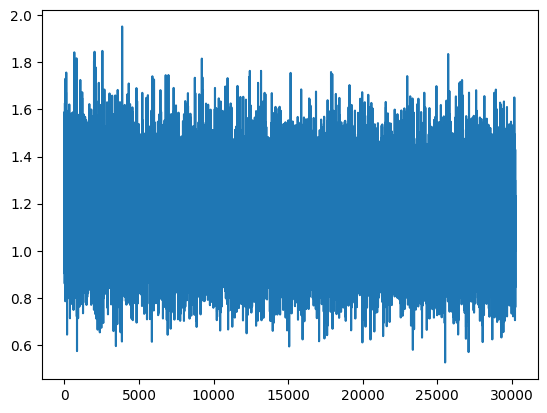

In [22]:
plt.plot(train_losses)

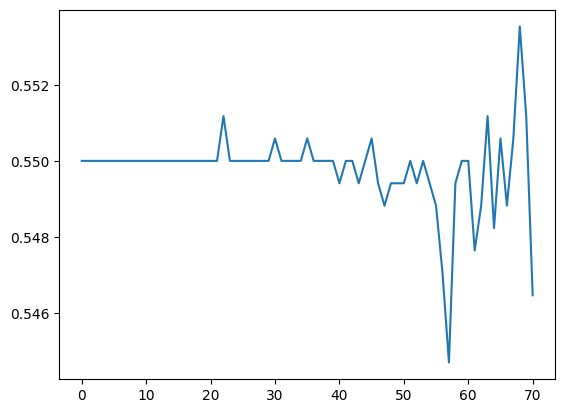

In [23]:
plt.plot(test_accuracy)

In [24]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 927/1696 (0.5466)
{'acc_detail': tensor([0.9733, 0.0116, 0.0000, 0.0506], device='cuda:0'),
 'acc_unweighted': tensor(0.2589, device='cuda:0'),
 'acc_weighted': tensor(0.5466, device='cuda:0'),
 'f1s': tensor(0.2045, device='cuda:0'),
 'f1s_detail': tensor([0.7071, 0.0222, 0.0000, 0.0887], device='cuda:0'),
 'precision_detail': tensor([0.5552, 0.2353, 0.0000, 0.3611], device='cuda:0'),
 'recall_detail': tensor([0.9733, 0.0116, 0.0000, 0.0506], device='cuda:0'),
 'rocauc': tensor([0.5879, 0.5484, 0.5488, 0.6264], device='cuda:0'),
 'uar': tensor(0.2589, device='cuda:0'),
 'wap': tensor(0.4085, device='cuda:0')}


tensor([[910,  12,   2,  11],
        [330,   4,   2,   8],
        [155,   1,   0,   4],
        [244,   0,   0,  13]], device='cuda:0')

In [25]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_meld4/meld4_m18emo4_best_69epoch.pt
Correct: 941/1696 (0.5548)
{'acc_detail': tensor([0.9968, 0.0087, 0.0063, 0.0195], device='cuda:0'),
 'acc_unweighted': tensor(0.2578, device='cuda:0'),
 'acc_weighted': tensor(0.5548, device='cuda:0'),
 'f1s': tensor(0.1951, device='cuda:0'),
 'f1s_detail': tensor([0.7134, 0.0172, 0.0121, 0.0376], device='cuda:0'),
 'precision_detail': tensor([0.5554, 0.7500, 0.2000, 0.5556], device='cuda:0'),
 'recall_detail': tensor([0.9968, 0.0087, 0.0063, 0.0195], device='cuda:0'),
 'rocauc': tensor([0.5886, 0.5600, 0.5495, 0.6223], device='cuda:0'),
 'uar': tensor(0.2578, device='cuda:0'),
 'wap': tensor(0.5614, device='cuda:0')}


tensor([[932,   1,   2,   0],
        [338,   3,   1,   2],
        [157,   0,   1,   2],
        [251,   0,   1,   5]], device='cuda:0')

In [26]:
np.save('../models_meld4/meld4_m18emo4_71epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_meld4/meld4_m18emo4_71epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [27]:
checkpoint_path = '../models_meld4/meld4_m18emo4_71epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [29]:
from IConNet.visualizer import visualize_model

layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

(array([11.,  7.,  5.,  6.,  4.,  7.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         1.,  3.,  4.,  3.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,
         1.,  4.,  0.,  4.,  0.,  3.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,
         3.]),
 array([0.        , 0.01191887, 0.02383774, 0.03575661, 0.04767548,
        0.05959435, 0.07151322, 0.08343209, 0.09535096, 0.10726982,
        0.1191887 , 0.13110757, 0.14302644, 0.1549453 , 0.16686417,
        0.17878304, 0.19070192, 0.20262079, 0.21453965, 0.22645852,
        0.23837739, 0.25029626, 0.26221514, 0.27413401, 0.28605288,
        0.29797173, 0.3098906 , 0.32180947, 0.33372834, 0.34564722,
        0.35756609, 0.36948496, 0.38140383, 0.39332271, 0.40524158,
        0.41716045, 0.42907929, 0.44099817, 0.45291704, 0.46483591,
        0.47675478]),
 <BarContainer object of 40 artists>)

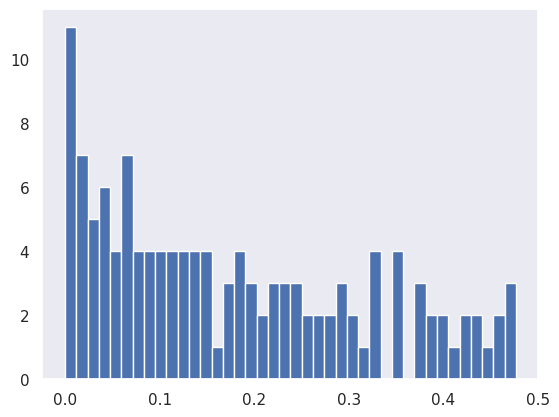

In [30]:
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 126.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-3.51689950e-13, -3.16771864e-13, -2.81853750e-13, -2.46935664e-13,
        -2.12017564e-13, -1.77099465e-13, -1.42181365e-13, -1.07263265e-13,
        -7.23451653e-14, -3.74270690e-14, -2.50897258e-15,  3.24091238e-14,
         6.73272202e-14,  1.02245320e-13,  1.37163420e-13,  1.72081519e-13,
         2.06999619e-13,  2.41917705e-13,  2.76835819e-13,  3.11753905e-13,
         3.46672018e-13,  3.81590105e-13,  4.16508191e-13,  4.51426304e-13,
         4.86344417e-13,  5.21262504e-13,  5.56180590e-13,  5.91098676e-13,
         6.26016762e-13,  6.60934903e-13,  6.95852989e-13,  7.30771075e-13,
         7.65689161e-13,  8.00607302e-13,  8.35525388e-13,  8.70443474e-13,
         9.05361560e-13,  9.40279647e-13, 

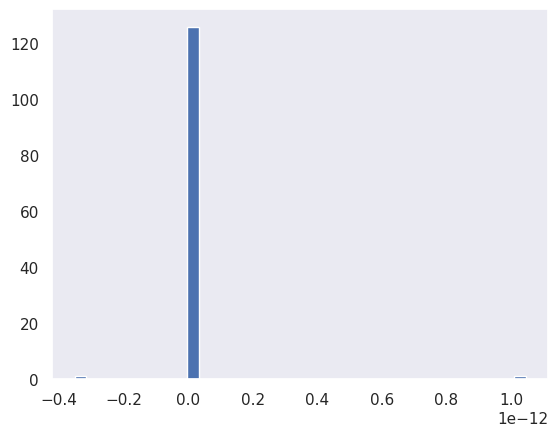

In [31]:
lowbands = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

/tmp/ipykernel_3064191/1402059949.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands.flatten())
/tmp/ipykernel_3064191/1402059949.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands.flatten())


(array([1., 1., 1., 0., 1., 1., 3., 1., 2., 4., 5., 2., 2., 4., 4., 3., 2.,
        4., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([-43.65545273, -43.25374222, -42.85202789, -42.45031738,
        -42.04860306, -41.64689255, -41.24518204, -40.84346771,
        -40.4417572 , -40.04004288, -39.63833237, -39.23662186,
        -38.83490753, -38.43319702, -38.0314827 , -37.62977219,
        -37.22806168, -36.82634735, -36.42463684, -36.02292252,
        -35.62121201, -35.2195015 , -34.81778717, -34.41607666,
        -34.01436234, -33.61265182, -33.21094131, -32.80922699,
        -32.40751648, -32.00580215, -31.60409164, -31.20237923,
        -30.80066681, -30.3989563 , -29.99724388, -29.59553146,
        -29.19381905, -28.79210663, -28.39039612, -27.9886837 ,
        -27.58697128]),
 <BarContainer object of 40 artists>)

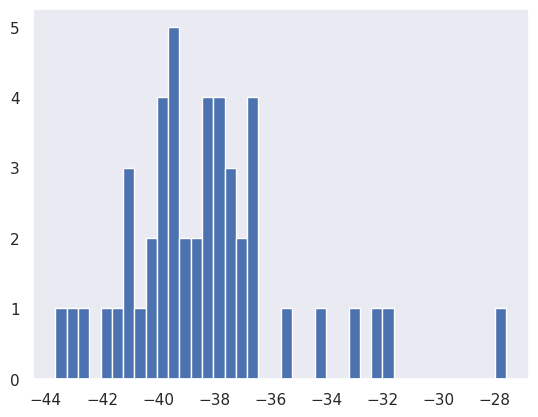

In [32]:
grad_log = np.log(lowbands.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([3., 4., 4., 5., 6., 6., 7., 8., 7., 5., 8., 6., 5., 5., 6., 3., 4.,
        5., 4., 4., 3., 3., 1., 3., 2., 2., 1., 0., 2., 0., 2., 0., 1., 1.,
        0., 0., 1., 0., 0., 1.]),
 array([0.0035846 , 0.00452443, 0.00546425, 0.00640408, 0.0073439 ,
        0.00828373, 0.00922356, 0.01016338, 0.01110321, 0.01204303,
        0.01298286, 0.01392268, 0.01486251, 0.01580233, 0.01674216,
        0.01768199, 0.01862181, 0.01956164, 0.02050146, 0.02144129,
        0.02238112, 0.02332094, 0.02426077, 0.02520059, 0.02614042,
        0.02708025, 0.02802007, 0.0289599 , 0.02989972, 0.03083955,
        0.03177937, 0.0327192 , 0.03365903, 0.03459885, 0.03553868,
        0.0364785 , 0.03741833, 0.03835815, 0.03929798, 0.0402378 ,
        0.04117763]),
 <BarContainer object of 40 artists>)

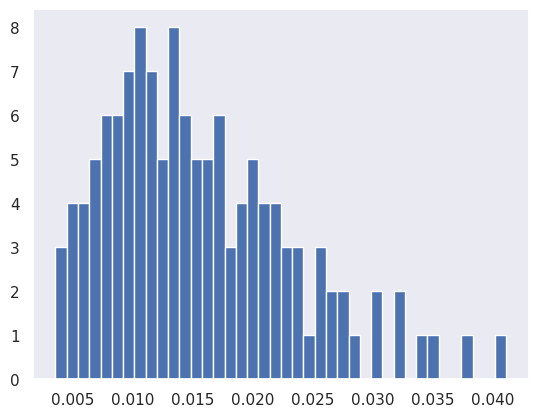

In [33]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 127.]),
 array([-3.52865605e-13, -3.43911125e-13, -3.34956672e-13, -3.26002192e-13,
        -3.17047739e-13, -3.08093259e-13, -2.99138779e-13, -2.90184326e-13,
        -2.81229846e-13, -2.72275366e-13, -2.63320913e-13, -2.54366434e-13,
        -2.45411981e-13, -2.36457501e-13, -2.27503021e-13, -2.18548568e-13,
        -2.09594088e-13, -2.00639622e-13, -1.91685155e-13, -1.82730689e-13,
        -1.73776209e-13, -1.64821742e-13, -1.55867276e-13, -1.46912810e-13,
        -1.37958343e-13, -1.29003863e-13, -1.20049397e-13, -1.11094930e-13,
        -1.02140457e-13, -9.31859909e-14, -8.42315177e-14, -7.52770513e-14,
        -6.63225781e-14, -5.73681117e-14, -4.84136419e-14, -3.94591721e-14,
        -3.05047024e-14, -2.15502326e-14, 

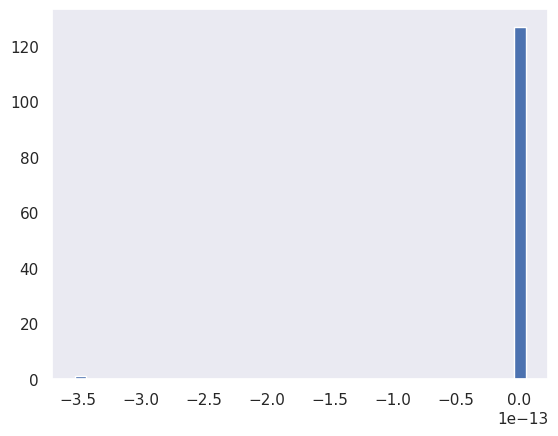

In [34]:
bandwidths = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

/tmp/ipykernel_3064191/1421197636.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths.flatten()), bins=40)


(array([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([-42.09713745, -41.86642456, -41.63571167, -41.40499496,
        -41.17428207, -40.94356918, -40.71285629, -40.48213959,
        -40.2514267 , -40.02071381, -39.79000092, -39.55928802,
        -39.32857132, -39.09785843, -38.86714554, -38.63643265,
        -38.40571594, -38.17500305, -37.94429016, -37.71357727,
        -37.48286438, -37.25214767, -37.02143478, -36.79072189,
        -36.560009  , -36.3292923 , -36.09857941, -35.86786652,
        -35.63715363, -35.40643692, -35.17572403, -34.94501114,
        -34.71429825, -34.48358536, -34.25286865, -34.02215576,
        -33.79144287, -33.56072998, -33.33001328, -33.09930038,
        -32.86858749]),
 <BarContainer object of 40 artists>)

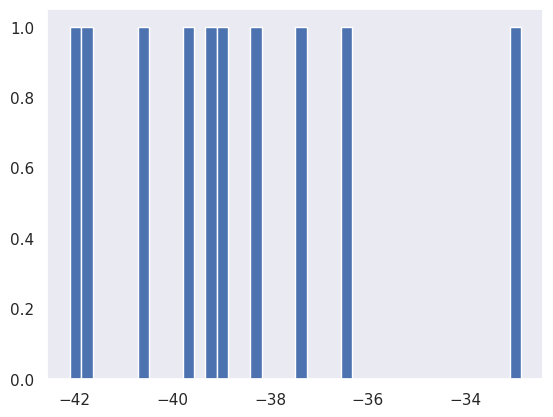

In [35]:
plt.hist(np.log(bandwidths.flatten()), bins=40)

(array([ 2.,  3.,  2.,  0.,  3.,  2.,  1.,  5., 13.,  3.,  7., 22., 16.,
        16., 26., 11., 17., 13.,  9., 17., 13.,  1.,  9.,  1.,  7., 11.,
         1.,  8., 10.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         3.]),
 array([-0.03737735, -0.01478896,  0.00779944,  0.03038783,  0.05297622,
         0.07556462,  0.09815301,  0.1207414 ,  0.1433298 ,  0.1659182 ,
         0.18850659,  0.21109499,  0.23368338,  0.25627178,  0.27886018,
         0.30144855,  0.32403696,  0.34662536,  0.36921376,  0.39180213,
         0.41439053,  0.43697894,  0.45956734,  0.48215571,  0.50474411,
         0.52733248,  0.54992092,  0.57250929,  0.59509772,  0.61768609,
         0.64027447,  0.6628629 ,  0.68545127,  0.70803964,  0.73062807,
         0.75321645,  0.77580488,  0.79839325,  0.82098162,  0.84357005,
         0.86615843]),
 <BarContainer object of 40 artists>)

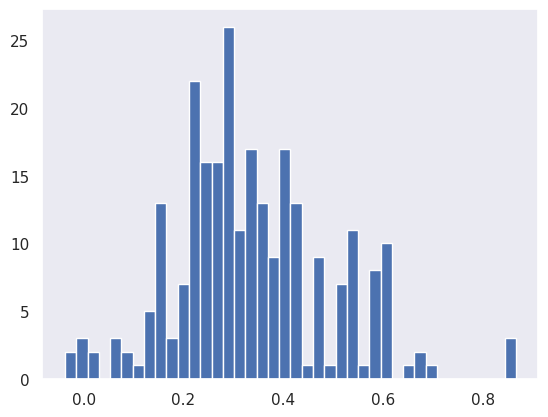

In [36]:
window_params = named_params[2][1].detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

(array([ 2.,  2.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  7.,  2.,
         4.,  0.,  0.,  0.,  5.,  4.,  8.,  3.,  2.,  7., 10.,  3., 10.,
         8.,  3.,  4.,  2.,  4., 12., 13., 18., 30., 13., 35., 21., 14.,
         3.]),
 array([-1.09567083e-02, -1.06732585e-02, -1.03898086e-02, -1.01063587e-02,
        -9.82290879e-03, -9.53945890e-03, -9.25600808e-03, -8.97255819e-03,
        -8.68910830e-03, -8.40565842e-03, -8.12220853e-03, -7.83875864e-03,
        -7.55530875e-03, -7.27185886e-03, -6.98840851e-03, -6.70495862e-03,
        -6.42150873e-03, -6.13805884e-03, -5.85460896e-03, -5.57115860e-03,
        -5.28770871e-03, -5.00425883e-03, -4.72080894e-03, -4.43735905e-03,
        -4.15390870e-03, -3.87045881e-03, -3.58700892e-03, -3.30355903e-03,
        -3.02010891e-03, -2.73665902e-03, -2.45320913e-03, -2.16975901e-03,
        -1.88630912e-03, -1.60285912e-03, -1.31940912e-03, -1.03595911e-03,
        -7.52509164e-04, -4.69059189e-04, -1.85609213e-04,  9.78407625e-05,
      

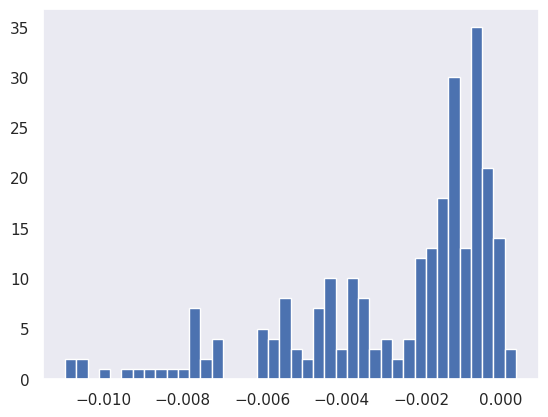

In [37]:
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

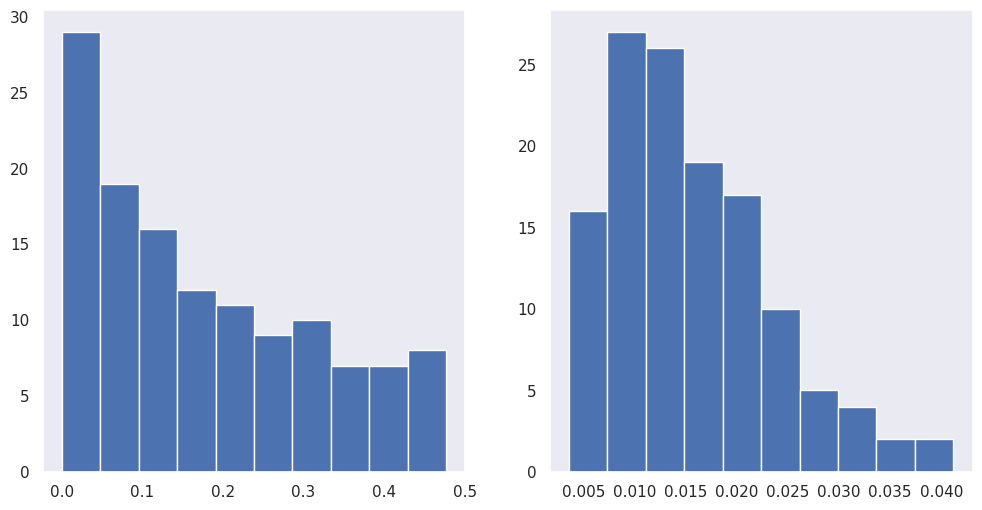

In [38]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


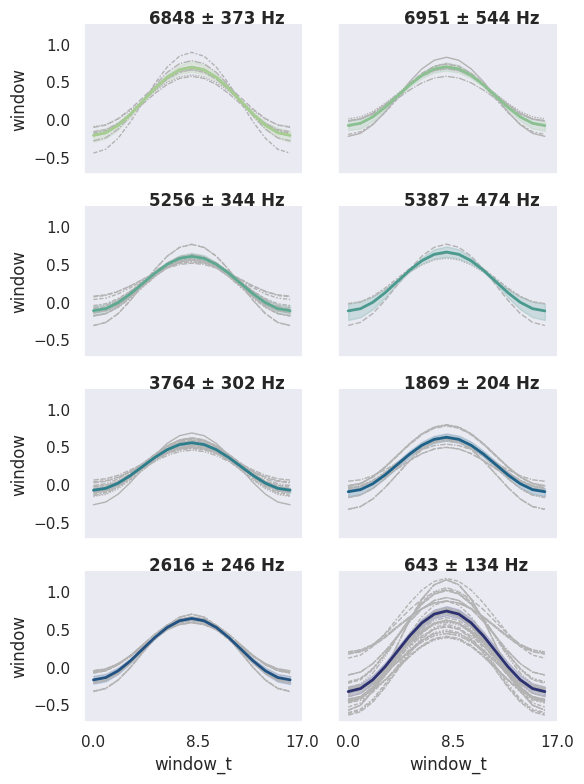

In [39]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


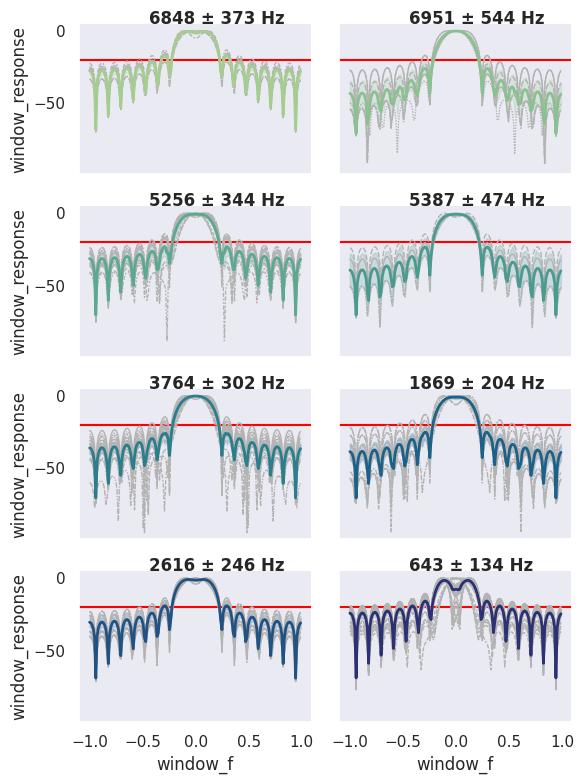

In [40]:
filtviz.visualize_filters(filter_domain='freq')

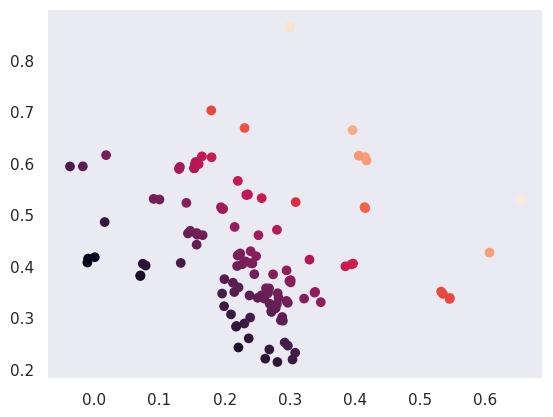

In [47]:
filtviz.visualize_window_params()

(array([3.0000e+00, 1.0000e+00, 5.0000e+00, 6.0000e+00, 8.0000e+00,
        1.6000e+01, 1.6000e+01, 2.8000e+01, 3.1000e+01, 7.4000e+01,
        7.1000e+01, 1.2300e+02, 1.5800e+02, 1.7000e+02, 2.5200e+02,
        3.0800e+02, 4.1300e+02, 6.7900e+02, 1.4910e+03, 5.5640e+03,
        2.2842e+04, 2.5450e+03, 8.1200e+02, 4.8600e+02, 3.4700e+02,
        1.8300e+02, 8.0000e+01, 5.0000e+01, 1.6000e+01, 2.7000e+01,
        1.0000e+01, 1.3000e+01, 7.0000e+00, 9.0000e+00, 7.0000e+00,
        4.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([-1.34417461e-03, -1.27779110e-03, -1.21140771e-03, -1.14502420e-03,
        -1.07864081e-03, -1.01225730e-03, -9.45873791e-04, -8.79490341e-04,
        -8.13106890e-04, -7.46723439e-04, -6.80339988e-04, -6.13956479e-04,
        -5.47573029e-04, -4.81189578e-04, -4.14806098e-04, -3.48422618e-04,
        -2.82039167e-04, -2.15655702e-04, -1.49272237e-04, -8.28887714e-05,
        -1.65053061e-05,  4.98781592e-05,  1.16261624e-04,  1.82645090e-04

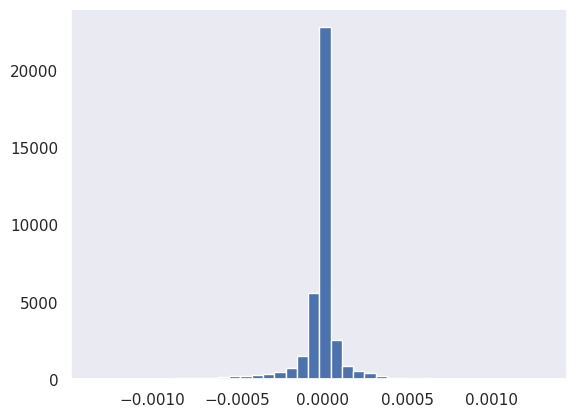

In [41]:
layer2 = model.fe_blocks.blocks[1].block.layer
named_params2 = [p for p in layer2.named_parameters()]
winparams2_grad = named_params2[2][1].grad.detach().cpu().numpy()
plt.hist(winparams2_grad.flatten(), bins=40)

/tmp/ipykernel_3064191/2725551856.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(winparams2_grad.flatten())
/tmp/ipykernel_3064191/2725551856.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(winparams2_grad.flatten())


(array([4.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 2.000e+00,
        8.000e+00, 1.300e+01, 8.000e+00, 1.800e+01, 2.400e+01, 3.800e+01,
        4.700e+01, 6.800e+01, 1.090e+02, 1.070e+02, 1.830e+02, 2.900e+02,
        3.460e+02, 4.490e+02, 6.040e+02, 7.430e+02, 8.520e+02, 9.960e+02,
        1.100e+03, 1.356e+03, 1.520e+03, 1.760e+03, 1.784e+03, 1.520e+03,
        1.269e+03, 9.430e+02, 6.680e+02, 5.690e+02, 5.230e+02, 4.170e+02,
        1.930e+02, 6.300e+01, 3.900e+01, 1.500e+01]),
 array([-19.78545952, -19.45674324, -19.12802887, -18.79931259,
        -18.47059822, -18.14188194, -17.81316566, -17.48445129,
        -17.15573502, -16.82702065, -16.49830437, -16.16959   ,
        -15.84087372, -15.51215839, -15.18344307, -14.85472679,
        -14.52601147, -14.19729614, -13.86858082, -13.53986549,
        -13.21114922, -12.88243389, -12.55371857, -12.22500324,
        -11.89628792, -11.56757259, -11.23885632, -10.91014099,
        -10.58142567, -10.25271034,  -9.92399502,  -9.

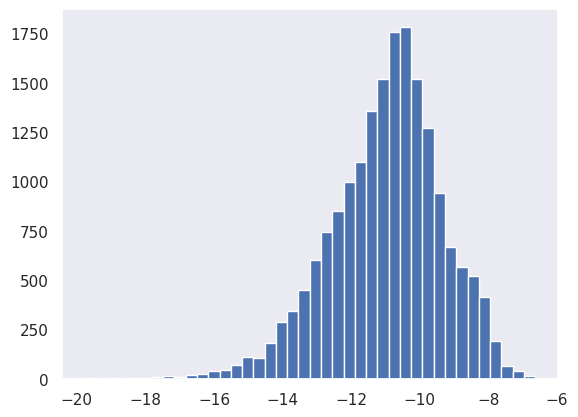

In [43]:
grad_log = np.log(winparams2_grad.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

downsample_factor: 2 => new_sample_rate: 8000
Time domain: Filters' shapes vary by frequency bins


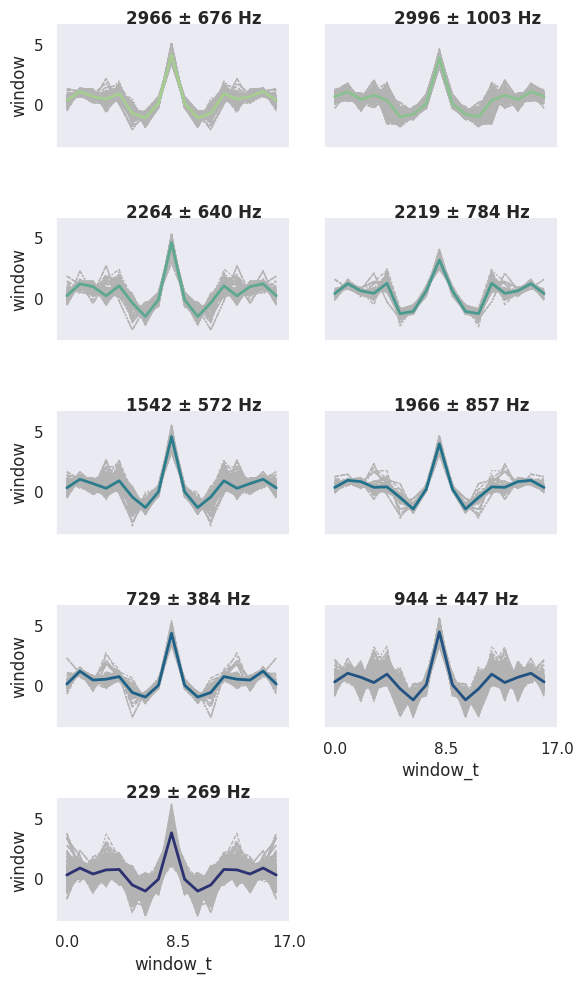

In [44]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


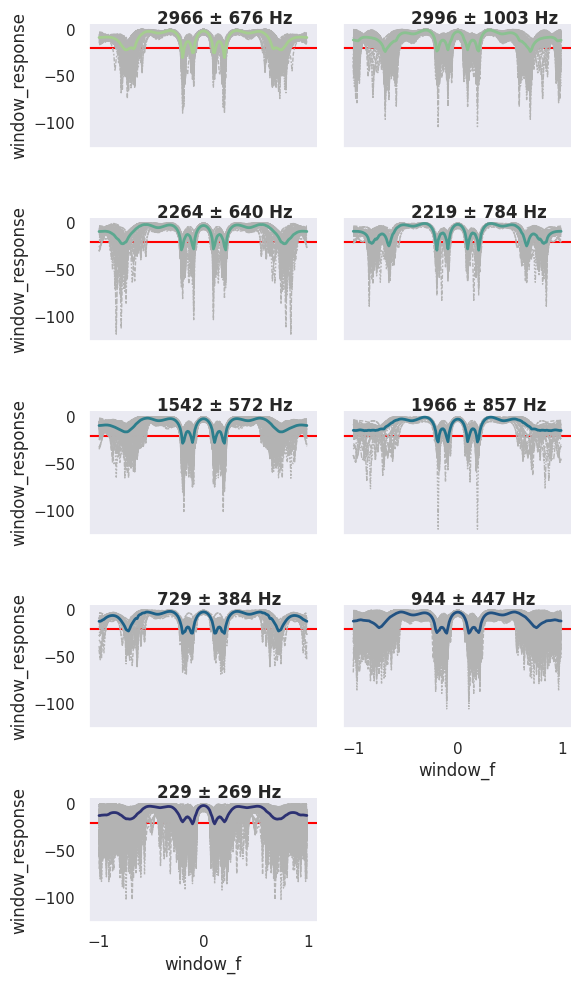

In [45]:
filtviz2.visualize_filters('freq')

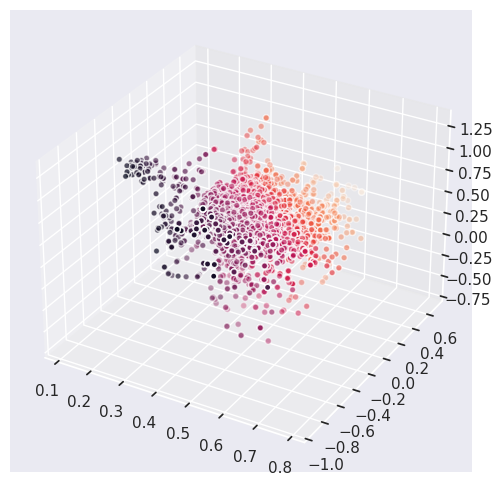

In [46]:
filtviz2.visualize_window_params()